In [1]:
import numpy as np
import cv2

import tensorflow as tf

class DataGenerator(tf.keras.utils.Sequence):
    
    """
    The custom data generator class generates and feeds data to
    the model dynamically in batches during the training phase.
    
    This generator generates batched of data for the dataset available @
    Find the nuclei in divergent images to advance medical discovery -
    https://www.kaggle.com/c/data-science-bowl-2018
    
    **
    tf.keras.utils.Sequence is the root class for 
    Custom Data Generators.
    **
    
    Args:
        image_ids: the ids of the image.
        img_path: the full path of the image directory.
        batch_size: no. of images to be included in a batch feed. Default is set to 8.
        image_size: size of the image. Default is set to 128 as per the data available.
        
    Ref: https://dzlab.github.io/dltips/en/keras/data-generator/
    
    """
    def __init__(self, image_ids, img_path, batch_size = 8, image_size = 128):
        
        self.ids = image_ids
        self.path = img_path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
        
    def __load__(self, item):
        
        """
        loads the specified image.
        
        """
        
        # the name for parent of parent directory where the image is located and the name of the image are same.
        # an example directory breakup is shown below -
        # - data-science-bowl-2018/
        #      - stage1_train/
        #          - abc
        #             - image
        #                  - abc
        #             - mask
        full_image_path = os.path.join(self.path, "images/", item)

#         print(item)
        # load the images
        image = cv2.imread(full_image_path, cv2.IMREAD_GRAYSCALE)
#         print(full_image_path)
        image = cv2.resize(image, (self.image_size, self.image_size))
        
        masked_img = np.zeros((self.image_size, self.image_size, 1))
        
        # load and prepare the corresponding mask.
        
        fullPath = os.path.join(self.path, "mask/", item)
        masked_img = cv2.imread(fullPath, cv2.IMREAD_GRAYSCALE)
        masked_img = cv2.resize(masked_img, (self.image_size, self.image_size))
#         _masked_img = np.expand_dims(_masked_img, axis = -1)
#         masked_img = np.maximum(masked_img, _masked_img)
            
        # mormalize the mask and the image. 
        image = image/255.0
        masked_img = masked_img/255.0
        
        return image, masked_img
    
    def __getitem__(self, index):
        
        """
        Returns a single batch of data.
        
        Args:
            index: the batch index.
        
        """
        
        # edge case scenario where there are still some items left
        # after segregatings the images into batches of size batch_size.
        # the items left out will form one batch at the end.
        if(index + 1) * self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index * self.batch_size
        
        # group the items into a batch.
        batch = self.ids[index * self.batch_size : (index + 1) * self.batch_size]
        
        image = []
        mask  = []
        
        # load the items in the current batch
        for item in batch:
            img, masked_img = self.__load__(item)
            image.append(img)
            mask.append(masked_img)
        
        image = np.array(image)
        mask  = np.array(mask)
        
        return image, mask
    
    def on_epoch_end(self):
        
        """
        optional method to run some logic at the end of each epoch: e.g. reshuffling
        
        """
        
        pass
    
    def __len__(self):
        
        """
        Returns the number of batches
        """
        return int(np.ceil(len(self.ids)/float(self.batch_size)))
    

2023-05-06 07:42:31.656670: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-06 07:42:31.877711: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-06 07:42:33.759084: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home2/sashank.sridhar/miniconda3/envs/TripletLoss/lib/python3.9/site-packages/cv2/../../lib64:/usr/local/cuda-10.2/lib64:/opt/cudnn-7.6.5.32-cuda-10.2/lib64
2023-05-06 07:42:33.759259: W tensorflow/stream_execut

In [2]:
image_size = 64
image_channels = 1
image_dir = "data/ACDC/resized/train/images"
val_dir = "data/ACDC/resized/test/images"
epochs = 20
batch_size = 8

# there are a total of 670 items at the train_path directory.
# so fixing 600 of data available for training set
# 50 for validation set and 20 for test set.
# validation_data_size = 50
# test_data_size = 20
# train_data_size = 600

In [3]:
import os
image_ids = os.listdir(image_dir)
training_data_ids = image_ids

image_ids = os.listdir(val_dir)

validation_data_ids = image_ids

image_ids = []
for i in training_data_ids:
    if i != '.ipynb_checkpoints':
        image_ids.append(i)
training_data_ids = image_ids
print('mask' in training_data_ids)

image_ids = []
for i in validation_data_ids:
    if i != '.ipynb_checkpoints':
        image_ids.append(i)
validation_data_ids = image_ids
print('mask' in validation_data_ids)

False
False


In [50]:
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy

def dice_metric(X, Y):
    """
    Dice metric for measuring the contour overlap 
    :param X,Y: 2D numpy arrays
    :return: metric scalar
    """
    return np.sum(X[Y==1])*2.0 / (np.sum(X) + np.sum(Y))

In [40]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Cropping2D, Concatenate

class UnetUtils():
    
    """ 
    Unet Model design utillities framework.
    
    This module provides a convenient way to create different layers/blocks
    which the UNet network is based upon. It consists of a contracting
    path and an expansive path. Both these paths are joined by a bottleneck block.
    
    The different blocks involved in the design of the network can be referenced @ 
    U-Net: Convolutional Networks for Biomedical Image Segmentation
    
    Source:
        https://arxiv.org/pdf/1505.04597
    """
    
    def __init__(self):
        pass
    
    def contracting_block(self, input_layer, filters, padding, kernel_size = 3):
        
        """ 
        UNet Contracting block
        Perform two unpadded convolutions with a specified number of filters and downsample
        through max-pooling.
        
        Args:
            input_layer: the input layer on which the current layers should work upon.
            filters (int): Number of filters in convolution.
            kernel_size (int/tuple): Index of block. Default is 3.
            padding ("valid" or "same"): Default is "valid" (no padding involved).
            
        Return:
            Tuple of convolved ``inputs`` after and before downsampling
        """
        
        # two 3x3 convolutions (unpadded convolutions), each followed by
        # a rectified linear unit (ReLU) and a 2x2 max pooling operation with stride 2
        # for downsampling.
        conv = Conv2D(filters = filters, 
                      kernel_size = kernel_size, 
                      activation = tf.nn.relu, 
                      padding = padding)(input_layer)

        conv = Conv2D(filters = filters, 
                      kernel_size = kernel_size, 
                      activation = tf.nn.relu, 
                      padding = padding)(conv)

        pool = MaxPooling2D(pool_size = 2, 
                            strides = 2)(conv)

        return conv, pool

    def bottleneck_block(self, input_layer, filters, padding, kernel_size = 3, strides = 1):
        
        """ 
        UNet bottleneck block
        
        Performs 2 unpadded convolutions with a specified number of filters.
        
        Args:
            input_layer: the input layer on which the current layers should work upon.
            filters (int): Number of filters in convolution.
            kernel_size (int/tuple): Index of block. Default is 3.
            padding ("valid" or "same"): Default is "valid" (no padding involved).
            strides: An integer or tuple/list of 2 integers, specifying the strides 
                     of the convolution along the height and width. Default is 1.
        Return:
            The convolved ``inputs``.
        """
        
        # two 3x3 convolutions (unpadded convolutions), each followed by
        # a rectified linear unit (ReLU)
        conv = Conv2D(filters = filters, 
                      kernel_size = kernel_size, 
                      padding = padding,
                      strides = strides, 
                      activation = tf.nn.relu)(input_layer)

        conv = Conv2D(filters = filters, 
                      kernel_size = kernel_size, 
                      padding = padding,
                      strides = strides, 
                      activation = tf.nn.relu)(conv)

        return conv

    def expansive_block(self, input_layer, skip_conn_layer, filters, padding, kernel_size = 3, strides = 1):
        
        """ 
        UNet expansive (upsample) block.
        
        Transpose convolution which doubles the spatial dimensions (height and width) 
        of the incoming feature maps and creates the skip connections with the corresponding 
        feature maps from the contracting (downsample) path. These skip connections bring the feature maps 
        from earlier layers helping the network to generate better semantic feature maps.
        
        Perform two unpadded convolutions with a specified number of filters 
        and upsamples the incomming feature map.
        
        Args:
            input_layer: the input layer on which the current layers should work upon.
            skip_connection: The feature map from the contracting (downsample) path from which the 
                             skip connection has to be created.
            filters (int): Number of filters in convolution.
            kernel_size (int/tuple): Index of block. Default is 3.
            padding ("valid" or "same"): Default is "valid" (no padding involved).
            strides: An integer or tuple/list of 2 integers, specifying the strides 
                     of the convolution along the height and width. Default is 1.
                     
        Return:
            The upsampled feature map.
        """
        
        # up sample the feature map using transpose convolution operations.
        transConv = Conv2DTranspose(filters = filters, 
                                    kernel_size = (2, 2),
                                    strides = 2, 
                                    padding = padding)(input_layer)
        
        # crop the source feature map so that the skip connection can be established.
        # the original paper implemented unpadded convolutions. So cropping is necessary 
        # due to the loss of border pixels in every convolution.
        # establish the skip connections.
        if padding == "valid":
            cropped = self.crop_tensor(skip_conn_layer, transConv)
            concat = Concatenate()([transConv, cropped])
        else:
            concat = Concatenate()([transConv, skip_conn_layer])
        
        # two 3x3 convolutions, each followed by a ReLU
        up_conv = Conv2D(filters = filters, 
                         kernel_size = kernel_size, 
                         padding = padding, 
                         activation = tf.nn.relu)(concat)

        up_conv = Conv2D(filters = filters, 
                         kernel_size = kernel_size, 
                         padding = padding, 
                         activation = tf.nn.relu)(up_conv)

        return up_conv
    
    def crop_tensor(self, source_tensor, target_tensor):
        
        """
        Center crops the source tensor to the size of the target tensor size.
        The tensor shape format is [batchsize, height, width, channels]
        
        Args:
            source_tensor: the tensor that is to be cropped.
            target_tensor: the tensor to whose size the 
                           source needs to be cropped to.
                           
        Return:
            the cropped version of the source tensor.
        
        """
        
        target_tensor_size = target_tensor.shape[2]
        source_tensor_size = source_tensor.shape[2]
        
        # calculate the delta to ensure correct cropping.
        delta = source_tensor_size - target_tensor_size
        delta = delta // 2
        
        cropped_source = source_tensor[:, delta:source_tensor_size - delta, delta:source_tensor_size - delta, :]
        
        return cropped_source

In [41]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D
UnetUtils = UnetUtils()

class Unet():
    
    """ 
    Unet Model design.
    
    This module consumes the Unet utilities framework moule and designs the Unet network.
    It consists of a contracting path and an expansive path. Both these paths are joined 
    by a bottleneck block.
    
    The different blocks involved in the design of the network can be referenced @ 
    U-Net: Convolutional Networks for Biomedical Image Segmentation
    
    Source:
        https://arxiv.org/pdf/1505.04597
    """
    
    def __init__(self, input_shape = (572, 572, 1), filters = [64, 128, 256, 512, 1024], padding = "valid"):
        """
        
        Initialize the Unet framework and the model parameters - input_shape, 
        filters and padding type. 
        
        Args:
            input_shape: The shape of the input to the network. A tuple comprising of (img_height, img_width, channels).
                         Original paper implementation is (572, 572, 1).
            filters: a collection of filters denoting the number of components to be used at each blocks along the 
                     contracting and expansive paths. The original paper implementation for number of filters along the 
                     contracting and expansive paths are [64, 128, 256, 512, 1024].
            padding: the padding type to be used during the convolution step. The original paper used unpadded convolutions 
                     which is of type "valid".
         
        **Remarks: The default values are as per the implementation in the original paper @ https://arxiv.org/pdf/1505.04597
        
        """
        self.input_shape = input_shape
        self.filters = filters
        self.padding = padding
    
    def Build_UNetwork(self):
        
        """
        Builds the Unet Model network.
        
        Args:
            None
         
        Return:
            The Unet Model.
            
        """

        
        UnetInput = Input(self.input_shape)
        
        # the contracting path. 
        # the last item in the filetrs collection points to the number of filters in the bottleneck block.
        conv1, pool1 = UnetUtils.contracting_block(input_layer = UnetInput, filters = self.filters[0], padding = self.padding)
        conv2, pool2 = UnetUtils.contracting_block(input_layer = pool1, filters = self.filters[1], padding = self.padding)
        conv3, pool3 = UnetUtils.contracting_block(input_layer = pool2, filters = self.filters[2], padding = self.padding)
        conv4, pool4 = UnetUtils.contracting_block(input_layer = pool3, filters = self.filters[3], padding = self.padding)
        
        # bottleneck block connecting the contracting and the expansive paths.
        bottleNeck = UnetUtils.bottleneck_block(pool4, filters = self.filters[4], padding = self.padding)

        # the expansive path.
        upConv1 = UnetUtils.expansive_block(bottleNeck, conv4, filters = self.filters[3], padding = self.padding) 
        upConv2 = UnetUtils.expansive_block(upConv1, conv3, filters = self.filters[2], padding = self.padding) 
        upConv3 = UnetUtils.expansive_block(upConv2, conv2, filters = self.filters[1], padding = self.padding) 
        upConv4 = UnetUtils.expansive_block(upConv3, conv1, filters = self.filters[0], padding = self.padding) 

        UnetOutput = Conv2D(1, (1, 1), padding = self.padding, activation = tf.math.sigmoid)(upConv4)
        
        model = Model(UnetInput, UnetOutput, name = "UNet")
        
        return model

    def CompileAndSummarizeModel(self, model, optimizer = "adam", loss = "binary_crossentropy"):
        
        """
        Compiles and displays the model summary of the Unet model.
        
        Args:
            model: The Unet model.
            optimizer: model optimizer. Default is the adam optimizer.
            loss: the loss function. Default is the binary cross entropy loss.
            
        Return:
            None
        
        """
        model.compile(optimizer=Adam(1e-4, decay=1e-6), loss="binary_crossentropy", metrics=[dice_coef])
        model.summary()
        
    def plotModel(self, model, to_file = 'unet.png', show_shapes = True, dpi = 96):
        
        """
        Saves the Unet model to a file.
        
        Args:
            model: the Unet model. 
            to_file: the file name to save the model. Default name - 'unet.png'.
            show_shapes: whether to display shape information. Default = True.
            dpi: dots per inch. Default value is 96.
            
        Return:
            None
        
        """
        
        tf.keras.utils.plot_model(model, to_file = to_file, show_shapes = show_shapes, dpi = dpi)

In [42]:
unet = Unet(input_shape = (64, 64, image_channels), 
            filters = [16, 32, 64, 128, 256], 
            padding = "same")

# call the build netowrk API to build the network.
model = unet.Build_UNetwork()

In [43]:

from keras.models import model_from_json
from keras.models import load_model

# load json and create model
json_file = open('./model/unet.json', 'r')

loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("./model/unet.h5")
print("Loaded model from disk")

Loaded model from disk


In [44]:
train_gen = DataGenerator(image_ids = training_data_ids, 
                                img_path = 'data/ACDC/resized/train', 
                                image_size = image_size, 
                                batch_size = batch_size)

valid_gen = DataGenerator(image_ids = validation_data_ids, 
                                img_path = 'data/ACDC/resized/test', 
                                image_size = image_size, 
                                batch_size = batch_size)

# test_gen = DataGenerator(image_ids = testing_data_ids, 
#                                img_path = image_dir, 
#                                image_size = image_size, 
#                                batch_size = batch_size)

train_steps = len(training_data_ids)//batch_size
valid_steps = len(validation_data_ids)//batch_size

In [45]:
# get the test set images
test_images, test_masks = train_gen.__getitem__(100)
predicted_masks = loaded_model.predict(test_images)
# print(predicted_masks[0])
op = np.zeros((64, 64))
for i in range(0, len(predicted_masks[0])):
    for j in range(0, len(predicted_masks[0])):
#         print(predicted_masks[0][i][j][0])
        if predicted_masks[0][i][j][0] > 0.15:
            op[i][j] = 255
        else:
            op[i][j] = 0
print(np.unique(op))


1/1 [==============================] - 0s 224ms/step
[  0. 255.]


In [46]:
from skimage import measure
contours_pred = measure.find_contours(op, 0.8)
contour_pred = contours_pred[np.argmax([k.shape[0] for k in contours_pred])]

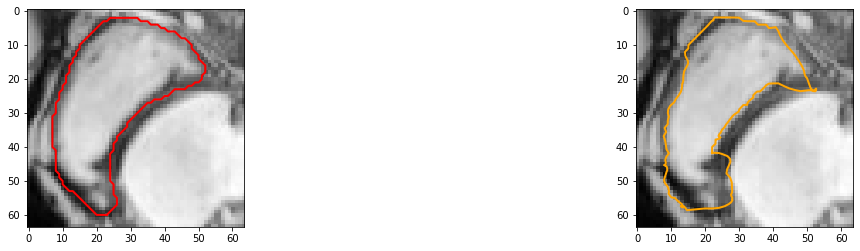

In [47]:
from skimage.segmentation import chan_vese, active_contour
import matplotlib.pyplot as plt
img = test_images[0].reshape((64,64))
ac_contour = active_contour(img, contour_pred, alpha=0.01, beta=1)
f, ax = plt.subplots(ncols=2, figsize=(20,4))
# ax[0].imshow(X_input, cmap='gray')
# ax[0].imshow(X_roi, cmap='gray')
ax[0].imshow(img, cmap='gray')
ax[0].plot(contour_pred[:, 1], contour_pred[:, 0], linewidth=2, color='red',label='Prediction')
ax[1].imshow(img, cmap='gray')
ax[1].plot(ac_contour[:, 1], ac_contour[:, 0], linewidth=2, color='orange',label='Prediction')

In [64]:
from matplotlib.path import Path
import tqdm
t = []
for idx in tqdm.tqdm(range(len(training_data_ids))):
    # get the test set images
    test_images, test_masks = train_gen.__getitem__(i)
    predicted_masks = loaded_model.predict(test_images)
    # print(predicted_masks[0])
    op = np.zeros((64, 64))
    for i in range(0, len(predicted_masks[0])):
        for j in range(0, len(predicted_masks[0])):
    #         print(predicted_masks[0][i][j][0])
            if predicted_masks[0][i][j][0] > 0.15:
                op[i][j] = 1
            else:
                op[i][j] = 0
                
    t.append(dice_metric(test_masks[0], op))

  0%|                                                                                          | 0/1243 [00:00<?, ?it/s]

1/1 [==============================] - 0s 58ms/step


  0%|                                                                                  | 1/1243 [00:00<02:41,  7.68it/s]

1/1 [==============================] - 0s 36ms/step


  0%|▏                                                                                 | 3/1243 [00:00<01:58, 10.44it/s]

1/1 [==============================] - 0s 40ms/step


  0%|▎                                                                                 | 5/1243 [00:00<01:53, 10.89it/s]

1/1 [==============================] - 0s 46ms/step


  1%|▍                                                                                 | 7/1243 [00:00<02:01, 10.21it/s]

1/1 [==============================] - 0s 44ms/step


  1%|▌                                                                                 | 9/1243 [00:00<02:05,  9.85it/s]

1/1 [==============================] - 0s 43ms/step


  1%|▋                                                                                | 10/1243 [00:01<02:05,  9.81it/s]

1/1 [==============================] - 0s 43ms/step


  1%|▋                                                                                | 11/1243 [00:01<02:06,  9.76it/s]

1/1 [==============================] - 0s 45ms/step


  1%|▊                                                                                | 12/1243 [00:01<02:06,  9.71it/s]

1/1 [==============================] - 0s 43ms/step


  1%|▊                                                                                | 13/1243 [00:01<02:05,  9.78it/s]

1/1 [==============================] - 0s 42ms/step


  1%|▉                                                                                | 15/1243 [00:01<02:02, 10.01it/s]

1/1 [==============================] - 0s 40ms/step


  1%|█                                                                                | 17/1243 [00:01<02:03,  9.95it/s]

1/1 [==============================] - 0s 40ms/step


  1%|█▏                                                                               | 18/1243 [00:01<02:03,  9.92it/s]

1/1 [==============================] - 0s 41ms/step


  2%|█▏                                                                               | 19/1243 [00:01<02:03,  9.92it/s]

1/1 [==============================] - 0s 40ms/step


  2%|█▎                                                                               | 21/1243 [00:02<02:00, 10.10it/s]

1/1 [==============================] - 0s 39ms/step


  2%|█▍                                                                               | 23/1243 [00:02<01:59, 10.19it/s]

1/1 [==============================] - 0s 41ms/step


  2%|█▋                                                                               | 25/1243 [00:02<01:59, 10.21it/s]

1/1 [==============================] - 0s 41ms/step


  2%|█▊                                                                               | 27/1243 [00:02<02:02,  9.93it/s]

1/1 [==============================] - 0s 39ms/step


  2%|█▉                                                                               | 29/1243 [00:02<02:00, 10.08it/s]

1/1 [==============================] - 0s 42ms/step


  2%|██                                                                               | 31/1243 [00:03<02:03,  9.85it/s]

1/1 [==============================] - 0s 41ms/step


  3%|██▏                                                                              | 33/1243 [00:03<02:01,  9.95it/s]

1/1 [==============================] - 0s 40ms/step


  3%|██▎                                                                              | 35/1243 [00:03<02:00, 10.04it/s]

1/1 [==============================] - 0s 40ms/step


  3%|██▍                                                                              | 37/1243 [00:03<01:58, 10.15it/s]

1/1 [==============================] - 0s 37ms/step


  3%|██▌                                                                              | 39/1243 [00:03<01:56, 10.33it/s]

1/1 [==============================] - 0s 38ms/step


  3%|██▋                                                                              | 41/1243 [00:04<01:54, 10.52it/s]

1/1 [==============================] - 0s 40ms/step


  3%|██▊                                                                              | 43/1243 [00:04<01:54, 10.44it/s]

1/1 [==============================] - 0s 41ms/step


  4%|██▉                                                                              | 45/1243 [00:04<01:57, 10.24it/s]

1/1 [==============================] - 0s 45ms/step


  4%|███                                                                              | 47/1243 [00:04<01:58, 10.13it/s]

1/1 [==============================] - 0s 38ms/step


  4%|███▏                                                                             | 49/1243 [00:04<01:56, 10.24it/s]

1/1 [==============================] - 0s 37ms/step


  4%|███▎                                                                             | 51/1243 [00:05<01:54, 10.45it/s]

1/1 [==============================] - 0s 39ms/step


  4%|███▍                                                                             | 53/1243 [00:05<01:53, 10.49it/s]

1/1 [==============================] - 0s 38ms/step


  4%|███▌                                                                             | 55/1243 [00:05<01:52, 10.52it/s]

1/1 [==============================] - 0s 37ms/step


  5%|███▋                                                                             | 57/1243 [00:05<01:51, 10.59it/s]

1/1 [==============================] - 0s 37ms/step


  5%|███▊                                                                             | 59/1243 [00:05<01:50, 10.68it/s]

1/1 [==============================] - 0s 39ms/step


  5%|███▉                                                                             | 61/1243 [00:05<01:50, 10.70it/s]

1/1 [==============================] - 0s 39ms/step


  5%|████                                                                             | 63/1243 [00:06<01:50, 10.67it/s]

1/1 [==============================] - 0s 37ms/step


  5%|████▏                                                                            | 65/1243 [00:06<01:49, 10.75it/s]

1/1 [==============================] - 0s 38ms/step


  5%|████▎                                                                            | 67/1243 [00:06<01:48, 10.83it/s]

1/1 [==============================] - 0s 37ms/step


  6%|████▍                                                                            | 69/1243 [00:06<01:47, 10.90it/s]

1/1 [==============================] - 0s 38ms/step


  6%|████▋                                                                            | 71/1243 [00:06<01:47, 10.90it/s]

1/1 [==============================] - 0s 42ms/step


  6%|████▊                                                                            | 73/1243 [00:07<01:49, 10.69it/s]

1/1 [==============================] - 0s 37ms/step


  6%|████▉                                                                            | 75/1243 [00:07<01:49, 10.70it/s]

1/1 [==============================] - 0s 37ms/step


  6%|█████                                                                            | 77/1243 [00:07<01:49, 10.69it/s]

1/1 [==============================] - 0s 39ms/step


  6%|█████▏                                                                           | 79/1243 [00:07<01:49, 10.60it/s]

1/1 [==============================] - 0s 38ms/step


  7%|█████▎                                                                           | 81/1243 [00:07<01:50, 10.54it/s]

1/1 [==============================] - 0s 37ms/step


  7%|█████▍                                                                           | 83/1243 [00:08<01:51, 10.40it/s]

1/1 [==============================] - 0s 37ms/step


  7%|█████▌                                                                           | 85/1243 [00:08<01:52, 10.31it/s]

1/1 [==============================] - 0s 39ms/step


  7%|█████▋                                                                           | 87/1243 [00:08<01:51, 10.39it/s]

1/1 [==============================] - 0s 36ms/step


  7%|█████▊                                                                           | 89/1243 [00:08<01:49, 10.55it/s]

1/1 [==============================] - 0s 36ms/step


  7%|█████▉                                                                           | 91/1243 [00:08<01:46, 10.79it/s]

1/1 [==============================] - 0s 37ms/step


  7%|██████                                                                           | 93/1243 [00:08<01:48, 10.60it/s]

1/1 [==============================] - 0s 36ms/step


  8%|██████▏                                                                          | 95/1243 [00:09<01:47, 10.72it/s]

1/1 [==============================] - 0s 40ms/step


  8%|██████▎                                                                          | 97/1243 [00:09<01:48, 10.55it/s]

1/1 [==============================] - 0s 37ms/step


  8%|██████▍                                                                          | 99/1243 [00:09<01:48, 10.58it/s]

1/1 [==============================] - 0s 37ms/step


  8%|██████▌                                                                         | 101/1243 [00:09<01:48, 10.56it/s]

1/1 [==============================] - 0s 37ms/step


  8%|██████▋                                                                         | 103/1243 [00:09<01:47, 10.64it/s]

1/1 [==============================] - 0s 37ms/step


  8%|██████▊                                                                         | 105/1243 [00:10<01:45, 10.78it/s]

1/1 [==============================] - 0s 37ms/step


  9%|██████▉                                                                         | 107/1243 [00:10<01:44, 10.82it/s]

1/1 [==============================] - 0s 37ms/step


  9%|███████                                                                         | 109/1243 [00:10<01:44, 10.87it/s]

1/1 [==============================] - 0s 37ms/step


  9%|███████▏                                                                        | 111/1243 [00:10<01:44, 10.84it/s]

1/1 [==============================] - 0s 37ms/step


  9%|███████▎                                                                        | 113/1243 [00:10<01:43, 10.88it/s]

1/1 [==============================] - 0s 37ms/step


  9%|███████▍                                                                        | 115/1243 [00:11<01:43, 10.87it/s]

1/1 [==============================] - 0s 37ms/step


  9%|███████▌                                                                        | 117/1243 [00:11<01:43, 10.90it/s]

1/1 [==============================] - 0s 37ms/step


 10%|███████▋                                                                        | 119/1243 [00:11<01:42, 11.01it/s]

1/1 [==============================] - 0s 40ms/step


 10%|███████▊                                                                        | 121/1243 [00:11<01:46, 10.52it/s]

1/1 [==============================] - 0s 39ms/step


 10%|███████▉                                                                        | 123/1243 [00:11<01:46, 10.50it/s]

1/1 [==============================] - 0s 40ms/step


 10%|████████                                                                        | 125/1243 [00:11<01:46, 10.49it/s]

1/1 [==============================] - 0s 44ms/step


 10%|████████▏                                                                       | 127/1243 [00:12<01:47, 10.35it/s]

1/1 [==============================] - 0s 41ms/step


 10%|████████▎                                                                       | 129/1243 [00:12<01:46, 10.44it/s]

1/1 [==============================] - 0s 39ms/step


 11%|████████▍                                                                       | 131/1243 [00:12<01:47, 10.37it/s]

1/1 [==============================] - 0s 36ms/step


 11%|████████▌                                                                       | 133/1243 [00:12<01:45, 10.51it/s]

1/1 [==============================] - 0s 38ms/step


 11%|████████▋                                                                       | 135/1243 [00:12<01:45, 10.54it/s]

1/1 [==============================] - 0s 38ms/step


 11%|████████▊                                                                       | 137/1243 [00:13<01:44, 10.57it/s]

1/1 [==============================] - 0s 38ms/step


 11%|████████▉                                                                       | 139/1243 [00:13<01:45, 10.50it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█████████                                                                       | 141/1243 [00:13<01:45, 10.48it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█████████▏                                                                      | 143/1243 [00:13<01:43, 10.62it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█████████▎                                                                      | 145/1243 [00:13<01:42, 10.71it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█████████▍                                                                      | 147/1243 [00:14<01:42, 10.74it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█████████▌                                                                      | 149/1243 [00:14<01:41, 10.77it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█████████▋                                                                      | 151/1243 [00:14<01:40, 10.86it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█████████▊                                                                      | 153/1243 [00:14<01:39, 10.91it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█████████▉                                                                      | 155/1243 [00:14<01:39, 10.97it/s]

1/1 [==============================] - 0s 37ms/step


 13%|██████████                                                                      | 157/1243 [00:14<01:38, 11.02it/s]

1/1 [==============================] - 0s 37ms/step


 13%|██████████▏                                                                     | 159/1243 [00:15<01:39, 10.95it/s]

1/1 [==============================] - 0s 40ms/step


 13%|██████████▎                                                                     | 161/1243 [00:15<01:41, 10.70it/s]

1/1 [==============================] - 0s 37ms/step


 13%|██████████▍                                                                     | 163/1243 [00:15<01:40, 10.73it/s]

1/1 [==============================] - 0s 36ms/step


 13%|██████████▌                                                                     | 165/1243 [00:15<01:39, 10.86it/s]

1/1 [==============================] - 0s 38ms/step


 13%|██████████▋                                                                     | 167/1243 [00:15<01:39, 10.84it/s]

1/1 [==============================] - 0s 37ms/step


 14%|██████████▉                                                                     | 169/1243 [00:16<01:39, 10.77it/s]

1/1 [==============================] - 0s 37ms/step


 14%|███████████                                                                     | 171/1243 [00:16<01:39, 10.79it/s]

1/1 [==============================] - 0s 37ms/step


 14%|███████████▏                                                                    | 173/1243 [00:16<01:38, 10.87it/s]

1/1 [==============================] - 0s 36ms/step


 14%|███████████▎                                                                    | 175/1243 [00:16<01:37, 10.99it/s]

1/1 [==============================] - 0s 38ms/step


 14%|███████████▍                                                                    | 177/1243 [00:16<01:36, 11.07it/s]

1/1 [==============================] - 0s 36ms/step


 14%|███████████▌                                                                    | 179/1243 [00:16<01:37, 10.88it/s]

1/1 [==============================] - 0s 39ms/step


 15%|███████████▋                                                                    | 181/1243 [00:17<01:40, 10.53it/s]

1/1 [==============================] - 0s 36ms/step


 15%|███████████▊                                                                    | 183/1243 [00:17<01:39, 10.63it/s]

1/1 [==============================] - 0s 38ms/step


 15%|███████████▉                                                                    | 185/1243 [00:17<01:40, 10.58it/s]

1/1 [==============================] - 0s 39ms/step


 15%|████████████                                                                    | 187/1243 [00:17<01:40, 10.49it/s]

1/1 [==============================] - 0s 41ms/step


 15%|████████████▏                                                                   | 189/1243 [00:17<01:42, 10.25it/s]

1/1 [==============================] - 0s 38ms/step


 15%|████████████▎                                                                   | 191/1243 [00:18<01:41, 10.38it/s]

1/1 [==============================] - 0s 37ms/step


 16%|████████████▍                                                                   | 193/1243 [00:18<01:40, 10.44it/s]

1/1 [==============================] - 0s 36ms/step


 16%|████████████▌                                                                   | 195/1243 [00:18<01:38, 10.63it/s]

1/1 [==============================] - 0s 38ms/step


 16%|████████████▋                                                                   | 197/1243 [00:18<01:38, 10.63it/s]

1/1 [==============================] - 0s 38ms/step


 16%|████████████▊                                                                   | 199/1243 [00:18<01:38, 10.65it/s]

1/1 [==============================] - 0s 36ms/step


 16%|████████████▉                                                                   | 201/1243 [00:19<01:36, 10.76it/s]

1/1 [==============================] - 0s 37ms/step


 16%|█████████████                                                                   | 203/1243 [00:19<01:35, 10.88it/s]

1/1 [==============================] - 0s 38ms/step


 16%|█████████████▏                                                                  | 205/1243 [00:19<01:35, 10.90it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█████████████▎                                                                  | 207/1243 [00:19<01:35, 10.86it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█████████████▍                                                                  | 209/1243 [00:20<02:52,  5.98it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█████████████▌                                                                  | 211/1243 [00:20<02:25,  7.09it/s]

1/1 [==============================] - 0s 42ms/step


 17%|█████████████▋                                                                  | 213/1243 [00:20<02:11,  7.81it/s]

1/1 [==============================] - 0s 42ms/step


 17%|█████████████▊                                                                  | 214/1243 [00:20<02:06,  8.12it/s]

1/1 [==============================] - 0s 40ms/step


 17%|█████████████▉                                                                  | 216/1243 [00:20<01:57,  8.74it/s]

1/1 [==============================] - 0s 42ms/step


 18%|██████████████                                                                  | 218/1243 [00:21<01:54,  8.97it/s]

1/1 [==============================] - 0s 41ms/step


 18%|██████████████                                                                  | 219/1243 [00:21<01:52,  9.12it/s]

1/1 [==============================] - 0s 40ms/step


 18%|██████████████▏                                                                 | 221/1243 [00:21<01:47,  9.48it/s]

1/1 [==============================] - 0s 38ms/step


 18%|██████████████▎                                                                 | 223/1243 [00:21<01:43,  9.85it/s]

1/1 [==============================] - 0s 37ms/step


 18%|██████████████▍                                                                 | 225/1243 [00:21<01:40, 10.17it/s]

1/1 [==============================] - 0s 38ms/step


 18%|██████████████▌                                                                 | 227/1243 [00:22<01:38, 10.27it/s]

1/1 [==============================] - 0s 40ms/step


 18%|██████████████▋                                                                 | 229/1243 [00:22<01:37, 10.39it/s]

1/1 [==============================] - 0s 39ms/step


 19%|██████████████▊                                                                 | 231/1243 [00:22<01:35, 10.58it/s]

1/1 [==============================] - 0s 37ms/step


 19%|██████████████▉                                                                 | 233/1243 [00:22<01:35, 10.58it/s]

1/1 [==============================] - 0s 41ms/step


 19%|███████████████                                                                 | 235/1243 [00:22<01:38, 10.25it/s]

1/1 [==============================] - 0s 41ms/step


 19%|███████████████▎                                                                | 237/1243 [00:22<01:37, 10.29it/s]

1/1 [==============================] - 0s 40ms/step


 19%|███████████████▍                                                                | 239/1243 [00:23<01:38, 10.16it/s]

1/1 [==============================] - 0s 42ms/step


 19%|███████████████▌                                                                | 241/1243 [00:23<01:38, 10.22it/s]

1/1 [==============================] - 0s 37ms/step


 20%|███████████████▋                                                                | 243/1243 [00:23<01:37, 10.28it/s]

1/1 [==============================] - 0s 39ms/step


 20%|███████████████▊                                                                | 245/1243 [00:23<01:38, 10.14it/s]

1/1 [==============================] - 0s 38ms/step


 20%|███████████████▉                                                                | 247/1243 [00:23<01:36, 10.34it/s]

1/1 [==============================] - 0s 37ms/step


 20%|████████████████                                                                | 249/1243 [00:24<01:34, 10.55it/s]

1/1 [==============================] - 0s 37ms/step


 20%|████████████████▏                                                               | 251/1243 [00:24<01:33, 10.59it/s]

1/1 [==============================] - 0s 38ms/step


 20%|████████████████▎                                                               | 253/1243 [00:24<01:33, 10.59it/s]

1/1 [==============================] - 0s 36ms/step


 21%|████████████████▍                                                               | 255/1243 [00:24<01:32, 10.67it/s]

1/1 [==============================] - 0s 40ms/step


 21%|████████████████▌                                                               | 257/1243 [00:24<01:32, 10.66it/s]

1/1 [==============================] - 0s 38ms/step


 21%|████████████████▋                                                               | 259/1243 [00:25<01:31, 10.72it/s]

1/1 [==============================] - 0s 38ms/step


 21%|████████████████▊                                                               | 261/1243 [00:25<01:30, 10.84it/s]

1/1 [==============================] - 0s 38ms/step


 21%|████████████████▉                                                               | 263/1243 [00:25<01:30, 10.77it/s]

1/1 [==============================] - 0s 39ms/step


 21%|█████████████████                                                               | 265/1243 [00:25<01:31, 10.72it/s]

1/1 [==============================] - 0s 42ms/step


 21%|█████████████████▏                                                              | 267/1243 [00:25<01:32, 10.55it/s]

1/1 [==============================] - 0s 37ms/step


 22%|█████████████████▎                                                              | 269/1243 [00:26<01:31, 10.67it/s]

1/1 [==============================] - 0s 37ms/step


 22%|█████████████████▍                                                              | 271/1243 [00:26<01:30, 10.78it/s]

1/1 [==============================] - 0s 38ms/step


 22%|█████████████████▌                                                              | 273/1243 [00:26<01:30, 10.66it/s]

1/1 [==============================] - 0s 37ms/step


 22%|█████████████████▋                                                              | 275/1243 [00:26<01:30, 10.75it/s]

1/1 [==============================] - 0s 37ms/step


 22%|█████████████████▊                                                              | 277/1243 [00:26<01:29, 10.85it/s]

1/1 [==============================] - 0s 37ms/step


 22%|█████████████████▉                                                              | 279/1243 [00:26<01:28, 10.95it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██████████████████                                                              | 281/1243 [00:27<01:27, 11.03it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██████████████████▏                                                             | 283/1243 [00:27<01:29, 10.73it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██████████████████▎                                                             | 285/1243 [00:27<01:28, 10.82it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██████████████████▍                                                             | 287/1243 [00:27<01:27, 10.97it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██████████████████▌                                                             | 289/1243 [00:27<01:27, 10.88it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██████████████████▋                                                             | 291/1243 [00:28<01:28, 10.74it/s]

1/1 [==============================] - 0s 45ms/step


 24%|██████████████████▊                                                             | 293/1243 [00:28<01:30, 10.45it/s]

1/1 [==============================] - 0s 38ms/step


 24%|██████████████████▉                                                             | 295/1243 [00:28<01:30, 10.46it/s]

1/1 [==============================] - 0s 37ms/step


 24%|███████████████████                                                             | 297/1243 [00:28<01:30, 10.48it/s]

1/1 [==============================] - 0s 38ms/step


 24%|███████████████████▏                                                            | 299/1243 [00:28<01:30, 10.45it/s]

1/1 [==============================] - 0s 37ms/step


 24%|███████████████████▎                                                            | 301/1243 [00:29<01:30, 10.45it/s]

1/1 [==============================] - 0s 38ms/step


 24%|███████████████████▌                                                            | 303/1243 [00:29<01:29, 10.51it/s]

1/1 [==============================] - 0s 38ms/step


 25%|███████████████████▋                                                            | 305/1243 [00:29<01:27, 10.72it/s]

1/1 [==============================] - 0s 38ms/step


 25%|███████████████████▊                                                            | 307/1243 [00:29<01:26, 10.81it/s]

1/1 [==============================] - 0s 39ms/step


 25%|███████████████████▉                                                            | 309/1243 [00:29<01:28, 10.60it/s]

1/1 [==============================] - 0s 40ms/step


 25%|████████████████████                                                            | 311/1243 [00:29<01:29, 10.43it/s]

1/1 [==============================] - 0s 45ms/step


 25%|████████████████████▏                                                           | 313/1243 [00:30<01:29, 10.36it/s]

1/1 [==============================] - 0s 39ms/step


 25%|████████████████████▎                                                           | 315/1243 [00:30<01:30, 10.21it/s]

1/1 [==============================] - 0s 41ms/step


 26%|████████████████████▍                                                           | 317/1243 [00:30<01:30, 10.18it/s]

1/1 [==============================] - 0s 44ms/step


 26%|████████████████████▌                                                           | 319/1243 [00:30<01:31, 10.14it/s]

1/1 [==============================] - 0s 41ms/step


 26%|████████████████████▋                                                           | 321/1243 [00:30<01:31, 10.05it/s]

1/1 [==============================] - 0s 39ms/step


 26%|████████████████████▊                                                           | 323/1243 [00:31<01:30, 10.19it/s]

1/1 [==============================] - 0s 37ms/step


 26%|████████████████████▉                                                           | 325/1243 [00:31<01:28, 10.40it/s]

1/1 [==============================] - 0s 37ms/step


 26%|█████████████████████                                                           | 327/1243 [00:31<01:27, 10.46it/s]

1/1 [==============================] - 0s 38ms/step


 26%|█████████████████████▏                                                          | 329/1243 [00:31<01:25, 10.63it/s]

1/1 [==============================] - 0s 40ms/step


 27%|█████████████████████▎                                                          | 331/1243 [00:31<01:28, 10.36it/s]

1/1 [==============================] - 0s 39ms/step


 27%|█████████████████████▍                                                          | 333/1243 [00:32<01:27, 10.45it/s]

1/1 [==============================] - 0s 41ms/step


 27%|█████████████████████▌                                                          | 335/1243 [00:32<01:25, 10.64it/s]

1/1 [==============================] - 0s 35ms/step


 27%|█████████████████████▋                                                          | 337/1243 [00:32<01:23, 10.80it/s]

1/1 [==============================] - 0s 40ms/step


 27%|█████████████████████▊                                                          | 339/1243 [00:32<01:26, 10.44it/s]

1/1 [==============================] - 0s 37ms/step


 27%|█████████████████████▉                                                          | 341/1243 [00:32<01:26, 10.45it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██████████████████████                                                          | 343/1243 [00:33<01:25, 10.47it/s]

1/1 [==============================] - 0s 40ms/step


 28%|██████████████████████▏                                                         | 345/1243 [00:33<01:26, 10.36it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██████████████████████▎                                                         | 347/1243 [00:33<01:26, 10.39it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██████████████████████▍                                                         | 349/1243 [00:33<01:27, 10.28it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██████████████████████▌                                                         | 351/1243 [00:33<01:25, 10.44it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██████████████████████▋                                                         | 353/1243 [00:33<01:24, 10.48it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██████████████████████▊                                                         | 355/1243 [00:34<01:23, 10.61it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██████████████████████▉                                                         | 357/1243 [00:34<01:22, 10.69it/s]

1/1 [==============================] - 0s 38ms/step


 29%|███████████████████████                                                         | 359/1243 [00:34<01:22, 10.67it/s]

1/1 [==============================] - 0s 38ms/step


 29%|███████████████████████▏                                                        | 361/1243 [00:34<01:22, 10.73it/s]

1/1 [==============================] - 0s 37ms/step


 29%|███████████████████████▎                                                        | 363/1243 [00:34<01:22, 10.68it/s]

1/1 [==============================] - 0s 37ms/step


 29%|███████████████████████▍                                                        | 365/1243 [00:35<01:21, 10.79it/s]

1/1 [==============================] - 0s 39ms/step


 30%|███████████████████████▌                                                        | 367/1243 [00:35<01:21, 10.77it/s]

1/1 [==============================] - 0s 37ms/step


 30%|███████████████████████▋                                                        | 369/1243 [00:35<01:21, 10.72it/s]

1/1 [==============================] - 0s 36ms/step


 30%|███████████████████████▉                                                        | 371/1243 [00:35<01:20, 10.81it/s]

1/1 [==============================] - 0s 37ms/step


 30%|████████████████████████                                                        | 373/1243 [00:35<01:20, 10.80it/s]

1/1 [==============================] - 0s 37ms/step


 30%|████████████████████████▏                                                       | 375/1243 [00:36<01:19, 10.88it/s]

1/1 [==============================] - 0s 38ms/step


 30%|████████████████████████▎                                                       | 377/1243 [00:36<01:19, 10.86it/s]

1/1 [==============================] - 0s 39ms/step


 30%|████████████████████████▍                                                       | 379/1243 [00:36<01:22, 10.52it/s]

1/1 [==============================] - 0s 37ms/step


 31%|████████████████████████▌                                                       | 381/1243 [00:36<01:20, 10.65it/s]

1/1 [==============================] - 0s 37ms/step


 31%|████████████████████████▋                                                       | 383/1243 [00:36<01:20, 10.66it/s]

1/1 [==============================] - 0s 37ms/step


 31%|████████████████████████▊                                                       | 385/1243 [00:36<01:20, 10.72it/s]

1/1 [==============================] - 0s 40ms/step


 31%|████████████████████████▉                                                       | 387/1243 [00:37<01:21, 10.46it/s]

1/1 [==============================] - 0s 43ms/step


 31%|█████████████████████████                                                       | 389/1243 [00:37<01:22, 10.33it/s]

1/1 [==============================] - 0s 38ms/step


 31%|█████████████████████████▏                                                      | 391/1243 [00:37<01:22, 10.30it/s]

1/1 [==============================] - 0s 39ms/step


 32%|█████████████████████████▎                                                      | 393/1243 [00:37<01:22, 10.24it/s]

1/1 [==============================] - 0s 38ms/step


 32%|█████████████████████████▍                                                      | 395/1243 [00:37<01:22, 10.31it/s]

1/1 [==============================] - 0s 40ms/step


 32%|█████████████████████████▌                                                      | 397/1243 [00:38<01:22, 10.21it/s]

1/1 [==============================] - 0s 39ms/step


 32%|█████████████████████████▋                                                      | 399/1243 [00:38<01:23, 10.09it/s]

1/1 [==============================] - 0s 37ms/step


 32%|█████████████████████████▊                                                      | 401/1243 [00:38<01:21, 10.30it/s]

1/1 [==============================] - 0s 38ms/step


 32%|█████████████████████████▉                                                      | 403/1243 [00:38<01:20, 10.48it/s]

1/1 [==============================] - 0s 37ms/step


 33%|██████████████████████████                                                      | 405/1243 [00:38<01:18, 10.61it/s]

1/1 [==============================] - 0s 38ms/step


 33%|██████████████████████████▏                                                     | 407/1243 [00:39<01:19, 10.54it/s]

1/1 [==============================] - 0s 37ms/step


 33%|██████████████████████████▎                                                     | 409/1243 [00:39<01:18, 10.62it/s]

1/1 [==============================] - 0s 40ms/step


 33%|██████████████████████████▍                                                     | 411/1243 [00:39<01:20, 10.36it/s]

1/1 [==============================] - 0s 37ms/step


 33%|██████████████████████████▌                                                     | 413/1243 [00:39<01:18, 10.54it/s]

1/1 [==============================] - 0s 37ms/step


 33%|██████████████████████████▋                                                     | 415/1243 [00:39<01:17, 10.66it/s]

1/1 [==============================] - 0s 37ms/step


 34%|██████████████████████████▊                                                     | 417/1243 [00:40<01:17, 10.61it/s]

1/1 [==============================] - 0s 37ms/step


 34%|██████████████████████████▉                                                     | 419/1243 [00:40<01:16, 10.78it/s]

1/1 [==============================] - 0s 36ms/step


 34%|███████████████████████████                                                     | 421/1243 [00:40<01:15, 10.89it/s]

1/1 [==============================] - 0s 37ms/step


 34%|███████████████████████████▏                                                    | 423/1243 [00:40<01:15, 10.91it/s]

1/1 [==============================] - 0s 39ms/step


 34%|███████████████████████████▎                                                    | 425/1243 [00:40<01:16, 10.75it/s]

1/1 [==============================] - 0s 39ms/step


 34%|███████████████████████████▍                                                    | 427/1243 [00:40<01:17, 10.52it/s]

1/1 [==============================] - 0s 39ms/step


 35%|███████████████████████████▌                                                    | 429/1243 [00:41<01:18, 10.43it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███████████████████████████▋                                                    | 431/1243 [00:41<01:18, 10.34it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███████████████████████████▊                                                    | 433/1243 [00:41<01:17, 10.50it/s]

1/1 [==============================] - 0s 39ms/step


 35%|███████████████████████████▉                                                    | 435/1243 [00:41<01:17, 10.47it/s]

1/1 [==============================] - 0s 37ms/step


 35%|████████████████████████████▏                                                   | 437/1243 [00:41<01:15, 10.70it/s]

1/1 [==============================] - 0s 37ms/step


 35%|████████████████████████████▎                                                   | 439/1243 [00:42<01:14, 10.81it/s]

1/1 [==============================] - 0s 40ms/step


 35%|████████████████████████████▍                                                   | 441/1243 [00:42<01:14, 10.76it/s]

1/1 [==============================] - 0s 37ms/step


 36%|████████████████████████████▌                                                   | 443/1243 [00:42<01:13, 10.89it/s]

1/1 [==============================] - 0s 38ms/step


 36%|████████████████████████████▋                                                   | 445/1243 [00:42<01:13, 10.85it/s]

1/1 [==============================] - 0s 37ms/step


 36%|████████████████████████████▊                                                   | 447/1243 [00:42<01:13, 10.81it/s]

1/1 [==============================] - 0s 37ms/step


 36%|████████████████████████████▉                                                   | 449/1243 [00:43<01:13, 10.83it/s]

1/1 [==============================] - 0s 37ms/step


 36%|█████████████████████████████                                                   | 451/1243 [00:43<01:12, 10.95it/s]

1/1 [==============================] - 0s 40ms/step


 36%|█████████████████████████████▏                                                  | 453/1243 [00:43<01:12, 10.95it/s]

1/1 [==============================] - 0s 40ms/step


 37%|█████████████████████████████▎                                                  | 455/1243 [00:43<01:13, 10.71it/s]

1/1 [==============================] - 0s 42ms/step


 37%|█████████████████████████████▍                                                  | 457/1243 [00:43<01:15, 10.44it/s]

1/1 [==============================] - 0s 39ms/step


 37%|█████████████████████████████▌                                                  | 459/1243 [00:43<01:14, 10.48it/s]

1/1 [==============================] - 0s 39ms/step


 37%|█████████████████████████████▋                                                  | 461/1243 [00:44<01:13, 10.58it/s]

1/1 [==============================] - 0s 47ms/step


 37%|█████████████████████████████▊                                                  | 463/1243 [00:44<01:13, 10.56it/s]

1/1 [==============================] - 0s 42ms/step


 37%|█████████████████████████████▉                                                  | 465/1243 [00:44<01:15, 10.36it/s]

1/1 [==============================] - 0s 40ms/step


 38%|██████████████████████████████                                                  | 467/1243 [00:44<01:14, 10.41it/s]

1/1 [==============================] - 0s 36ms/step


 38%|██████████████████████████████▏                                                 | 469/1243 [00:44<01:12, 10.60it/s]

1/1 [==============================] - 0s 38ms/step


 38%|██████████████████████████████▎                                                 | 471/1243 [00:45<01:12, 10.61it/s]

1/1 [==============================] - 0s 41ms/step


 38%|██████████████████████████████▍                                                 | 473/1243 [00:45<01:14, 10.38it/s]

1/1 [==============================] - 0s 39ms/step


 38%|██████████████████████████████▌                                                 | 475/1243 [00:45<01:15, 10.20it/s]

1/1 [==============================] - 0s 40ms/step


 38%|██████████████████████████████▋                                                 | 477/1243 [00:45<01:16, 10.08it/s]

1/1 [==============================] - 0s 36ms/step


 39%|██████████████████████████████▊                                                 | 479/1243 [00:45<01:13, 10.41it/s]

1/1 [==============================] - 0s 37ms/step


 39%|██████████████████████████████▉                                                 | 481/1243 [00:46<01:12, 10.55it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███████████████████████████████                                                 | 483/1243 [00:46<01:12, 10.55it/s]

1/1 [==============================] - 0s 37ms/step


 39%|███████████████████████████████▏                                                | 485/1243 [00:46<01:11, 10.60it/s]

1/1 [==============================] - 0s 37ms/step


 39%|███████████████████████████████▎                                                | 487/1243 [00:46<01:11, 10.61it/s]

1/1 [==============================] - 0s 37ms/step


 39%|███████████████████████████████▍                                                | 489/1243 [00:46<01:10, 10.72it/s]

1/1 [==============================] - 0s 39ms/step


 40%|███████████████████████████████▌                                                | 491/1243 [00:47<01:10, 10.63it/s]

1/1 [==============================] - 0s 41ms/step


 40%|███████████████████████████████▋                                                | 493/1243 [00:47<01:11, 10.43it/s]

1/1 [==============================] - 0s 39ms/step


 40%|███████████████████████████████▊                                                | 495/1243 [00:47<01:11, 10.44it/s]

1/1 [==============================] - 0s 40ms/step


 40%|███████████████████████████████▉                                                | 497/1243 [00:47<01:11, 10.43it/s]

1/1 [==============================] - 0s 38ms/step


 40%|████████████████████████████████                                                | 499/1243 [00:47<01:10, 10.60it/s]

1/1 [==============================] - 0s 37ms/step


 40%|████████████████████████████████▏                                               | 501/1243 [00:47<01:09, 10.73it/s]

1/1 [==============================] - 0s 40ms/step


 40%|████████████████████████████████▎                                               | 503/1243 [00:48<01:09, 10.69it/s]

1/1 [==============================] - 0s 40ms/step


 41%|████████████████████████████████▌                                               | 505/1243 [00:48<01:10, 10.49it/s]

1/1 [==============================] - 0s 41ms/step


 41%|████████████████████████████████▋                                               | 507/1243 [00:48<01:10, 10.40it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████████████████████████████████▊                                               | 509/1243 [00:48<01:10, 10.41it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████████████████████████████████▉                                               | 511/1243 [00:48<01:09, 10.61it/s]

1/1 [==============================] - 0s 38ms/step


 41%|█████████████████████████████████                                               | 513/1243 [00:49<01:08, 10.61it/s]

1/1 [==============================] - 0s 36ms/step


 41%|█████████████████████████████████▏                                              | 515/1243 [00:49<01:08, 10.68it/s]

1/1 [==============================] - 0s 38ms/step


 42%|█████████████████████████████████▎                                              | 517/1243 [00:49<01:09, 10.47it/s]

1/1 [==============================] - 0s 36ms/step


 42%|█████████████████████████████████▍                                              | 519/1243 [00:49<01:08, 10.62it/s]

1/1 [==============================] - 0s 36ms/step


 42%|█████████████████████████████████▌                                              | 521/1243 [00:49<01:07, 10.76it/s]

1/1 [==============================] - 0s 38ms/step


 42%|█████████████████████████████████▋                                              | 523/1243 [00:50<01:07, 10.65it/s]

1/1 [==============================] - 0s 38ms/step


 42%|█████████████████████████████████▊                                              | 525/1243 [00:50<01:06, 10.76it/s]

1/1 [==============================] - 0s 37ms/step


 42%|█████████████████████████████████▉                                              | 527/1243 [00:50<01:05, 10.93it/s]

1/1 [==============================] - 0s 39ms/step


 43%|██████████████████████████████████                                              | 529/1243 [00:50<01:07, 10.62it/s]

1/1 [==============================] - 0s 39ms/step


 43%|██████████████████████████████████▏                                             | 531/1243 [00:50<01:08, 10.35it/s]

1/1 [==============================] - 0s 39ms/step


 43%|██████████████████████████████████▎                                             | 533/1243 [00:51<01:08, 10.30it/s]

1/1 [==============================] - 0s 38ms/step


 43%|██████████████████████████████████▍                                             | 535/1243 [00:51<01:08, 10.39it/s]

1/1 [==============================] - 0s 36ms/step


 43%|██████████████████████████████████▌                                             | 537/1243 [00:51<01:06, 10.65it/s]

1/1 [==============================] - 0s 37ms/step


 43%|██████████████████████████████████▋                                             | 539/1243 [00:51<01:05, 10.74it/s]

1/1 [==============================] - 0s 35ms/step


 44%|██████████████████████████████████▊                                             | 541/1243 [00:51<01:05, 10.75it/s]

1/1 [==============================] - 0s 37ms/step


 44%|██████████████████████████████████▉                                             | 543/1243 [00:51<01:04, 10.83it/s]

1/1 [==============================] - 0s 36ms/step


 44%|███████████████████████████████████                                             | 545/1243 [00:52<01:04, 10.86it/s]

1/1 [==============================] - 0s 37ms/step


 44%|███████████████████████████████████▏                                            | 547/1243 [00:52<01:03, 10.93it/s]

1/1 [==============================] - 0s 37ms/step


 44%|███████████████████████████████████▎                                            | 549/1243 [00:52<01:02, 11.02it/s]

1/1 [==============================] - 0s 37ms/step


 44%|███████████████████████████████████▍                                            | 551/1243 [00:52<01:03, 10.93it/s]

1/1 [==============================] - 0s 36ms/step


 44%|███████████████████████████████████▌                                            | 553/1243 [00:52<01:02, 11.00it/s]

1/1 [==============================] - 0s 37ms/step


 45%|███████████████████████████████████▋                                            | 555/1243 [00:53<01:01, 11.11it/s]

1/1 [==============================] - 0s 37ms/step


 45%|███████████████████████████████████▊                                            | 557/1243 [00:53<01:01, 11.11it/s]

1/1 [==============================] - 0s 37ms/step


 45%|███████████████████████████████████▉                                            | 559/1243 [00:53<01:01, 11.11it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████████████████████████████████████                                            | 561/1243 [00:53<01:02, 10.95it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████████████████████████████████████▏                                           | 563/1243 [00:53<01:02, 10.94it/s]

1/1 [==============================] - 0s 40ms/step


 45%|████████████████████████████████████▎                                           | 565/1243 [00:53<01:03, 10.63it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████████████████████████████████████▍                                           | 567/1243 [00:54<01:03, 10.60it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████████████████████████████████████▌                                           | 569/1243 [00:54<01:03, 10.64it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████████████████████████████████████▋                                           | 571/1243 [00:54<01:03, 10.63it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████████████████████████████████████▉                                           | 573/1243 [00:54<01:02, 10.64it/s]

1/1 [==============================] - 0s 37ms/step


 46%|█████████████████████████████████████                                           | 575/1243 [00:54<01:02, 10.75it/s]

1/1 [==============================] - 0s 36ms/step


 46%|█████████████████████████████████████▏                                          | 577/1243 [00:55<01:01, 10.90it/s]

1/1 [==============================] - 0s 38ms/step


 47%|█████████████████████████████████████▎                                          | 579/1243 [00:55<01:01, 10.88it/s]

1/1 [==============================] - 0s 38ms/step


 47%|█████████████████████████████████████▍                                          | 581/1243 [00:55<01:02, 10.66it/s]

1/1 [==============================] - 0s 38ms/step


 47%|█████████████████████████████████████▌                                          | 583/1243 [00:55<01:01, 10.69it/s]

1/1 [==============================] - 0s 37ms/step


 47%|█████████████████████████████████████▋                                          | 585/1243 [00:55<01:01, 10.67it/s]

1/1 [==============================] - 0s 39ms/step


 47%|█████████████████████████████████████▊                                          | 587/1243 [00:55<01:01, 10.74it/s]

1/1 [==============================] - 0s 40ms/step


 47%|█████████████████████████████████████▉                                          | 589/1243 [00:56<01:02, 10.42it/s]

1/1 [==============================] - 0s 38ms/step


 48%|██████████████████████████████████████                                          | 591/1243 [00:56<01:02, 10.49it/s]

1/1 [==============================] - 0s 37ms/step


 48%|██████████████████████████████████████▏                                         | 593/1243 [00:56<01:01, 10.58it/s]

1/1 [==============================] - 0s 38ms/step


 48%|██████████████████████████████████████▎                                         | 595/1243 [00:56<01:00, 10.63it/s]

1/1 [==============================] - 0s 38ms/step


 48%|██████████████████████████████████████▍                                         | 597/1243 [00:56<01:00, 10.75it/s]

1/1 [==============================] - 0s 37ms/step


 48%|██████████████████████████████████████▌                                         | 599/1243 [00:57<01:00, 10.63it/s]

1/1 [==============================] - 0s 37ms/step


 48%|██████████████████████████████████████▋                                         | 601/1243 [00:57<01:00, 10.69it/s]

1/1 [==============================] - 0s 37ms/step


 49%|██████████████████████████████████████▊                                         | 603/1243 [00:57<00:59, 10.77it/s]

1/1 [==============================] - 0s 37ms/step


 49%|██████████████████████████████████████▉                                         | 605/1243 [00:57<00:58, 10.87it/s]

1/1 [==============================] - 0s 39ms/step


 49%|███████████████████████████████████████                                         | 607/1243 [00:57<01:00, 10.59it/s]

1/1 [==============================] - 0s 40ms/step


 49%|███████████████████████████████████████▏                                        | 609/1243 [00:58<01:01, 10.38it/s]

1/1 [==============================] - 0s 42ms/step


 49%|███████████████████████████████████████▎                                        | 611/1243 [00:58<01:01, 10.27it/s]

1/1 [==============================] - 0s 40ms/step


 49%|███████████████████████████████████████▍                                        | 613/1243 [00:58<01:01, 10.19it/s]

1/1 [==============================] - 0s 39ms/step


 49%|███████████████████████████████████████▌                                        | 615/1243 [00:58<01:00, 10.31it/s]

1/1 [==============================] - 0s 39ms/step


 50%|███████████████████████████████████████▋                                        | 617/1243 [00:58<01:00, 10.35it/s]

1/1 [==============================] - 0s 41ms/step


 50%|███████████████████████████████████████▊                                        | 619/1243 [00:59<01:01, 10.20it/s]

1/1 [==============================] - 0s 38ms/step


 50%|███████████████████████████████████████▉                                        | 621/1243 [00:59<01:01, 10.16it/s]

1/1 [==============================] - 0s 36ms/step


 50%|████████████████████████████████████████                                        | 623/1243 [00:59<00:59, 10.43it/s]

1/1 [==============================] - 0s 37ms/step


 50%|████████████████████████████████████████▏                                       | 625/1243 [00:59<00:58, 10.60it/s]

1/1 [==============================] - 0s 40ms/step


 50%|████████████████████████████████████████▎                                       | 627/1243 [00:59<00:59, 10.27it/s]

1/1 [==============================] - 0s 36ms/step


 51%|████████████████████████████████████████▍                                       | 629/1243 [01:00<00:58, 10.51it/s]

1/1 [==============================] - 0s 37ms/step


 51%|████████████████████████████████████████▌                                       | 631/1243 [01:00<00:57, 10.68it/s]

1/1 [==============================] - 0s 36ms/step


 51%|████████████████████████████████████████▋                                       | 633/1243 [01:00<00:56, 10.79it/s]

1/1 [==============================] - 0s 37ms/step


 51%|████████████████████████████████████████▊                                       | 635/1243 [01:00<00:57, 10.64it/s]

1/1 [==============================] - 0s 39ms/step


 51%|████████████████████████████████████████▉                                       | 637/1243 [01:00<00:57, 10.60it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████████████████████████████████████████▏                                      | 639/1243 [01:00<00:56, 10.70it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████████████████████████████████████████▎                                      | 641/1243 [01:01<00:57, 10.54it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████████████████████████████████████████▍                                      | 643/1243 [01:01<00:56, 10.58it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████████████████████████████████████████▌                                      | 645/1243 [01:01<00:56, 10.65it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████████████████████████████████████████▋                                      | 647/1243 [01:01<00:56, 10.46it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████████████████████████████████████████▊                                      | 649/1243 [01:01<00:55, 10.62it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████████████████████████████████████████▉                                      | 651/1243 [01:02<00:55, 10.68it/s]

1/1 [==============================] - 0s 37ms/step


 53%|██████████████████████████████████████████                                      | 653/1243 [01:02<00:54, 10.82it/s]

1/1 [==============================] - 0s 37ms/step


 53%|██████████████████████████████████████████▏                                     | 655/1243 [01:02<00:54, 10.85it/s]

1/1 [==============================] - 0s 41ms/step


 53%|██████████████████████████████████████████▎                                     | 657/1243 [01:02<00:55, 10.50it/s]

1/1 [==============================] - 0s 37ms/step


 53%|██████████████████████████████████████████▍                                     | 659/1243 [01:02<00:55, 10.49it/s]

1/1 [==============================] - 0s 37ms/step


 53%|██████████████████████████████████████████▌                                     | 661/1243 [01:03<00:54, 10.68it/s]

1/1 [==============================] - 0s 37ms/step


 53%|██████████████████████████████████████████▋                                     | 663/1243 [01:03<00:53, 10.75it/s]

1/1 [==============================] - 0s 37ms/step


 53%|██████████████████████████████████████████▊                                     | 665/1243 [01:03<00:53, 10.90it/s]

1/1 [==============================] - 0s 36ms/step


 54%|██████████████████████████████████████████▉                                     | 667/1243 [01:03<00:53, 10.78it/s]

1/1 [==============================] - 0s 36ms/step


 54%|███████████████████████████████████████████                                     | 669/1243 [01:03<00:52, 10.91it/s]

1/1 [==============================] - 0s 37ms/step


 54%|███████████████████████████████████████████▏                                    | 671/1243 [01:03<00:52, 10.92it/s]

1/1 [==============================] - 0s 37ms/step


 54%|███████████████████████████████████████████▎                                    | 673/1243 [01:04<00:52, 10.84it/s]

1/1 [==============================] - 0s 39ms/step


 54%|███████████████████████████████████████████▍                                    | 675/1243 [01:04<00:52, 10.72it/s]

1/1 [==============================] - 0s 37ms/step


 54%|███████████████████████████████████████████▌                                    | 677/1243 [01:04<00:52, 10.75it/s]

1/1 [==============================] - 0s 37ms/step


 55%|███████████████████████████████████████████▋                                    | 679/1243 [01:04<00:51, 10.85it/s]

1/1 [==============================] - 0s 37ms/step


 55%|███████████████████████████████████████████▊                                    | 681/1243 [01:04<00:51, 10.91it/s]

1/1 [==============================] - 0s 37ms/step


 55%|███████████████████████████████████████████▉                                    | 683/1243 [01:05<00:51, 10.94it/s]

1/1 [==============================] - 0s 38ms/step


 55%|████████████████████████████████████████████                                    | 685/1243 [01:05<00:51, 10.75it/s]

1/1 [==============================] - 0s 38ms/step


 55%|████████████████████████████████████████████▏                                   | 687/1243 [01:05<00:51, 10.75it/s]

1/1 [==============================] - 0s 37ms/step


 55%|████████████████████████████████████████████▎                                   | 689/1243 [01:05<00:51, 10.77it/s]

1/1 [==============================] - 0s 46ms/step


 56%|████████████████████████████████████████████▍                                   | 691/1243 [01:05<00:51, 10.69it/s]

1/1 [==============================] - 0s 40ms/step


 56%|████████████████████████████████████████████▌                                   | 693/1243 [01:05<00:51, 10.75it/s]

1/1 [==============================] - 0s 39ms/step


 56%|████████████████████████████████████████████▋                                   | 695/1243 [01:06<00:51, 10.55it/s]

1/1 [==============================] - 0s 38ms/step


 56%|████████████████████████████████████████████▊                                   | 697/1243 [01:06<00:51, 10.53it/s]

1/1 [==============================] - 0s 39ms/step


 56%|████████████████████████████████████████████▉                                   | 699/1243 [01:06<00:51, 10.50it/s]

1/1 [==============================] - 0s 42ms/step


 56%|█████████████████████████████████████████████                                   | 701/1243 [01:06<00:51, 10.56it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████████████████████████████████████████████▏                                  | 703/1243 [01:06<00:51, 10.53it/s]

1/1 [==============================] - 0s 41ms/step


 57%|█████████████████████████████████████████████▎                                  | 705/1243 [01:07<00:52, 10.33it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████████████████████████████████████████████▌                                  | 707/1243 [01:07<00:51, 10.43it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████████████████████████████████████████████▋                                  | 709/1243 [01:07<00:50, 10.53it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████████████████████████████████████████████▊                                  | 711/1243 [01:07<00:49, 10.67it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████████████████████████████████████████████▉                                  | 713/1243 [01:07<00:49, 10.75it/s]

1/1 [==============================] - 0s 38ms/step


 58%|██████████████████████████████████████████████                                  | 715/1243 [01:08<00:49, 10.66it/s]

1/1 [==============================] - 0s 41ms/step


 58%|██████████████████████████████████████████████▏                                 | 717/1243 [01:08<00:50, 10.39it/s]

1/1 [==============================] - 0s 37ms/step


 58%|██████████████████████████████████████████████▎                                 | 719/1243 [01:08<00:49, 10.50it/s]

1/1 [==============================] - 0s 36ms/step


 58%|██████████████████████████████████████████████▍                                 | 721/1243 [01:08<00:49, 10.64it/s]

1/1 [==============================] - 0s 38ms/step


 58%|██████████████████████████████████████████████▌                                 | 723/1243 [01:08<00:48, 10.68it/s]

1/1 [==============================] - 0s 37ms/step


 58%|██████████████████████████████████████████████▋                                 | 725/1243 [01:08<00:48, 10.78it/s]

1/1 [==============================] - 0s 37ms/step


 58%|██████████████████████████████████████████████▊                                 | 727/1243 [01:09<00:47, 10.88it/s]

1/1 [==============================] - 0s 37ms/step


 59%|██████████████████████████████████████████████▉                                 | 729/1243 [01:09<00:46, 11.00it/s]

1/1 [==============================] - 0s 40ms/step


 59%|███████████████████████████████████████████████                                 | 731/1243 [01:09<00:46, 10.95it/s]

1/1 [==============================] - 0s 39ms/step


 59%|███████████████████████████████████████████████▏                                | 733/1243 [01:09<00:46, 10.85it/s]

1/1 [==============================] - 0s 38ms/step


 59%|███████████████████████████████████████████████▎                                | 735/1243 [01:09<00:46, 10.85it/s]

1/1 [==============================] - 0s 37ms/step


 59%|███████████████████████████████████████████████▍                                | 737/1243 [01:10<00:46, 10.91it/s]

1/1 [==============================] - 0s 37ms/step


 59%|███████████████████████████████████████████████▌                                | 739/1243 [01:10<00:46, 10.89it/s]

1/1 [==============================] - 0s 37ms/step


 60%|███████████████████████████████████████████████▋                                | 741/1243 [01:10<00:46, 10.74it/s]

1/1 [==============================] - 0s 38ms/step


 60%|███████████████████████████████████████████████▊                                | 743/1243 [01:10<00:47, 10.63it/s]

1/1 [==============================] - 0s 37ms/step


 60%|███████████████████████████████████████████████▉                                | 745/1243 [01:10<00:47, 10.57it/s]

1/1 [==============================] - 0s 38ms/step


 60%|████████████████████████████████████████████████                                | 747/1243 [01:11<00:46, 10.72it/s]

1/1 [==============================] - 0s 37ms/step


 60%|████████████████████████████████████████████████▏                               | 749/1243 [01:11<00:46, 10.73it/s]

1/1 [==============================] - 0s 40ms/step


 60%|████████████████████████████████████████████████▎                               | 751/1243 [01:11<00:46, 10.64it/s]

1/1 [==============================] - 0s 43ms/step


 61%|████████████████████████████████████████████████▍                               | 753/1243 [01:11<00:47, 10.38it/s]

1/1 [==============================] - 0s 39ms/step


 61%|████████████████████████████████████████████████▌                               | 755/1243 [01:11<00:47, 10.32it/s]

1/1 [==============================] - 0s 38ms/step


 61%|████████████████████████████████████████████████▋                               | 757/1243 [01:11<00:46, 10.42it/s]

1/1 [==============================] - 0s 39ms/step


 61%|████████████████████████████████████████████████▊                               | 759/1243 [01:12<00:46, 10.45it/s]

1/1 [==============================] - 0s 40ms/step


 61%|████████████████████████████████████████████████▉                               | 761/1243 [01:12<00:46, 10.28it/s]

1/1 [==============================] - 0s 38ms/step


 61%|█████████████████████████████████████████████████                               | 763/1243 [01:12<00:46, 10.33it/s]

1/1 [==============================] - 0s 35ms/step


 62%|█████████████████████████████████████████████████▏                              | 765/1243 [01:12<00:45, 10.61it/s]

1/1 [==============================] - 0s 36ms/step


 62%|█████████████████████████████████████████████████▎                              | 767/1243 [01:12<00:44, 10.76it/s]

1/1 [==============================] - 0s 38ms/step


 62%|█████████████████████████████████████████████████▍                              | 769/1243 [01:13<00:43, 10.84it/s]

1/1 [==============================] - 0s 37ms/step


 62%|█████████████████████████████████████████████████▌                              | 771/1243 [01:13<00:43, 10.83it/s]

1/1 [==============================] - 0s 37ms/step


 62%|█████████████████████████████████████████████████▊                              | 773/1243 [01:13<00:43, 10.85it/s]

1/1 [==============================] - 0s 37ms/step


 62%|█████████████████████████████████████████████████▉                              | 775/1243 [01:13<00:42, 10.93it/s]

1/1 [==============================] - 0s 37ms/step


 63%|██████████████████████████████████████████████████                              | 777/1243 [01:13<00:42, 10.93it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████████████████████████████████████████████████▏                             | 779/1243 [01:14<00:43, 10.74it/s]

1/1 [==============================] - 0s 37ms/step


 63%|██████████████████████████████████████████████████▎                             | 781/1243 [01:14<00:43, 10.71it/s]

1/1 [==============================] - 0s 37ms/step


 63%|██████████████████████████████████████████████████▍                             | 783/1243 [01:14<00:42, 10.78it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████████████████████████████████████████████████▌                             | 785/1243 [01:14<00:42, 10.86it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████████████████████████████████████████████████▋                             | 787/1243 [01:14<00:41, 11.01it/s]

1/1 [==============================] - 0s 37ms/step


 63%|██████████████████████████████████████████████████▊                             | 789/1243 [01:14<00:41, 10.99it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████████████████████████████████████████████████▉                             | 791/1243 [01:15<00:41, 10.87it/s]

1/1 [==============================] - 0s 37ms/step


 64%|███████████████████████████████████████████████████                             | 793/1243 [01:15<00:41, 10.74it/s]

1/1 [==============================] - 0s 37ms/step


 64%|███████████████████████████████████████████████████▏                            | 795/1243 [01:15<00:41, 10.87it/s]

1/1 [==============================] - 0s 37ms/step


 64%|███████████████████████████████████████████████████▎                            | 797/1243 [01:15<00:40, 10.93it/s]

1/1 [==============================] - 0s 37ms/step


 64%|███████████████████████████████████████████████████▍                            | 799/1243 [01:15<00:40, 10.93it/s]

1/1 [==============================] - 0s 39ms/step


 64%|███████████████████████████████████████████████████▌                            | 801/1243 [01:16<00:41, 10.73it/s]

1/1 [==============================] - 0s 39ms/step


 65%|███████████████████████████████████████████████████▋                            | 803/1243 [01:16<00:41, 10.66it/s]

1/1 [==============================] - 0s 37ms/step


 65%|███████████████████████████████████████████████████▊                            | 805/1243 [01:16<00:41, 10.62it/s]

1/1 [==============================] - 0s 37ms/step


 65%|███████████████████████████████████████████████████▉                            | 807/1243 [01:16<00:41, 10.45it/s]

1/1 [==============================] - 0s 39ms/step


 65%|████████████████████████████████████████████████████                            | 809/1243 [01:16<00:41, 10.42it/s]

1/1 [==============================] - 0s 44ms/step


 65%|████████████████████████████████████████████████████▏                           | 811/1243 [01:17<00:41, 10.36it/s]

1/1 [==============================] - 0s 38ms/step


 65%|████████████████████████████████████████████████████▎                           | 813/1243 [01:17<00:41, 10.48it/s]

1/1 [==============================] - 0s 40ms/step


 66%|████████████████████████████████████████████████████▍                           | 815/1243 [01:17<00:40, 10.58it/s]

1/1 [==============================] - 0s 37ms/step


 66%|████████████████████████████████████████████████████▌                           | 817/1243 [01:17<00:39, 10.66it/s]

1/1 [==============================] - 0s 40ms/step


 66%|████████████████████████████████████████████████████▋                           | 819/1243 [01:17<00:39, 10.67it/s]

1/1 [==============================] - 0s 38ms/step


 66%|████████████████████████████████████████████████████▊                           | 821/1243 [01:17<00:39, 10.77it/s]

1/1 [==============================] - 0s 36ms/step


 66%|████████████████████████████████████████████████████▉                           | 823/1243 [01:18<00:38, 10.77it/s]

1/1 [==============================] - 0s 40ms/step


 66%|█████████████████████████████████████████████████████                           | 825/1243 [01:18<00:38, 10.82it/s]

1/1 [==============================] - 0s 37ms/step


 67%|█████████████████████████████████████████████████████▏                          | 827/1243 [01:18<00:38, 10.79it/s]

1/1 [==============================] - 0s 40ms/step


 67%|█████████████████████████████████████████████████████▎                          | 829/1243 [01:18<00:38, 10.71it/s]

1/1 [==============================] - 0s 37ms/step


 67%|█████████████████████████████████████████████████████▍                          | 831/1243 [01:18<00:39, 10.53it/s]

1/1 [==============================] - 0s 36ms/step


 67%|█████████████████████████████████████████████████████▌                          | 833/1243 [01:19<00:38, 10.59it/s]

1/1 [==============================] - 0s 38ms/step


 67%|█████████████████████████████████████████████████████▋                          | 835/1243 [01:19<00:39, 10.41it/s]

1/1 [==============================] - 0s 39ms/step


 67%|█████████████████████████████████████████████████████▊                          | 837/1243 [01:19<00:38, 10.41it/s]

1/1 [==============================] - 0s 38ms/step


 67%|█████████████████████████████████████████████████████▉                          | 839/1243 [01:19<00:38, 10.48it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████████████████████████████████████████████████████▏                         | 841/1243 [01:19<00:37, 10.69it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████████████████████████████████████████████████████▎                         | 843/1243 [01:20<00:36, 10.83it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████████████████████████████████████████████████████▍                         | 845/1243 [01:20<00:36, 10.90it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████████████████████████████████████████████████████▌                         | 847/1243 [01:20<00:35, 11.00it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████████████████████████████████████████████████████▋                         | 849/1243 [01:20<00:36, 10.87it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████████████████████████████████████████████████████▊                         | 851/1243 [01:20<00:36, 10.85it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████████████████████████████████████████████████████▉                         | 853/1243 [01:20<00:35, 10.86it/s]

1/1 [==============================] - 0s 39ms/step


 69%|███████████████████████████████████████████████████████                         | 855/1243 [01:21<00:35, 10.93it/s]

1/1 [==============================] - 0s 37ms/step


 69%|███████████████████████████████████████████████████████▏                        | 857/1243 [01:21<00:35, 11.01it/s]

1/1 [==============================] - 0s 39ms/step


 69%|███████████████████████████████████████████████████████▎                        | 859/1243 [01:21<00:35, 10.79it/s]

1/1 [==============================] - 0s 36ms/step


 69%|███████████████████████████████████████████████████████▍                        | 861/1243 [01:21<00:35, 10.82it/s]

1/1 [==============================] - 0s 37ms/step


 69%|███████████████████████████████████████████████████████▌                        | 863/1243 [01:21<00:34, 10.93it/s]

1/1 [==============================] - 0s 38ms/step


 70%|███████████████████████████████████████████████████████▋                        | 865/1243 [01:22<00:34, 10.98it/s]

1/1 [==============================] - 0s 38ms/step


 70%|███████████████████████████████████████████████████████▊                        | 867/1243 [01:22<00:34, 10.91it/s]

1/1 [==============================] - 0s 37ms/step


 70%|███████████████████████████████████████████████████████▉                        | 869/1243 [01:22<00:34, 10.90it/s]

1/1 [==============================] - 0s 36ms/step


 70%|████████████████████████████████████████████████████████                        | 871/1243 [01:22<00:34, 10.92it/s]

1/1 [==============================] - 0s 36ms/step


 70%|████████████████████████████████████████████████████████▏                       | 873/1243 [01:22<00:33, 11.00it/s]

1/1 [==============================] - 0s 36ms/step


 70%|████████████████████████████████████████████████████████▎                       | 875/1243 [01:22<00:33, 11.02it/s]

1/1 [==============================] - 0s 38ms/step


 71%|████████████████████████████████████████████████████████▍                       | 877/1243 [01:23<00:33, 10.93it/s]

1/1 [==============================] - 0s 37ms/step


 71%|████████████████████████████████████████████████████████▌                       | 879/1243 [01:23<00:33, 10.99it/s]

1/1 [==============================] - 0s 37ms/step


 71%|████████████████████████████████████████████████████████▋                       | 881/1243 [01:23<00:32, 10.98it/s]

1/1 [==============================] - 0s 37ms/step


 71%|████████████████████████████████████████████████████████▊                       | 883/1243 [01:23<00:33, 10.73it/s]

1/1 [==============================] - 0s 38ms/step


 71%|████████████████████████████████████████████████████████▉                       | 885/1243 [01:23<00:33, 10.84it/s]

1/1 [==============================] - 0s 39ms/step


 71%|█████████████████████████████████████████████████████████                       | 887/1243 [01:24<00:33, 10.75it/s]

1/1 [==============================] - 0s 38ms/step


 72%|█████████████████████████████████████████████████████████▏                      | 889/1243 [01:24<00:32, 10.73it/s]

1/1 [==============================] - 0s 39ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 891/1243 [01:24<00:32, 10.77it/s]

1/1 [==============================] - 0s 37ms/step


 72%|█████████████████████████████████████████████████████████▍                      | 893/1243 [01:24<00:32, 10.87it/s]

1/1 [==============================] - 0s 40ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 895/1243 [01:24<00:32, 10.66it/s]

1/1 [==============================] - 0s 36ms/step


 72%|█████████████████████████████████████████████████████████▋                      | 897/1243 [01:25<00:32, 10.71it/s]

1/1 [==============================] - 0s 37ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 899/1243 [01:25<00:31, 10.80it/s]

1/1 [==============================] - 0s 38ms/step


 72%|█████████████████████████████████████████████████████████▉                      | 901/1243 [01:25<00:31, 10.90it/s]

1/1 [==============================] - 0s 37ms/step


 73%|██████████████████████████████████████████████████████████                      | 903/1243 [01:25<00:30, 10.99it/s]

1/1 [==============================] - 0s 37ms/step


 73%|██████████████████████████████████████████████████████████▏                     | 905/1243 [01:25<00:30, 11.03it/s]

1/1 [==============================] - 0s 37ms/step


 73%|██████████████████████████████████████████████████████████▎                     | 907/1243 [01:25<00:30, 10.95it/s]

1/1 [==============================] - 0s 36ms/step


 73%|██████████████████████████████████████████████████████████▌                     | 909/1243 [01:26<00:30, 10.95it/s]

1/1 [==============================] - 0s 36ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 911/1243 [01:26<00:30, 11.03it/s]

1/1 [==============================] - 0s 37ms/step


 73%|██████████████████████████████████████████████████████████▊                     | 913/1243 [01:26<00:29, 11.03it/s]

1/1 [==============================] - 0s 38ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 915/1243 [01:26<00:30, 10.90it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████████████████████████████████████████████████████████                     | 917/1243 [01:26<00:29, 10.90it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 919/1243 [01:27<00:29, 10.89it/s]

1/1 [==============================] - 0s 46ms/step


 74%|███████████████████████████████████████████████████████████▎                    | 921/1243 [01:27<00:30, 10.68it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 923/1243 [01:27<00:29, 10.70it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████████████████████████████████████████████████████████▌                    | 925/1243 [01:27<00:29, 10.62it/s]

1/1 [==============================] - 0s 40ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 927/1243 [01:27<00:29, 10.62it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████████████████████████████████████████████████████████▊                    | 929/1243 [01:27<00:29, 10.61it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████████████████████████████████████████████████████████▉                    | 931/1243 [01:28<00:29, 10.40it/s]

1/1 [==============================] - 0s 37ms/step


 75%|████████████████████████████████████████████████████████████                    | 933/1243 [01:28<00:29, 10.54it/s]

1/1 [==============================] - 0s 37ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 935/1243 [01:28<00:29, 10.48it/s]

1/1 [==============================] - 0s 38ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 937/1243 [01:28<00:29, 10.54it/s]

1/1 [==============================] - 0s 37ms/step


 76%|████████████████████████████████████████████████████████████▍                   | 939/1243 [01:28<00:28, 10.59it/s]

1/1 [==============================] - 0s 36ms/step


 76%|████████████████████████████████████████████████████████████▌                   | 941/1243 [01:29<00:28, 10.77it/s]

1/1 [==============================] - 0s 38ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 943/1243 [01:29<00:27, 10.77it/s]

1/1 [==============================] - 0s 37ms/step


 76%|████████████████████████████████████████████████████████████▊                   | 945/1243 [01:29<00:27, 10.73it/s]

1/1 [==============================] - 0s 37ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 947/1243 [01:29<00:27, 10.78it/s]

1/1 [==============================] - 0s 38ms/step


 76%|█████████████████████████████████████████████████████████████                   | 949/1243 [01:29<00:27, 10.86it/s]

1/1 [==============================] - 0s 39ms/step


 77%|█████████████████████████████████████████████████████████████▏                  | 951/1243 [01:30<00:26, 10.86it/s]

1/1 [==============================] - 0s 37ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 953/1243 [01:30<00:26, 10.80it/s]

1/1 [==============================] - 0s 37ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 955/1243 [01:30<00:26, 10.72it/s]

1/1 [==============================] - 0s 37ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 957/1243 [01:30<00:26, 10.82it/s]

1/1 [==============================] - 0s 38ms/step


 77%|█████████████████████████████████████████████████████████████▋                  | 959/1243 [01:30<00:26, 10.86it/s]

1/1 [==============================] - 0s 37ms/step


 77%|█████████████████████████████████████████████████████████████▊                  | 961/1243 [01:30<00:25, 10.94it/s]

1/1 [==============================] - 0s 40ms/step


 77%|█████████████████████████████████████████████████████████████▉                  | 963/1243 [01:31<00:26, 10.73it/s]

1/1 [==============================] - 0s 39ms/step


 78%|██████████████████████████████████████████████████████████████                  | 965/1243 [01:31<00:26, 10.56it/s]

1/1 [==============================] - 0s 38ms/step


 78%|██████████████████████████████████████████████████████████████▏                 | 967/1243 [01:31<00:26, 10.41it/s]

1/1 [==============================] - 0s 40ms/step


 78%|██████████████████████████████████████████████████████████████▎                 | 969/1243 [01:31<00:26, 10.42it/s]

1/1 [==============================] - 0s 39ms/step


 78%|██████████████████████████████████████████████████████████████▍                 | 971/1243 [01:31<00:26, 10.34it/s]

1/1 [==============================] - 0s 37ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 973/1243 [01:32<00:26, 10.38it/s]

1/1 [==============================] - 0s 38ms/step


 78%|██████████████████████████████████████████████████████████████▊                 | 975/1243 [01:32<00:25, 10.57it/s]

1/1 [==============================] - 0s 36ms/step


 79%|██████████████████████████████████████████████████████████████▉                 | 977/1243 [01:32<00:24, 10.64it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████████████████████████████████████████████████████████████                 | 979/1243 [01:32<00:25, 10.45it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████████████████████████████████████████████████████████████▏                | 981/1243 [01:32<00:25, 10.38it/s]

1/1 [==============================] - 0s 40ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 983/1243 [01:33<00:25, 10.30it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████████████████████████████████████████████████████████████▍                | 985/1243 [01:33<00:24, 10.36it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 987/1243 [01:33<00:24, 10.29it/s]

1/1 [==============================] - 0s 36ms/step


 80%|███████████████████████████████████████████████████████████████▋                | 989/1243 [01:33<00:24, 10.41it/s]

1/1 [==============================] - 0s 36ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 991/1243 [01:33<00:23, 10.52it/s]

1/1 [==============================] - 0s 40ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 993/1243 [01:34<00:24, 10.29it/s]

1/1 [==============================] - 0s 38ms/step


 80%|████████████████████████████████████████████████████████████████                | 995/1243 [01:34<00:24, 10.26it/s]

1/1 [==============================] - 0s 39ms/step


 80%|████████████████████████████████████████████████████████████████▏               | 997/1243 [01:34<00:23, 10.28it/s]

1/1 [==============================] - 0s 40ms/step


 80%|████████████████████████████████████████████████████████████████▎               | 999/1243 [01:34<00:23, 10.30it/s]

1/1 [==============================] - 0s 39ms/step


 81%|███████████████████████████████████████████████████████████████▌               | 1001/1243 [01:34<00:23, 10.36it/s]

1/1 [==============================] - 0s 38ms/step


 81%|███████████████████████████████████████████████████████████████▋               | 1003/1243 [01:34<00:23, 10.42it/s]

1/1 [==============================] - 0s 37ms/step


 81%|███████████████████████████████████████████████████████████████▊               | 1005/1243 [01:35<00:22, 10.54it/s]

1/1 [==============================] - 0s 36ms/step


 81%|████████████████████████████████████████████████████████████████               | 1007/1243 [01:35<00:22, 10.72it/s]

1/1 [==============================] - 0s 36ms/step


 81%|████████████████████████████████████████████████████████████████▏              | 1009/1243 [01:35<00:21, 10.88it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████████████████████████████████████████████████████████████▎              | 1011/1243 [01:35<00:21, 10.83it/s]

1/1 [==============================] - 0s 39ms/step


 81%|████████████████████████████████████████████████████████████████▍              | 1013/1243 [01:35<00:21, 10.82it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████████████████████████████████████████████████████████████▌              | 1015/1243 [01:36<00:20, 10.88it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████████████████████████████████████████████████████████████▋              | 1017/1243 [01:36<00:20, 10.93it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████████████████████████████████████████████████████████████▊              | 1019/1243 [01:36<00:20, 11.04it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████████████████████████████████████████████████████████████▉              | 1021/1243 [01:36<00:20, 10.88it/s]

1/1 [==============================] - 0s 39ms/step


 82%|█████████████████████████████████████████████████████████████████              | 1023/1243 [01:36<00:20, 10.84it/s]

1/1 [==============================] - 0s 37ms/step


 82%|█████████████████████████████████████████████████████████████████▏             | 1025/1243 [01:36<00:19, 10.93it/s]

1/1 [==============================] - 0s 37ms/step


 83%|█████████████████████████████████████████████████████████████████▎             | 1027/1243 [01:37<00:19, 11.04it/s]

1/1 [==============================] - 0s 36ms/step


 83%|█████████████████████████████████████████████████████████████████▍             | 1029/1243 [01:37<00:19, 11.09it/s]

1/1 [==============================] - 0s 38ms/step


 83%|█████████████████████████████████████████████████████████████████▌             | 1031/1243 [01:37<00:19, 10.93it/s]

1/1 [==============================] - 0s 37ms/step


 83%|█████████████████████████████████████████████████████████████████▋             | 1033/1243 [01:37<00:19, 10.92it/s]

1/1 [==============================] - 0s 38ms/step


 83%|█████████████████████████████████████████████████████████████████▊             | 1035/1243 [01:37<00:19, 10.90it/s]

1/1 [==============================] - 0s 37ms/step


 83%|█████████████████████████████████████████████████████████████████▉             | 1037/1243 [01:38<00:18, 10.94it/s]

1/1 [==============================] - 0s 37ms/step


 84%|██████████████████████████████████████████████████████████████████             | 1039/1243 [01:38<00:18, 10.95it/s]

1/1 [==============================] - 0s 38ms/step


 84%|██████████████████████████████████████████████████████████████████▏            | 1041/1243 [01:38<00:18, 10.87it/s]

1/1 [==============================] - 0s 36ms/step


 84%|██████████████████████████████████████████████████████████████████▎            | 1043/1243 [01:38<00:18, 10.94it/s]

1/1 [==============================] - 0s 37ms/step


 84%|██████████████████████████████████████████████████████████████████▍            | 1045/1243 [01:38<00:18, 10.97it/s]

1/1 [==============================] - 0s 36ms/step


 84%|██████████████████████████████████████████████████████████████████▌            | 1047/1243 [01:38<00:17, 10.99it/s]

1/1 [==============================] - 0s 36ms/step


 84%|██████████████████████████████████████████████████████████████████▋            | 1049/1243 [01:39<00:17, 10.86it/s]

1/1 [==============================] - 0s 38ms/step


 85%|██████████████████████████████████████████████████████████████████▊            | 1051/1243 [01:39<00:18, 10.63it/s]

1/1 [==============================] - 0s 40ms/step


 85%|██████████████████████████████████████████████████████████████████▉            | 1053/1243 [01:39<00:17, 10.66it/s]

1/1 [==============================] - 0s 39ms/step


 85%|███████████████████████████████████████████████████████████████████            | 1055/1243 [01:39<00:17, 10.65it/s]

1/1 [==============================] - 0s 42ms/step


 85%|███████████████████████████████████████████████████████████████████▏           | 1057/1243 [01:39<00:17, 10.46it/s]

1/1 [==============================] - 0s 39ms/step


 85%|███████████████████████████████████████████████████████████████████▎           | 1059/1243 [01:40<00:17, 10.41it/s]

1/1 [==============================] - 0s 36ms/step


 85%|███████████████████████████████████████████████████████████████████▍           | 1061/1243 [01:40<00:17, 10.51it/s]

1/1 [==============================] - 0s 37ms/step


 86%|███████████████████████████████████████████████████████████████████▌           | 1063/1243 [01:40<00:17, 10.52it/s]

1/1 [==============================] - 0s 37ms/step


 86%|███████████████████████████████████████████████████████████████████▋           | 1065/1243 [01:40<00:16, 10.68it/s]

1/1 [==============================] - 0s 35ms/step


 86%|███████████████████████████████████████████████████████████████████▊           | 1067/1243 [01:40<00:16, 10.86it/s]

1/1 [==============================] - 0s 45ms/step


 86%|███████████████████████████████████████████████████████████████████▉           | 1069/1243 [01:41<00:16, 10.52it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████████████████████████████████████████████████████████████████           | 1071/1243 [01:41<00:16, 10.61it/s]

1/1 [==============================] - 0s 42ms/step


 86%|████████████████████████████████████████████████████████████████████▏          | 1073/1243 [01:41<00:16, 10.36it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████████████████████████████████████████████████████████████████▎          | 1075/1243 [01:41<00:16, 10.31it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████████████████████████████████████████████████████████████████▍          | 1077/1243 [01:41<00:16, 10.35it/s]

1/1 [==============================] - 0s 42ms/step


 87%|████████████████████████████████████████████████████████████████████▌          | 1079/1243 [01:42<00:15, 10.33it/s]

1/1 [==============================] - 0s 42ms/step


 87%|████████████████████████████████████████████████████████████████████▋          | 1081/1243 [01:42<00:15, 10.19it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████████████████████████████████████████████████████████████████▊          | 1083/1243 [01:42<00:15, 10.31it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████████████████████████████████████████████████████████████████▉          | 1085/1243 [01:42<00:15, 10.50it/s]

1/1 [==============================] - 0s 38ms/step


 87%|█████████████████████████████████████████████████████████████████████          | 1087/1243 [01:42<00:14, 10.55it/s]

1/1 [==============================] - 0s 41ms/step


 88%|█████████████████████████████████████████████████████████████████████▏         | 1089/1243 [01:43<00:14, 10.49it/s]

1/1 [==============================] - 0s 37ms/step


 88%|█████████████████████████████████████████████████████████████████████▎         | 1091/1243 [01:43<00:14, 10.56it/s]

1/1 [==============================] - 0s 39ms/step


 88%|█████████████████████████████████████████████████████████████████████▍         | 1093/1243 [01:43<00:14, 10.66it/s]

1/1 [==============================] - 0s 37ms/step


 88%|█████████████████████████████████████████████████████████████████████▌         | 1095/1243 [01:43<00:13, 10.79it/s]

1/1 [==============================] - 0s 35ms/step


 88%|█████████████████████████████████████████████████████████████████████▋         | 1097/1243 [01:43<00:13, 10.77it/s]

1/1 [==============================] - 0s 37ms/step


 88%|█████████████████████████████████████████████████████████████████████▊         | 1099/1243 [01:43<00:13, 10.66it/s]

1/1 [==============================] - 0s 37ms/step


 89%|█████████████████████████████████████████████████████████████████████▉         | 1101/1243 [01:44<00:13, 10.75it/s]

1/1 [==============================] - 0s 37ms/step


 89%|██████████████████████████████████████████████████████████████████████         | 1103/1243 [01:44<00:12, 10.81it/s]

1/1 [==============================] - 0s 36ms/step


 89%|██████████████████████████████████████████████████████████████████████▏        | 1105/1243 [01:44<00:12, 10.89it/s]

1/1 [==============================] - 0s 39ms/step


 89%|██████████████████████████████████████████████████████████████████████▎        | 1107/1243 [01:44<00:12, 10.77it/s]

1/1 [==============================] - 0s 37ms/step


 89%|██████████████████████████████████████████████████████████████████████▍        | 1109/1243 [01:44<00:12, 10.78it/s]

1/1 [==============================] - 0s 36ms/step


 89%|██████████████████████████████████████████████████████████████████████▌        | 1111/1243 [01:45<00:12, 10.85it/s]

1/1 [==============================] - 0s 36ms/step


 90%|██████████████████████████████████████████████████████████████████████▋        | 1113/1243 [01:45<00:11, 10.93it/s]

1/1 [==============================] - 0s 36ms/step


 90%|██████████████████████████████████████████████████████████████████████▊        | 1115/1243 [01:45<00:11, 10.99it/s]

1/1 [==============================] - 0s 38ms/step


 90%|██████████████████████████████████████████████████████████████████████▉        | 1117/1243 [01:45<00:11, 10.87it/s]

1/1 [==============================] - 0s 36ms/step


 90%|███████████████████████████████████████████████████████████████████████        | 1119/1243 [01:45<00:11, 10.94it/s]

1/1 [==============================] - 0s 37ms/step


 90%|███████████████████████████████████████████████████████████████████████▏       | 1121/1243 [01:45<00:11, 10.93it/s]

1/1 [==============================] - 0s 41ms/step


 90%|███████████████████████████████████████████████████████████████████████▎       | 1123/1243 [01:46<00:11, 10.65it/s]

1/1 [==============================] - 0s 38ms/step


 91%|███████████████████████████████████████████████████████████████████████▌       | 1125/1243 [01:46<00:10, 10.77it/s]

1/1 [==============================] - 0s 37ms/step


 91%|███████████████████████████████████████████████████████████████████████▋       | 1127/1243 [01:46<00:10, 10.74it/s]

1/1 [==============================] - 0s 38ms/step


 91%|███████████████████████████████████████████████████████████████████████▊       | 1129/1243 [01:46<00:10, 10.80it/s]

1/1 [==============================] - 0s 37ms/step


 91%|███████████████████████████████████████████████████████████████████████▉       | 1131/1243 [01:46<00:10, 10.78it/s]

1/1 [==============================] - 0s 37ms/step


 91%|████████████████████████████████████████████████████████████████████████       | 1133/1243 [01:47<00:10, 10.78it/s]

1/1 [==============================] - 0s 37ms/step


 91%|████████████████████████████████████████████████████████████████████████▏      | 1135/1243 [01:47<00:10, 10.78it/s]

1/1 [==============================] - 0s 37ms/step


 91%|████████████████████████████████████████████████████████████████████████▎      | 1137/1243 [01:47<00:09, 10.72it/s]

1/1 [==============================] - 0s 36ms/step


 92%|████████████████████████████████████████████████████████████████████████▍      | 1139/1243 [01:47<00:09, 10.84it/s]

1/1 [==============================] - 0s 37ms/step


 92%|████████████████████████████████████████████████████████████████████████▌      | 1141/1243 [01:47<00:09, 10.90it/s]

1/1 [==============================] - 0s 37ms/step


 92%|████████████████████████████████████████████████████████████████████████▋      | 1143/1243 [01:47<00:09, 10.99it/s]

1/1 [==============================] - 0s 39ms/step


 92%|████████████████████████████████████████████████████████████████████████▊      | 1145/1243 [01:48<00:08, 10.97it/s]

1/1 [==============================] - 0s 36ms/step


 92%|████████████████████████████████████████████████████████████████████████▉      | 1147/1243 [01:48<00:08, 10.88it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████████████████████████████████████████████████████████████████████      | 1149/1243 [01:48<00:08, 10.64it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████████████████████████████████████████████████████████████████████▏     | 1151/1243 [01:48<00:08, 10.62it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████████████████████████████████████████████████████████████████████▎     | 1153/1243 [01:48<00:08, 10.57it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████████████████████████████████████████████████████████████████████▍     | 1155/1243 [01:49<00:08, 10.64it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████████████████████████████████████████████████████████████████████▌     | 1157/1243 [01:49<00:08, 10.73it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████████████████████████████████████████████████████████████████████▋     | 1159/1243 [01:49<00:07, 10.82it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████████████████████████████████████████████████████████████████████▊     | 1161/1243 [01:49<00:07, 10.85it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████████████████████████████████████████████████████████████████████▉     | 1163/1243 [01:49<00:07, 10.87it/s]

1/1 [==============================] - 0s 38ms/step


 94%|██████████████████████████████████████████████████████████████████████████     | 1165/1243 [01:50<00:07, 10.73it/s]

1/1 [==============================] - 0s 37ms/step


 94%|██████████████████████████████████████████████████████████████████████████▏    | 1167/1243 [01:50<00:07, 10.72it/s]

1/1 [==============================] - 0s 37ms/step


 94%|██████████████████████████████████████████████████████████████████████████▎    | 1169/1243 [01:50<00:06, 10.78it/s]

1/1 [==============================] - 0s 37ms/step


 94%|██████████████████████████████████████████████████████████████████████████▍    | 1171/1243 [01:50<00:06, 10.74it/s]

1/1 [==============================] - 0s 37ms/step


 94%|██████████████████████████████████████████████████████████████████████████▌    | 1173/1243 [01:50<00:06, 10.64it/s]

1/1 [==============================] - 0s 41ms/step


 95%|██████████████████████████████████████████████████████████████████████████▋    | 1175/1243 [01:50<00:06, 10.49it/s]

1/1 [==============================] - 0s 44ms/step


 95%|██████████████████████████████████████████████████████████████████████████▊    | 1177/1243 [01:51<00:06, 10.37it/s]

1/1 [==============================] - 0s 45ms/step


 95%|██████████████████████████████████████████████████████████████████████████▉    | 1179/1243 [01:51<00:06, 10.10it/s]

1/1 [==============================] - 0s 44ms/step


 95%|███████████████████████████████████████████████████████████████████████████    | 1181/1243 [01:51<00:06, 10.01it/s]

1/1 [==============================] - 0s 37ms/step


 95%|███████████████████████████████████████████████████████████████████████████▏   | 1183/1243 [01:51<00:05, 10.12it/s]

1/1 [==============================] - 0s 37ms/step


 95%|███████████████████████████████████████████████████████████████████████████▎   | 1185/1243 [01:51<00:05, 10.26it/s]

1/1 [==============================] - 0s 42ms/step


 95%|███████████████████████████████████████████████████████████████████████████▍   | 1187/1243 [01:52<00:05, 10.32it/s]

1/1 [==============================] - 0s 37ms/step


 96%|███████████████████████████████████████████████████████████████████████████▌   | 1189/1243 [01:52<00:05, 10.61it/s]

1/1 [==============================] - 0s 37ms/step


 96%|███████████████████████████████████████████████████████████████████████████▋   | 1191/1243 [01:52<00:04, 10.73it/s]

1/1 [==============================] - 0s 37ms/step


 96%|███████████████████████████████████████████████████████████████████████████▊   | 1193/1243 [01:52<00:04, 10.86it/s]

1/1 [==============================] - 0s 38ms/step


 96%|███████████████████████████████████████████████████████████████████████████▉   | 1195/1243 [01:52<00:04, 10.86it/s]

1/1 [==============================] - 0s 37ms/step


 96%|████████████████████████████████████████████████████████████████████████████   | 1197/1243 [01:53<00:04, 10.89it/s]

1/1 [==============================] - 0s 40ms/step


 96%|████████████████████████████████████████████████████████████████████████████▏  | 1199/1243 [01:53<00:04, 10.87it/s]

1/1 [==============================] - 0s 37ms/step


 97%|████████████████████████████████████████████████████████████████████████████▎  | 1201/1243 [01:53<00:03, 10.93it/s]

1/1 [==============================] - 0s 38ms/step


 97%|████████████████████████████████████████████████████████████████████████████▍  | 1203/1243 [01:53<00:03, 10.38it/s]

1/1 [==============================] - 0s 37ms/step


 97%|████████████████████████████████████████████████████████████████████████████▌  | 1205/1243 [01:53<00:03, 10.49it/s]

1/1 [==============================] - 0s 37ms/step


 97%|████████████████████████████████████████████████████████████████████████████▋  | 1207/1243 [01:54<00:03, 10.64it/s]

1/1 [==============================] - 0s 39ms/step


 97%|████████████████████████████████████████████████████████████████████████████▊  | 1209/1243 [01:54<00:03, 10.76it/s]

1/1 [==============================] - 0s 37ms/step


 97%|████████████████████████████████████████████████████████████████████████████▉  | 1211/1243 [01:54<00:02, 10.80it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████████████████████████████████████████████████████████████████████████  | 1213/1243 [01:54<00:02, 10.75it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▏ | 1215/1243 [01:54<00:02, 10.86it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 1217/1243 [01:54<00:02, 10.89it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 1219/1243 [01:55<00:02, 10.72it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▌ | 1221/1243 [01:55<00:02, 10.72it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 1223/1243 [01:55<00:01, 10.51it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▊ | 1225/1243 [01:55<00:01, 10.14it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▉ | 1227/1243 [01:55<00:01, 10.10it/s]

1/1 [==============================] - 0s 38ms/step


 99%|██████████████████████████████████████████████████████████████████████████████ | 1229/1243 [01:56<00:01, 10.36it/s]

1/1 [==============================] - 0s 37ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▏| 1231/1243 [01:56<00:01, 10.59it/s]

1/1 [==============================] - 0s 37ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▎| 1233/1243 [01:56<00:00, 10.66it/s]

1/1 [==============================] - 0s 38ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▍| 1235/1243 [01:56<00:00, 10.73it/s]

1/1 [==============================] - 0s 38ms/step


100%|██████████████████████████████████████████████████████████████████████████████▌| 1237/1243 [01:56<00:00, 10.79it/s]

1/1 [==============================] - 0s 37ms/step


100%|██████████████████████████████████████████████████████████████████████████████▋| 1239/1243 [01:57<00:00, 10.81it/s]

1/1 [==============================] - 0s 37ms/step


100%|██████████████████████████████████████████████████████████████████████████████▊| 1241/1243 [01:57<00:00, 10.97it/s]

1/1 [==============================] - 0s 37ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1243/1243 [01:57<00:00, 10.59it/s]


In [65]:
print('Dice on Train Set Before Deformable Models %.2f' % np.mean(t))

Dice on Train Set Before Deformable Models 0.91


In [98]:
from matplotlib.path import Path
import tqdm
t = []
for idx in tqdm.tqdm(range(len(validation_data_ids))):
    # get the test set images
    test_images, test_masks = valid_gen.__getitem__(i)
    predicted_masks = loaded_model.predict(test_images)
    # print(predicted_masks[0])
    op = np.zeros((64, 64))
    for i in range(0, len(predicted_masks[0])):
        for j in range(0, len(predicted_masks[0])):
    #         print(predicted_masks[0][i][j][0])
            if predicted_masks[0][i][j][0] > 0.15:
                op[i][j] = 1
            else:
                op[i][j] = 0
                
    t.append(dice_metric(test_masks[0], op))

  0%|                                                                                           | 0/315 [00:00<?, ?it/s]

1/1 [==============================] - 0s 61ms/step


  0%|▎                                                                                  | 1/315 [00:00<00:44,  7.00it/s]

1/1 [==============================] - 0s 50ms/step


  1%|▌                                                                                  | 2/315 [00:00<00:39,  7.96it/s]

1/1 [==============================] - 0s 43ms/step


  1%|▊                                                                                  | 3/315 [00:00<00:35,  8.77it/s]

1/1 [==============================] - 0s 43ms/step


  1%|█                                                                                  | 4/315 [00:00<00:34,  9.13it/s]

1/1 [==============================] - 0s 43ms/step


  2%|█▎                                                                                 | 5/315 [00:00<00:32,  9.41it/s]

1/1 [==============================] - 0s 46ms/step


  2%|█▌                                                                                 | 6/315 [00:00<00:32,  9.40it/s]

1/1 [==============================] - 0s 42ms/step


  2%|█▊                                                                                 | 7/315 [00:00<00:32,  9.40it/s]

1/1 [==============================] - 0s 45ms/step


  3%|██                                                                                 | 8/315 [00:00<00:32,  9.56it/s]

1/1 [==============================] - 0s 42ms/step


  3%|██▌                                                                               | 10/315 [00:01<00:31,  9.74it/s]

1/1 [==============================] - 0s 44ms/step


  3%|██▊                                                                               | 11/315 [00:01<00:31,  9.72it/s]

1/1 [==============================] - 0s 43ms/step


  4%|███                                                                               | 12/315 [00:01<00:31,  9.72it/s]

1/1 [==============================] - 0s 42ms/step


  4%|███▋                                                                              | 14/315 [00:01<00:30,  9.94it/s]

1/1 [==============================] - 0s 42ms/step


  5%|███▉                                                                              | 15/315 [00:01<00:30,  9.95it/s]

1/1 [==============================] - 0s 40ms/step


  5%|████▍                                                                             | 17/315 [00:01<00:30,  9.91it/s]

1/1 [==============================] - 0s 43ms/step


  6%|████▉                                                                             | 19/315 [00:01<00:29, 10.02it/s]

1/1 [==============================] - 0s 42ms/step


  7%|█████▍                                                                            | 21/315 [00:02<00:29, 10.05it/s]

1/1 [==============================] - 0s 40ms/step


  7%|█████▉                                                                            | 23/315 [00:02<00:28, 10.14it/s]

1/1 [==============================] - 0s 40ms/step


  8%|██████▌                                                                           | 25/315 [00:02<00:28, 10.16it/s]

1/1 [==============================] - 0s 41ms/step


  9%|███████                                                                           | 27/315 [00:02<00:28, 10.02it/s]

1/1 [==============================] - 0s 40ms/step


  9%|███████▌                                                                          | 29/315 [00:02<00:28, 10.08it/s]

1/1 [==============================] - 0s 41ms/step


 10%|████████                                                                          | 31/315 [00:03<00:27, 10.16it/s]

1/1 [==============================] - 0s 43ms/step


 10%|████████▌                                                                         | 33/315 [00:03<00:28, 10.04it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█████████                                                                         | 35/315 [00:03<00:27, 10.09it/s]

1/1 [==============================] - 0s 40ms/step


 12%|█████████▋                                                                        | 37/315 [00:03<00:27, 10.20it/s]

1/1 [==============================] - 0s 39ms/step


 12%|██████████▏                                                                       | 39/315 [00:03<00:26, 10.29it/s]

1/1 [==============================] - 0s 41ms/step


 13%|██████████▋                                                                       | 41/315 [00:04<00:26, 10.33it/s]

1/1 [==============================] - 0s 39ms/step


 14%|███████████▏                                                                      | 43/315 [00:04<00:26, 10.44it/s]

1/1 [==============================] - 0s 39ms/step


 14%|███████████▋                                                                      | 45/315 [00:04<00:26, 10.35it/s]

1/1 [==============================] - 0s 39ms/step


 15%|████████████▏                                                                     | 47/315 [00:04<00:25, 10.42it/s]

1/1 [==============================] - 0s 39ms/step


 16%|████████████▊                                                                     | 49/315 [00:04<00:25, 10.52it/s]

1/1 [==============================] - 0s 39ms/step


 16%|█████████████▎                                                                    | 51/315 [00:05<00:24, 10.67it/s]

1/1 [==============================] - 0s 38ms/step


 17%|█████████████▊                                                                    | 53/315 [00:05<00:24, 10.80it/s]

1/1 [==============================] - 0s 38ms/step


 17%|██████████████▎                                                                   | 55/315 [00:05<00:24, 10.63it/s]

1/1 [==============================] - 0s 38ms/step


 18%|██████████████▊                                                                   | 57/315 [00:05<00:24, 10.71it/s]

1/1 [==============================] - 0s 38ms/step


 19%|███████████████▎                                                                  | 59/315 [00:05<00:23, 10.77it/s]

1/1 [==============================] - 0s 39ms/step


 19%|███████████████▉                                                                  | 61/315 [00:06<00:23, 10.74it/s]

1/1 [==============================] - 0s 39ms/step


 20%|████████████████▍                                                                 | 63/315 [00:06<00:23, 10.60it/s]

1/1 [==============================] - 0s 38ms/step


 21%|████████████████▉                                                                 | 65/315 [00:06<00:23, 10.61it/s]

1/1 [==============================] - 0s 37ms/step


 21%|█████████████████▍                                                                | 67/315 [00:06<00:23, 10.75it/s]

1/1 [==============================] - 0s 39ms/step


 22%|█████████████████▉                                                                | 69/315 [00:06<00:23, 10.52it/s]

1/1 [==============================] - 0s 40ms/step


 23%|██████████████████▍                                                               | 71/315 [00:06<00:23, 10.45it/s]

1/1 [==============================] - 0s 38ms/step


 23%|███████████████████                                                               | 73/315 [00:07<00:23, 10.38it/s]

1/1 [==============================] - 0s 37ms/step


 24%|███████████████████▌                                                              | 75/315 [00:07<00:22, 10.56it/s]

1/1 [==============================] - 0s 36ms/step


 24%|████████████████████                                                              | 77/315 [00:07<00:22, 10.69it/s]

1/1 [==============================] - 0s 41ms/step


 25%|████████████████████▌                                                             | 79/315 [00:07<00:22, 10.58it/s]

1/1 [==============================] - 0s 40ms/step


 26%|█████████████████████                                                             | 81/315 [00:07<00:22, 10.56it/s]

1/1 [==============================] - 0s 38ms/step


 26%|█████████████████████▌                                                            | 83/315 [00:08<00:22, 10.48it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██████████████████████▏                                                           | 85/315 [00:08<00:21, 10.61it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██████████████████████▋                                                           | 87/315 [00:08<00:21, 10.74it/s]

1/1 [==============================] - 0s 38ms/step


 28%|███████████████████████▏                                                          | 89/315 [00:08<00:20, 10.85it/s]

1/1 [==============================] - 0s 38ms/step


 29%|███████████████████████▋                                                          | 91/315 [00:08<00:20, 10.87it/s]

1/1 [==============================] - 0s 38ms/step


 30%|████████████████████████▏                                                         | 93/315 [00:09<00:20, 10.72it/s]

1/1 [==============================] - 0s 38ms/step


 30%|████████████████████████▋                                                         | 95/315 [00:09<00:20, 10.79it/s]

1/1 [==============================] - 0s 37ms/step


 31%|█████████████████████████▎                                                        | 97/315 [00:09<00:19, 10.90it/s]

1/1 [==============================] - 0s 37ms/step


 31%|█████████████████████████▊                                                        | 99/315 [00:09<00:19, 10.95it/s]

1/1 [==============================] - 0s 37ms/step


 32%|█████████████████████████▉                                                       | 101/315 [00:09<00:19, 10.93it/s]

1/1 [==============================] - 0s 37ms/step


 33%|██████████████████████████▍                                                      | 103/315 [00:09<00:19, 10.80it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███████████████████████████                                                      | 105/315 [00:10<00:19, 10.82it/s]

1/1 [==============================] - 0s 36ms/step


 34%|███████████████████████████▌                                                     | 107/315 [00:10<00:19, 10.92it/s]

1/1 [==============================] - 0s 37ms/step


 35%|████████████████████████████                                                     | 109/315 [00:10<00:18, 11.00it/s]

1/1 [==============================] - 0s 38ms/step


 35%|████████████████████████████▌                                                    | 111/315 [00:10<00:18, 10.90it/s]

1/1 [==============================] - 0s 37ms/step


 36%|█████████████████████████████                                                    | 113/315 [00:10<00:18, 10.94it/s]

1/1 [==============================] - 0s 39ms/step


 37%|█████████████████████████████▌                                                   | 115/315 [00:11<00:18, 10.64it/s]

1/1 [==============================] - 0s 39ms/step


 37%|██████████████████████████████                                                   | 117/315 [00:11<00:18, 10.54it/s]

1/1 [==============================] - 0s 39ms/step


 38%|██████████████████████████████▌                                                  | 119/315 [00:11<00:18, 10.42it/s]

1/1 [==============================] - 0s 41ms/step


 38%|███████████████████████████████                                                  | 121/315 [00:11<00:18, 10.22it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███████████████████████████████▋                                                 | 123/315 [00:11<00:18, 10.24it/s]

1/1 [==============================] - 0s 37ms/step


 40%|████████████████████████████████▏                                                | 125/315 [00:12<00:18, 10.50it/s]

1/1 [==============================] - 0s 38ms/step


 40%|████████████████████████████████▋                                                | 127/315 [00:12<00:17, 10.62it/s]

1/1 [==============================] - 0s 37ms/step


 41%|█████████████████████████████████▏                                               | 129/315 [00:12<00:17, 10.75it/s]

1/1 [==============================] - 0s 39ms/step


 42%|█████████████████████████████████▋                                               | 131/315 [00:12<00:17, 10.61it/s]

1/1 [==============================] - 0s 37ms/step


 42%|██████████████████████████████████▏                                              | 133/315 [00:12<00:17, 10.69it/s]

1/1 [==============================] - 0s 36ms/step


 43%|██████████████████████████████████▋                                              | 135/315 [00:12<00:16, 10.89it/s]

1/1 [==============================] - 0s 39ms/step


 43%|███████████████████████████████████▏                                             | 137/315 [00:13<00:16, 10.93it/s]

1/1 [==============================] - 0s 40ms/step


 44%|███████████████████████████████████▋                                             | 139/315 [00:13<00:16, 10.71it/s]

1/1 [==============================] - 0s 40ms/step


 45%|████████████████████████████████████▎                                            | 141/315 [00:13<00:16, 10.49it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████████████████████████████████████▊                                            | 143/315 [00:13<00:16, 10.52it/s]

1/1 [==============================] - 0s 37ms/step


 46%|█████████████████████████████████████▎                                           | 145/315 [00:13<00:15, 10.68it/s]

1/1 [==============================] - 0s 36ms/step


 47%|█████████████████████████████████████▊                                           | 147/315 [00:14<00:15, 10.75it/s]

1/1 [==============================] - 0s 37ms/step


 47%|██████████████████████████████████████▎                                          | 149/315 [00:14<00:15, 10.88it/s]

1/1 [==============================] - 0s 37ms/step


 48%|██████████████████████████████████████▊                                          | 151/315 [00:14<00:15, 10.75it/s]

1/1 [==============================] - 0s 39ms/step


 49%|███████████████████████████████████████▎                                         | 153/315 [00:14<00:15, 10.57it/s]

1/1 [==============================] - 0s 36ms/step


 49%|███████████████████████████████████████▊                                         | 155/315 [00:14<00:14, 10.75it/s]

1/1 [==============================] - 0s 37ms/step


 50%|████████████████████████████████████████▎                                        | 157/315 [00:14<00:14, 10.85it/s]

1/1 [==============================] - 0s 39ms/step


 50%|████████████████████████████████████████▉                                        | 159/315 [00:15<00:14, 10.60it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████████████████████████████████████████▍                                       | 161/315 [00:15<00:14, 10.53it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████████████████████████████████████████▉                                       | 163/315 [00:15<00:14, 10.57it/s]

1/1 [==============================] - 0s 37ms/step


 52%|██████████████████████████████████████████▍                                      | 165/315 [00:15<00:14, 10.65it/s]

1/1 [==============================] - 0s 38ms/step


 53%|██████████████████████████████████████████▉                                      | 167/315 [00:15<00:14, 10.49it/s]

1/1 [==============================] - 0s 42ms/step


 54%|███████████████████████████████████████████▍                                     | 169/315 [00:16<00:14, 10.30it/s]

1/1 [==============================] - 0s 38ms/step


 54%|███████████████████████████████████████████▉                                     | 171/315 [00:16<00:13, 10.32it/s]

1/1 [==============================] - 0s 39ms/step


 55%|████████████████████████████████████████████▍                                    | 173/315 [00:16<00:13, 10.22it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████████████████████████████████████████████                                    | 175/315 [00:16<00:13, 10.33it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████████████████████████████████████████████▌                                   | 177/315 [00:16<00:13, 10.39it/s]

1/1 [==============================] - 0s 38ms/step


 57%|██████████████████████████████████████████████                                   | 179/315 [00:17<00:13, 10.30it/s]

1/1 [==============================] - 0s 38ms/step


 57%|██████████████████████████████████████████████▌                                  | 181/315 [00:17<00:12, 10.40it/s]

1/1 [==============================] - 0s 38ms/step


 58%|███████████████████████████████████████████████                                  | 183/315 [00:17<00:12, 10.61it/s]

1/1 [==============================] - 0s 40ms/step


 59%|███████████████████████████████████████████████▌                                 | 185/315 [00:17<00:12, 10.66it/s]

1/1 [==============================] - 0s 37ms/step


 59%|████████████████████████████████████████████████                                 | 187/315 [00:17<00:11, 10.71it/s]

1/1 [==============================] - 0s 48ms/step


 60%|████████████████████████████████████████████████▌                                | 189/315 [00:18<00:12, 10.43it/s]

1/1 [==============================] - 0s 40ms/step


 61%|█████████████████████████████████████████████████                                | 191/315 [00:18<00:12, 10.31it/s]

1/1 [==============================] - 0s 40ms/step


 61%|█████████████████████████████████████████████████▋                               | 193/315 [00:18<00:11, 10.32it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████████████████████████████████████████████████▏                              | 195/315 [00:18<00:11, 10.44it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████████████████████████████████████████████████▋                              | 197/315 [00:18<00:11, 10.52it/s]

1/1 [==============================] - 0s 39ms/step


 63%|███████████████████████████████████████████████████▏                             | 199/315 [00:19<00:11, 10.36it/s]

1/1 [==============================] - 0s 39ms/step


 64%|███████████████████████████████████████████████████▋                             | 201/315 [00:19<00:11, 10.34it/s]

1/1 [==============================] - 0s 37ms/step


 64%|████████████████████████████████████████████████████▏                            | 203/315 [00:19<00:10, 10.54it/s]

1/1 [==============================] - 0s 38ms/step


 65%|████████████████████████████████████████████████████▋                            | 205/315 [00:19<00:10, 10.68it/s]

1/1 [==============================] - 0s 39ms/step


 66%|█████████████████████████████████████████████████████▏                           | 207/315 [00:19<00:10, 10.66it/s]

1/1 [==============================] - 0s 36ms/step


 66%|█████████████████████████████████████████████████████▋                           | 209/315 [00:19<00:09, 10.78it/s]

1/1 [==============================] - 0s 36ms/step


 67%|██████████████████████████████████████████████████████▎                          | 211/315 [00:20<00:09, 10.83it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████████████████████████████████████████████████████▊                          | 213/315 [00:20<00:09, 10.85it/s]

1/1 [==============================] - 0s 37ms/step


 68%|███████████████████████████████████████████████████████▎                         | 215/315 [00:20<00:09, 10.90it/s]

1/1 [==============================] - 0s 37ms/step


 69%|███████████████████████████████████████████████████████▊                         | 217/315 [00:20<00:09, 10.84it/s]

1/1 [==============================] - 0s 37ms/step


 70%|████████████████████████████████████████████████████████▎                        | 219/315 [00:20<00:08, 10.84it/s]

1/1 [==============================] - 0s 36ms/step


 70%|████████████████████████████████████████████████████████▊                        | 221/315 [00:21<00:08, 10.86it/s]

1/1 [==============================] - 0s 37ms/step


 71%|█████████████████████████████████████████████████████████▎                       | 223/315 [00:21<00:08, 10.92it/s]

1/1 [==============================] - 0s 37ms/step


 71%|█████████████████████████████████████████████████████████▊                       | 225/315 [00:21<00:08, 10.89it/s]

1/1 [==============================] - 0s 38ms/step


 72%|██████████████████████████████████████████████████████████▎                      | 227/315 [00:21<00:08, 10.74it/s]

1/1 [==============================] - 0s 36ms/step


 73%|██████████████████████████████████████████████████████████▉                      | 229/315 [00:21<00:07, 10.83it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████████████████████████████████████████████████████████▍                     | 231/315 [00:21<00:07, 10.97it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████████████████████████████████████████████████████████▉                     | 233/315 [00:22<00:07, 10.91it/s]

1/1 [==============================] - 0s 40ms/step


 75%|████████████████████████████████████████████████████████████▍                    | 235/315 [00:22<00:07, 10.49it/s]

1/1 [==============================] - 0s 38ms/step


 75%|████████████████████████████████████████████████████████████▉                    | 237/315 [00:22<00:07, 10.43it/s]

1/1 [==============================] - 0s 37ms/step


 76%|█████████████████████████████████████████████████████████████▍                   | 239/315 [00:22<00:07, 10.52it/s]

1/1 [==============================] - 0s 42ms/step


 77%|█████████████████████████████████████████████████████████████▉                   | 241/315 [00:22<00:07, 10.30it/s]

1/1 [==============================] - 0s 39ms/step


 77%|██████████████████████████████████████████████████████████████▍                  | 243/315 [00:23<00:06, 10.42it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████████████████████████████████████████████████████████████                  | 245/315 [00:23<00:06, 10.40it/s]

1/1 [==============================] - 0s 40ms/step


 78%|███████████████████████████████████████████████████████████████▌                 | 247/315 [00:23<00:06, 10.42it/s]

1/1 [==============================] - 0s 38ms/step


 79%|████████████████████████████████████████████████████████████████                 | 249/315 [00:23<00:06, 10.57it/s]

1/1 [==============================] - 0s 38ms/step


 80%|████████████████████████████████████████████████████████████████▌                | 251/315 [00:23<00:05, 10.70it/s]

1/1 [==============================] - 0s 36ms/step


 80%|█████████████████████████████████████████████████████████████████                | 253/315 [00:24<00:05, 10.82it/s]

1/1 [==============================] - 0s 39ms/step


 81%|█████████████████████████████████████████████████████████████████▌               | 255/315 [00:24<00:05, 10.73it/s]

1/1 [==============================] - 0s 37ms/step


 82%|██████████████████████████████████████████████████████████████████               | 257/315 [00:24<00:05, 10.79it/s]

1/1 [==============================] - 0s 37ms/step


 82%|██████████████████████████████████████████████████████████████████▌              | 259/315 [00:24<00:05, 10.83it/s]

1/1 [==============================] - 0s 38ms/step


 83%|███████████████████████████████████████████████████████████████████              | 261/315 [00:24<00:04, 10.98it/s]

1/1 [==============================] - 0s 36ms/step


 83%|███████████████████████████████████████████████████████████████████▋             | 263/315 [00:24<00:04, 11.04it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████████████████████████████████████████████████████████████████▏            | 265/315 [00:25<00:04, 10.89it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████████████████████████████████████████████████████████████████▋            | 267/315 [00:25<00:04, 10.84it/s]

1/1 [==============================] - 0s 37ms/step


 85%|█████████████████████████████████████████████████████████████████████▏           | 269/315 [00:25<00:04, 10.80it/s]

1/1 [==============================] - 0s 37ms/step


 86%|█████████████████████████████████████████████████████████████████████▋           | 271/315 [00:25<00:04, 10.83it/s]

1/1 [==============================] - 0s 38ms/step


 87%|██████████████████████████████████████████████████████████████████████▏          | 273/315 [00:25<00:03, 10.84it/s]

1/1 [==============================] - 0s 37ms/step


 87%|██████████████████████████████████████████████████████████████████████▋          | 275/315 [00:26<00:03, 10.77it/s]

1/1 [==============================] - 0s 37ms/step


 88%|███████████████████████████████████████████████████████████████████████▏         | 277/315 [00:26<00:03, 10.86it/s]

1/1 [==============================] - 0s 37ms/step


 89%|███████████████████████████████████████████████████████████████████████▋         | 279/315 [00:26<00:03, 10.90it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████████████████████████████████████████████████████████████████████▎        | 281/315 [00:26<00:03, 10.98it/s]

1/1 [==============================] - 0s 38ms/step


 90%|████████████████████████████████████████████████████████████████████████▊        | 283/315 [00:26<00:02, 11.05it/s]

1/1 [==============================] - 0s 38ms/step


 90%|█████████████████████████████████████████████████████████████████████████▎       | 285/315 [00:27<00:02, 10.86it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████████████████████████████████████████████████████████████████████▊       | 287/315 [00:27<00:02, 10.85it/s]

1/1 [==============================] - 0s 36ms/step


 92%|██████████████████████████████████████████████████████████████████████████▎      | 289/315 [00:27<00:02, 10.81it/s]

1/1 [==============================] - 0s 38ms/step


 92%|██████████████████████████████████████████████████████████████████████████▊      | 291/315 [00:27<00:02, 10.82it/s]

1/1 [==============================] - 0s 40ms/step


 93%|███████████████████████████████████████████████████████████████████████████▎     | 293/315 [00:27<00:02, 10.59it/s]

1/1 [==============================] - 0s 37ms/step


 94%|███████████████████████████████████████████████████████████████████████████▊     | 295/315 [00:27<00:01, 10.36it/s]

1/1 [==============================] - 0s 39ms/step


 94%|████████████████████████████████████████████████████████████████████████████▎    | 297/315 [00:28<00:01, 10.31it/s]

1/1 [==============================] - 0s 39ms/step


 95%|████████████████████████████████████████████████████████████████████████████▉    | 299/315 [00:28<00:01, 10.17it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████████████████████████████████████████████████████████████████████████▍   | 301/315 [00:28<00:01, 10.32it/s]

1/1 [==============================] - 0s 41ms/step


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 303/315 [00:28<00:01, 10.25it/s]

1/1 [==============================] - 0s 37ms/step


 97%|██████████████████████████████████████████████████████████████████████████████▍  | 305/315 [00:28<00:00, 10.38it/s]

1/1 [==============================] - 0s 37ms/step


 97%|██████████████████████████████████████████████████████████████████████████████▉  | 307/315 [00:29<00:00, 10.49it/s]

1/1 [==============================] - 0s 37ms/step


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 309/315 [00:29<00:00, 10.64it/s]

1/1 [==============================] - 0s 37ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▉ | 311/315 [00:29<00:00, 10.72it/s]

1/1 [==============================] - 0s 40ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▍| 313/315 [00:29<00:00, 10.32it/s]

1/1 [==============================] - 0s 39ms/step


100%|█████████████████████████████████████████████████████████████████████████████████| 315/315 [00:29<00:00, 10.54it/s]


In [99]:
print('Dice on Test Set Before Deformable Models %.2f' % np.mean(t))

Dice on Test Set Before Deformable Models 0.95


In [79]:
from matplotlib.path import Path
t = []
for idx in tqdm.tqdm(range(len(training_data_ids))):
    # get the test set images
    test_images, test_masks = train_gen.__getitem__(i)
    predicted_masks = loaded_model.predict(test_images)
    # print(predicted_masks[0])
    op = np.zeros((64, 64))
    for i in range(0, len(predicted_masks[0])):
        for j in range(0, len(predicted_masks[0])):
    #         print(predicted_masks[0][i][j][0])
            if predicted_masks[0][i][j][0] > 0.15:
                op[i][j] = 1
            else:
                op[i][j] = 0

    contours_pred = measure.find_contours(op, 0.8)
    contour_pred = contours_pred[np.argmax([k.shape[0] for k in contours_pred])]

    img = test_images[0].reshape((64,64))
    ac_contour = active_contour(img, contour_pred, alpha=0.001, beta=0.01) 
    # create mask contour with experts contours
    x, y = np.meshgrid(np.arange(64), np.arange(64)) # make a canvas with coordinates
    x, y = x.flatten(), y.flatten()
    points = np.vstack((x,y)).T 
    p = Path(ac_contour) # make a polygon
    grid = p.contains_points(points)
    mask_contour = grid.reshape(64,64)
    mask_contour=mask_contour*1
    
#     mask_contour = [[int(j) for j in i]for i in mask_contour]
    
#     op = [[int(j) for j in i]for i in op]
    
    t.append(dice_metric(np.array(op), np.array(mask_contour.T)))


  0%|                                                                                          | 0/1243 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  0%|                                                                                  | 1/1243 [00:00<09:12,  2.25it/s]

1/1 [==============================] - 0s 30ms/step


  0%|▏                                                                                 | 2/1243 [00:00<08:48,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


  0%|▏                                                                                 | 3/1243 [00:01<08:53,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


  0%|▎                                                                                 | 4/1243 [00:01<08:40,  2.38it/s]

1/1 [==============================] - 0s 30ms/step


  0%|▎                                                                                 | 5/1243 [00:02<08:33,  2.41it/s]

1/1 [==============================] - 0s 31ms/step


  0%|▍                                                                                 | 6/1243 [00:02<08:30,  2.43it/s]

1/1 [==============================] - 0s 29ms/step


  1%|▍                                                                                 | 7/1243 [00:02<08:39,  2.38it/s]

1/1 [==============================] - 0s 33ms/step


  1%|▌                                                                                 | 8/1243 [00:03<09:13,  2.23it/s]

1/1 [==============================] - 0s 42ms/step


  1%|▌                                                                                 | 9/1243 [00:03<09:04,  2.27it/s]

1/1 [==============================] - 0s 31ms/step


  1%|▋                                                                                | 10/1243 [00:04<08:52,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


  1%|▋                                                                                | 11/1243 [00:04<08:42,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


  1%|▊                                                                                | 12/1243 [00:05<08:35,  2.39it/s]

1/1 [==============================] - 0s 29ms/step


  1%|▊                                                                                | 13/1243 [00:05<08:29,  2.42it/s]

1/1 [==============================] - 0s 29ms/step


  1%|▉                                                                                | 14/1243 [00:05<08:29,  2.41it/s]

1/1 [==============================] - 0s 29ms/step


  1%|▉                                                                                | 15/1243 [00:06<08:25,  2.43it/s]

1/1 [==============================] - 0s 29ms/step


  1%|█                                                                                | 16/1243 [00:06<08:25,  2.43it/s]

1/1 [==============================] - 0s 30ms/step


  1%|█                                                                                | 17/1243 [00:07<08:34,  2.38it/s]

1/1 [==============================] - 0s 30ms/step


  1%|█▏                                                                               | 18/1243 [00:07<08:54,  2.29it/s]

1/1 [==============================] - 0s 30ms/step


  2%|█▏                                                                               | 19/1243 [00:08<08:55,  2.28it/s]

1/1 [==============================] - 0s 30ms/step


  2%|█▎                                                                               | 20/1243 [00:08<08:43,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


  2%|█▎                                                                               | 21/1243 [00:08<08:56,  2.28it/s]

1/1 [==============================] - 0s 29ms/step


  2%|█▍                                                                               | 22/1243 [00:09<08:41,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


  2%|█▍                                                                               | 23/1243 [00:09<08:33,  2.38it/s]

1/1 [==============================] - 0s 30ms/step


  2%|█▌                                                                               | 24/1243 [00:10<08:26,  2.41it/s]

1/1 [==============================] - 0s 32ms/step


  2%|█▋                                                                               | 25/1243 [00:10<08:24,  2.41it/s]

1/1 [==============================] - 0s 29ms/step


  2%|█▋                                                                               | 26/1243 [00:11<08:27,  2.40it/s]

1/1 [==============================] - 0s 29ms/step


  2%|█▊                                                                               | 27/1243 [00:11<08:27,  2.40it/s]

1/1 [==============================] - 0s 32ms/step


  2%|█▊                                                                               | 28/1243 [00:11<08:31,  2.38it/s]

1/1 [==============================] - 0s 30ms/step


  2%|█▉                                                                               | 29/1243 [00:12<08:35,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


  2%|█▉                                                                               | 30/1243 [00:12<09:14,  2.19it/s]

1/1 [==============================] - 0s 30ms/step


  2%|██                                                                               | 31/1243 [00:13<08:55,  2.26it/s]

1/1 [==============================] - 0s 30ms/step


  3%|██                                                                               | 32/1243 [00:13<08:50,  2.28it/s]

1/1 [==============================] - 0s 28ms/step


  3%|██▏                                                                              | 33/1243 [00:14<08:35,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


  3%|██▏                                                                              | 34/1243 [00:14<08:26,  2.39it/s]

1/1 [==============================] - 0s 32ms/step


  3%|██▎                                                                              | 35/1243 [00:14<08:22,  2.40it/s]

1/1 [==============================] - 0s 31ms/step


  3%|██▎                                                                              | 36/1243 [00:15<08:20,  2.41it/s]

1/1 [==============================] - 0s 31ms/step


  3%|██▍                                                                              | 37/1243 [00:15<08:16,  2.43it/s]

1/1 [==============================] - 0s 29ms/step


  3%|██▍                                                                              | 38/1243 [00:16<08:39,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


  3%|██▌                                                                              | 39/1243 [00:16<08:57,  2.24it/s]

1/1 [==============================] - 0s 30ms/step


  3%|██▌                                                                              | 40/1243 [00:17<08:45,  2.29it/s]

1/1 [==============================] - 0s 31ms/step


  3%|██▋                                                                              | 41/1243 [00:17<09:00,  2.23it/s]

1/1 [==============================] - 0s 30ms/step


  3%|██▋                                                                              | 42/1243 [00:17<08:45,  2.29it/s]

1/1 [==============================] - 0s 30ms/step


  3%|██▊                                                                              | 43/1243 [00:18<08:40,  2.31it/s]

1/1 [==============================] - 0s 30ms/step


  4%|██▊                                                                              | 44/1243 [00:18<08:54,  2.24it/s]

1/1 [==============================] - 0s 30ms/step


  4%|██▉                                                                              | 45/1243 [00:19<09:04,  2.20it/s]

1/1 [==============================] - 0s 31ms/step


  4%|██▉                                                                              | 46/1243 [00:19<09:22,  2.13it/s]

1/1 [==============================] - 0s 32ms/step


  4%|███                                                                              | 47/1243 [00:20<09:26,  2.11it/s]

1/1 [==============================] - 0s 30ms/step


  4%|███▏                                                                             | 48/1243 [00:20<09:00,  2.21it/s]

1/1 [==============================] - 0s 30ms/step


  4%|███▏                                                                             | 49/1243 [00:21<08:39,  2.30it/s]

1/1 [==============================] - 0s 29ms/step


  4%|███▎                                                                             | 50/1243 [00:21<08:35,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


  4%|███▎                                                                             | 51/1243 [00:21<08:48,  2.26it/s]

1/1 [==============================] - 0s 31ms/step


  4%|███▍                                                                             | 52/1243 [00:22<08:33,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


  4%|███▍                                                                             | 53/1243 [00:22<08:21,  2.37it/s]

1/1 [==============================] - 0s 31ms/step


  4%|███▌                                                                             | 54/1243 [00:23<08:16,  2.40it/s]

1/1 [==============================] - 0s 32ms/step


  4%|███▌                                                                             | 55/1243 [00:23<08:11,  2.42it/s]

1/1 [==============================] - 0s 30ms/step


  5%|███▋                                                                             | 56/1243 [00:24<08:07,  2.44it/s]

1/1 [==============================] - 0s 30ms/step


  5%|███▋                                                                             | 57/1243 [00:24<08:04,  2.45it/s]

1/1 [==============================] - 0s 31ms/step


  5%|███▊                                                                             | 58/1243 [00:24<08:01,  2.46it/s]

1/1 [==============================] - 0s 31ms/step


  5%|███▊                                                                             | 59/1243 [00:25<08:00,  2.46it/s]

1/1 [==============================] - 0s 31ms/step


  5%|███▉                                                                             | 60/1243 [00:25<07:59,  2.47it/s]

1/1 [==============================] - 0s 28ms/step


  5%|███▉                                                                             | 61/1243 [00:26<07:57,  2.47it/s]

1/1 [==============================] - 0s 30ms/step


  5%|████                                                                             | 62/1243 [00:26<07:56,  2.48it/s]

1/1 [==============================] - 0s 30ms/step


  5%|████                                                                             | 63/1243 [00:26<07:57,  2.47it/s]

1/1 [==============================] - 0s 31ms/step


  5%|████▏                                                                            | 64/1243 [00:27<07:59,  2.46it/s]

1/1 [==============================] - 0s 30ms/step


  5%|████▏                                                                            | 65/1243 [00:27<07:57,  2.46it/s]

1/1 [==============================] - 0s 30ms/step


  5%|████▎                                                                            | 66/1243 [00:28<07:56,  2.47it/s]

1/1 [==============================] - 0s 31ms/step


  5%|████▎                                                                            | 67/1243 [00:28<07:55,  2.47it/s]

1/1 [==============================] - 0s 30ms/step


  5%|████▍                                                                            | 68/1243 [00:28<07:54,  2.48it/s]

1/1 [==============================] - 0s 30ms/step


  6%|████▍                                                                            | 69/1243 [00:29<07:52,  2.48it/s]

1/1 [==============================] - 0s 29ms/step


  6%|████▌                                                                            | 70/1243 [00:29<07:50,  2.49it/s]

1/1 [==============================] - 0s 29ms/step


  6%|████▋                                                                            | 71/1243 [00:30<07:48,  2.50it/s]

1/1 [==============================] - 0s 30ms/step


  6%|████▋                                                                            | 72/1243 [00:30<07:47,  2.51it/s]

1/1 [==============================] - 0s 30ms/step


  6%|████▊                                                                            | 73/1243 [00:30<07:49,  2.49it/s]

1/1 [==============================] - 0s 39ms/step


  6%|████▊                                                                            | 74/1243 [00:31<08:19,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


  6%|████▉                                                                            | 75/1243 [00:31<08:14,  2.36it/s]

1/1 [==============================] - 0s 35ms/step


  6%|████▉                                                                            | 76/1243 [00:32<08:21,  2.33it/s]

1/1 [==============================] - 0s 33ms/step


  6%|█████                                                                            | 77/1243 [00:32<08:14,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


  6%|█████                                                                            | 78/1243 [00:33<08:07,  2.39it/s]

1/1 [==============================] - 0s 30ms/step


  6%|█████▏                                                                           | 79/1243 [00:33<08:02,  2.41it/s]

1/1 [==============================] - 0s 30ms/step


  6%|█████▏                                                                           | 80/1243 [00:33<07:59,  2.43it/s]

1/1 [==============================] - 0s 32ms/step


  7%|█████▎                                                                           | 81/1243 [00:34<08:08,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


  7%|█████▎                                                                           | 82/1243 [00:34<08:01,  2.41it/s]

1/1 [==============================] - 0s 31ms/step


  7%|█████▍                                                                           | 83/1243 [00:35<07:58,  2.42it/s]

1/1 [==============================] - 0s 31ms/step


  7%|█████▍                                                                           | 84/1243 [00:35<08:03,  2.40it/s]

1/1 [==============================] - 0s 33ms/step


  7%|█████▌                                                                           | 85/1243 [00:35<07:59,  2.42it/s]

1/1 [==============================] - 0s 31ms/step


  7%|█████▌                                                                           | 86/1243 [00:36<07:55,  2.43it/s]

1/1 [==============================] - 0s 30ms/step


  7%|█████▋                                                                           | 87/1243 [00:36<07:50,  2.46it/s]

1/1 [==============================] - 0s 31ms/step


  7%|█████▋                                                                           | 88/1243 [00:37<07:48,  2.47it/s]

1/1 [==============================] - 0s 29ms/step


  7%|█████▊                                                                           | 89/1243 [00:37<08:10,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


  7%|█████▊                                                                           | 90/1243 [00:38<08:10,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


  7%|█████▉                                                                           | 91/1243 [00:38<08:30,  2.26it/s]

1/1 [==============================] - 0s 31ms/step


  7%|█████▉                                                                           | 92/1243 [00:39<08:48,  2.18it/s]

1/1 [==============================] - 0s 32ms/step


  7%|██████                                                                           | 93/1243 [00:39<08:58,  2.14it/s]

1/1 [==============================] - 0s 32ms/step


  8%|██████▏                                                                          | 94/1243 [00:39<08:37,  2.22it/s]

1/1 [==============================] - 0s 30ms/step


  8%|██████▏                                                                          | 95/1243 [00:40<08:20,  2.29it/s]

1/1 [==============================] - 0s 30ms/step


  8%|██████▎                                                                          | 96/1243 [00:40<08:09,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


  8%|██████▎                                                                          | 97/1243 [00:41<08:02,  2.38it/s]

1/1 [==============================] - 0s 30ms/step


  8%|██████▍                                                                          | 98/1243 [00:41<08:41,  2.20it/s]

1/1 [==============================] - 0s 32ms/step


  8%|██████▍                                                                          | 99/1243 [00:42<08:53,  2.15it/s]

1/1 [==============================] - 0s 39ms/step


  8%|██████▍                                                                         | 100/1243 [00:42<09:10,  2.08it/s]

1/1 [==============================] - 0s 32ms/step


  8%|██████▌                                                                         | 101/1243 [00:43<08:46,  2.17it/s]

1/1 [==============================] - 0s 31ms/step


  8%|██████▌                                                                         | 102/1243 [00:43<08:28,  2.24it/s]

1/1 [==============================] - 0s 31ms/step


  8%|██████▋                                                                         | 103/1243 [00:43<08:17,  2.29it/s]

1/1 [==============================] - 0s 32ms/step


  8%|██████▋                                                                         | 104/1243 [00:44<08:06,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


  8%|██████▊                                                                         | 105/1243 [00:44<07:57,  2.39it/s]

1/1 [==============================] - 0s 32ms/step


  9%|██████▊                                                                         | 106/1243 [00:45<07:52,  2.41it/s]

1/1 [==============================] - 0s 31ms/step


  9%|██████▉                                                                         | 107/1243 [00:45<07:48,  2.43it/s]

1/1 [==============================] - 0s 29ms/step


  9%|██████▉                                                                         | 108/1243 [00:45<07:54,  2.39it/s]

1/1 [==============================] - 0s 30ms/step


  9%|███████                                                                         | 109/1243 [00:46<07:49,  2.41it/s]

1/1 [==============================] - 0s 30ms/step


  9%|███████                                                                         | 110/1243 [00:46<07:45,  2.43it/s]

1/1 [==============================] - 0s 30ms/step


  9%|███████▏                                                                        | 111/1243 [00:47<07:46,  2.43it/s]

1/1 [==============================] - 0s 30ms/step


  9%|███████▏                                                                        | 112/1243 [00:47<08:08,  2.31it/s]

1/1 [==============================] - 0s 31ms/step


  9%|███████▎                                                                        | 113/1243 [00:48<08:23,  2.24it/s]

1/1 [==============================] - 0s 30ms/step


  9%|███████▎                                                                        | 114/1243 [00:48<08:32,  2.20it/s]

1/1 [==============================] - 0s 30ms/step


  9%|███████▍                                                                        | 115/1243 [00:49<08:38,  2.17it/s]

1/1 [==============================] - 0s 30ms/step


  9%|███████▍                                                                        | 116/1243 [00:49<08:43,  2.15it/s]

1/1 [==============================] - 0s 29ms/step


  9%|███████▌                                                                        | 117/1243 [00:50<08:48,  2.13it/s]

1/1 [==============================] - 0s 32ms/step


  9%|███████▌                                                                        | 118/1243 [00:50<09:00,  2.08it/s]

1/1 [==============================] - 0s 36ms/step


 10%|███████▋                                                                        | 119/1243 [00:50<08:48,  2.13it/s]

1/1 [==============================] - 0s 32ms/step


 10%|███████▋                                                                        | 120/1243 [00:51<08:36,  2.17it/s]

1/1 [==============================] - 0s 34ms/step


 10%|███████▊                                                                        | 121/1243 [00:51<08:47,  2.13it/s]

1/1 [==============================] - 0s 31ms/step


 10%|███████▊                                                                        | 122/1243 [00:52<08:49,  2.12it/s]

1/1 [==============================] - 0s 31ms/step


 10%|███████▉                                                                        | 123/1243 [00:52<08:48,  2.12it/s]

1/1 [==============================] - 0s 29ms/step


 10%|███████▉                                                                        | 124/1243 [00:53<08:33,  2.18it/s]

1/1 [==============================] - 0s 30ms/step


 10%|████████                                                                        | 125/1243 [00:53<08:13,  2.26it/s]

1/1 [==============================] - 0s 29ms/step


 10%|████████                                                                        | 126/1243 [00:54<08:23,  2.22it/s]

1/1 [==============================] - 0s 30ms/step


 10%|████████▏                                                                       | 127/1243 [00:54<08:30,  2.18it/s]

1/1 [==============================] - 0s 31ms/step


 10%|████████▏                                                                       | 128/1243 [00:55<08:13,  2.26it/s]

1/1 [==============================] - 0s 41ms/step


 10%|████████▎                                                                       | 129/1243 [00:55<08:28,  2.19it/s]

1/1 [==============================] - 0s 30ms/step


 10%|████████▎                                                                       | 130/1243 [00:56<08:35,  2.16it/s]

1/1 [==============================] - 0s 31ms/step


 11%|████████▍                                                                       | 131/1243 [00:56<08:18,  2.23it/s]

1/1 [==============================] - 0s 30ms/step


 11%|████████▍                                                                       | 132/1243 [00:56<08:04,  2.29it/s]

1/1 [==============================] - 0s 30ms/step


 11%|████████▌                                                                       | 133/1243 [00:57<08:16,  2.24it/s]

1/1 [==============================] - 0s 30ms/step


 11%|████████▌                                                                       | 134/1243 [00:57<08:28,  2.18it/s]

1/1 [==============================] - 0s 31ms/step


 11%|████████▋                                                                       | 135/1243 [00:58<08:13,  2.25it/s]

1/1 [==============================] - 0s 30ms/step


 11%|████████▊                                                                       | 136/1243 [00:58<07:57,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


 11%|████████▊                                                                       | 137/1243 [00:58<07:46,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


 11%|████████▉                                                                       | 138/1243 [00:59<07:37,  2.41it/s]

1/1 [==============================] - 0s 29ms/step


 11%|████████▉                                                                       | 139/1243 [00:59<07:32,  2.44it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█████████                                                                       | 140/1243 [01:00<07:31,  2.44it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█████████                                                                       | 141/1243 [01:00<07:28,  2.46it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█████████▏                                                                      | 142/1243 [01:01<07:36,  2.41it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█████████▏                                                                      | 143/1243 [01:01<07:58,  2.30it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█████████▎                                                                      | 144/1243 [01:01<08:10,  2.24it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█████████▎                                                                      | 145/1243 [01:02<08:23,  2.18it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█████████▍                                                                      | 146/1243 [01:02<08:34,  2.13it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█████████▍                                                                      | 147/1243 [01:03<08:40,  2.11it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█████████▌                                                                      | 148/1243 [01:03<08:46,  2.08it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█████████▌                                                                      | 149/1243 [01:04<08:21,  2.18it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█████████▋                                                                      | 150/1243 [01:04<08:05,  2.25it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█████████▋                                                                      | 151/1243 [01:05<08:01,  2.27it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█████████▊                                                                      | 152/1243 [01:05<08:09,  2.23it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█████████▊                                                                      | 153/1243 [01:06<08:09,  2.23it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█████████▉                                                                      | 154/1243 [01:06<08:02,  2.26it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█████████▉                                                                      | 155/1243 [01:06<07:50,  2.31it/s]

1/1 [==============================] - 0s 30ms/step


 13%|██████████                                                                      | 156/1243 [01:07<07:39,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


 13%|██████████                                                                      | 157/1243 [01:07<07:39,  2.37it/s]

1/1 [==============================] - 0s 33ms/step


 13%|██████████▏                                                                     | 158/1243 [01:08<07:38,  2.37it/s]

1/1 [==============================] - 0s 33ms/step


 13%|██████████▏                                                                     | 159/1243 [01:08<07:37,  2.37it/s]

1/1 [==============================] - 0s 36ms/step


 13%|██████████▎                                                                     | 160/1243 [01:09<07:45,  2.33it/s]

1/1 [==============================] - 0s 33ms/step


 13%|██████████▎                                                                     | 161/1243 [01:09<07:45,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


 13%|██████████▍                                                                     | 162/1243 [01:09<07:59,  2.25it/s]

1/1 [==============================] - 0s 30ms/step


 13%|██████████▍                                                                     | 163/1243 [01:10<08:09,  2.21it/s]

1/1 [==============================] - 0s 30ms/step


 13%|██████████▌                                                                     | 164/1243 [01:10<08:18,  2.16it/s]

1/1 [==============================] - 0s 32ms/step


 13%|██████████▌                                                                     | 165/1243 [01:11<08:01,  2.24it/s]

1/1 [==============================] - 0s 37ms/step


 13%|██████████▋                                                                     | 166/1243 [01:11<07:51,  2.29it/s]

1/1 [==============================] - 0s 33ms/step


 13%|██████████▋                                                                     | 167/1243 [01:12<07:41,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


 14%|██████████▊                                                                     | 168/1243 [01:12<07:35,  2.36it/s]

1/1 [==============================] - 0s 32ms/step


 14%|██████████▉                                                                     | 169/1243 [01:12<07:30,  2.38it/s]

1/1 [==============================] - 0s 32ms/step


 14%|██████████▉                                                                     | 170/1243 [01:13<07:24,  2.41it/s]

1/1 [==============================] - 0s 31ms/step


 14%|███████████                                                                     | 171/1243 [01:13<07:19,  2.44it/s]

1/1 [==============================] - 0s 30ms/step


 14%|███████████                                                                     | 172/1243 [01:14<07:15,  2.46it/s]

1/1 [==============================] - 0s 31ms/step


 14%|███████████▏                                                                    | 173/1243 [01:14<07:11,  2.48it/s]

1/1 [==============================] - 0s 30ms/step


 14%|███████████▏                                                                    | 174/1243 [01:15<07:41,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


 14%|███████████▎                                                                    | 175/1243 [01:15<07:30,  2.37it/s]

1/1 [==============================] - 0s 31ms/step


 14%|███████████▎                                                                    | 176/1243 [01:15<07:23,  2.41it/s]

1/1 [==============================] - 0s 31ms/step


 14%|███████████▍                                                                    | 177/1243 [01:16<07:40,  2.31it/s]

1/1 [==============================] - 0s 32ms/step


 14%|███████████▍                                                                    | 178/1243 [01:16<07:30,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


 14%|███████████▌                                                                    | 179/1243 [01:17<07:34,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


 14%|███████████▌                                                                    | 180/1243 [01:17<07:32,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


 15%|███████████▋                                                                    | 181/1243 [01:18<07:21,  2.41it/s]

1/1 [==============================] - 0s 30ms/step


 15%|███████████▋                                                                    | 182/1243 [01:18<07:14,  2.44it/s]

1/1 [==============================] - 0s 29ms/step


 15%|███████████▊                                                                    | 183/1243 [01:18<07:19,  2.41it/s]

1/1 [==============================] - 0s 30ms/step


 15%|███████████▊                                                                    | 184/1243 [01:19<07:37,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


 15%|███████████▉                                                                    | 185/1243 [01:19<07:55,  2.22it/s]

1/1 [==============================] - 0s 36ms/step


 15%|███████████▉                                                                    | 186/1243 [01:20<08:08,  2.16it/s]

1/1 [==============================] - 0s 36ms/step


 15%|████████████                                                                    | 187/1243 [01:20<08:18,  2.12it/s]

1/1 [==============================] - 0s 35ms/step


 15%|████████████                                                                    | 188/1243 [01:21<08:25,  2.09it/s]

1/1 [==============================] - 0s 31ms/step


 15%|████████████▏                                                                   | 189/1243 [01:21<08:29,  2.07it/s]

1/1 [==============================] - 0s 37ms/step


 15%|████████████▏                                                                   | 190/1243 [01:22<08:29,  2.06it/s]

1/1 [==============================] - 0s 32ms/step


 15%|████████████▎                                                                   | 191/1243 [01:22<08:28,  2.07it/s]

1/1 [==============================] - 0s 31ms/step


 15%|████████████▎                                                                   | 192/1243 [01:23<08:29,  2.06it/s]

1/1 [==============================] - 0s 32ms/step


 16%|████████████▍                                                                   | 193/1243 [01:23<08:25,  2.08it/s]

1/1 [==============================] - 0s 30ms/step


 16%|████████████▍                                                                   | 194/1243 [01:24<08:00,  2.18it/s]

1/1 [==============================] - 0s 31ms/step


 16%|████████████▌                                                                   | 195/1243 [01:24<08:05,  2.16it/s]

1/1 [==============================] - 0s 31ms/step


 16%|████████████▌                                                                   | 196/1243 [01:25<07:57,  2.19it/s]

1/1 [==============================] - 0s 33ms/step


 16%|████████████▋                                                                   | 197/1243 [01:25<08:16,  2.11it/s]

1/1 [==============================] - 0s 37ms/step


 16%|████████████▋                                                                   | 198/1243 [01:26<08:25,  2.07it/s]

1/1 [==============================] - 0s 33ms/step


 16%|████████████▊                                                                   | 199/1243 [01:26<08:32,  2.04it/s]

1/1 [==============================] - 0s 32ms/step


 16%|████████████▊                                                                   | 200/1243 [01:27<08:29,  2.05it/s]

1/1 [==============================] - 0s 32ms/step


 16%|████████████▉                                                                   | 201/1243 [01:27<08:31,  2.04it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█████████████                                                                   | 202/1243 [01:28<08:29,  2.04it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█████████████                                                                   | 203/1243 [01:28<08:30,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█████████████▏                                                                  | 204/1243 [01:29<08:37,  2.01it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█████████████▏                                                                  | 205/1243 [01:29<08:41,  1.99it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█████████████▎                                                                  | 206/1243 [01:30<08:44,  1.98it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█████████████▎                                                                  | 207/1243 [01:30<08:22,  2.06it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█████████████▍                                                                  | 208/1243 [01:30<08:04,  2.14it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█████████████▍                                                                  | 209/1243 [01:31<07:52,  2.19it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█████████████▌                                                                  | 210/1243 [01:31<07:42,  2.23it/s]

1/1 [==============================] - 0s 35ms/step


 17%|█████████████▌                                                                  | 211/1243 [01:32<07:41,  2.24it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█████████████▋                                                                  | 212/1243 [01:32<07:57,  2.16it/s]

1/1 [==============================] - 0s 39ms/step


 17%|█████████████▋                                                                  | 213/1243 [01:33<08:12,  2.09it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█████████████▊                                                                  | 214/1243 [01:33<08:15,  2.08it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█████████████▊                                                                  | 215/1243 [01:34<08:11,  2.09it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█████████████▉                                                                  | 216/1243 [01:34<08:10,  2.10it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█████████████▉                                                                  | 217/1243 [01:35<08:17,  2.06it/s]

1/1 [==============================] - 0s 33ms/step


 18%|██████████████                                                                  | 218/1243 [01:35<08:15,  2.07it/s]

1/1 [==============================] - 0s 32ms/step


 18%|██████████████                                                                  | 219/1243 [01:36<08:15,  2.07it/s]

1/1 [==============================] - 0s 31ms/step


 18%|██████████████▏                                                                 | 220/1243 [01:36<08:17,  2.06it/s]

1/1 [==============================] - 0s 31ms/step


 18%|██████████████▏                                                                 | 221/1243 [01:37<08:09,  2.09it/s]

1/1 [==============================] - 0s 30ms/step


 18%|██████████████▎                                                                 | 222/1243 [01:37<08:03,  2.11it/s]

1/1 [==============================] - 0s 30ms/step


 18%|██████████████▎                                                                 | 223/1243 [01:38<07:59,  2.13it/s]

1/1 [==============================] - 0s 29ms/step


 18%|██████████████▍                                                                 | 224/1243 [01:38<07:52,  2.16it/s]

1/1 [==============================] - 0s 29ms/step


 18%|██████████████▍                                                                 | 225/1243 [01:38<07:41,  2.21it/s]

1/1 [==============================] - 0s 37ms/step


 18%|██████████████▌                                                                 | 226/1243 [01:39<07:50,  2.16it/s]

1/1 [==============================] - 0s 32ms/step


 18%|██████████████▌                                                                 | 227/1243 [01:39<07:53,  2.15it/s]

1/1 [==============================] - 0s 32ms/step


 18%|██████████████▋                                                                 | 228/1243 [01:40<07:56,  2.13it/s]

1/1 [==============================] - 0s 30ms/step


 18%|██████████████▋                                                                 | 229/1243 [01:40<07:58,  2.12it/s]

1/1 [==============================] - 0s 30ms/step


 19%|██████████████▊                                                                 | 230/1243 [01:41<07:59,  2.11it/s]

1/1 [==============================] - 0s 30ms/step


 19%|██████████████▊                                                                 | 231/1243 [01:41<08:00,  2.11it/s]

1/1 [==============================] - 0s 33ms/step


 19%|██████████████▉                                                                 | 232/1243 [01:42<08:02,  2.10it/s]

1/1 [==============================] - 0s 31ms/step


 19%|██████████████▉                                                                 | 233/1243 [01:42<08:01,  2.10it/s]

1/1 [==============================] - 0s 31ms/step


 19%|███████████████                                                                 | 234/1243 [01:43<07:59,  2.11it/s]

1/1 [==============================] - 0s 30ms/step


 19%|███████████████                                                                 | 235/1243 [01:43<07:55,  2.12it/s]

1/1 [==============================] - 0s 32ms/step


 19%|███████████████▏                                                                | 236/1243 [01:44<08:01,  2.09it/s]

1/1 [==============================] - 0s 32ms/step


 19%|███████████████▎                                                                | 237/1243 [01:44<08:00,  2.09it/s]

1/1 [==============================] - 0s 30ms/step


 19%|███████████████▎                                                                | 238/1243 [01:45<08:06,  2.07it/s]

1/1 [==============================] - 0s 31ms/step


 19%|███████████████▍                                                                | 239/1243 [01:45<07:48,  2.14it/s]

1/1 [==============================] - 0s 31ms/step


 19%|███████████████▍                                                                | 240/1243 [01:45<07:27,  2.24it/s]

1/1 [==============================] - 0s 28ms/step


 19%|███████████████▌                                                                | 241/1243 [01:46<07:34,  2.21it/s]

1/1 [==============================] - 0s 32ms/step


 19%|███████████████▌                                                                | 242/1243 [01:46<07:22,  2.26it/s]

1/1 [==============================] - 0s 35ms/step


 20%|███████████████▋                                                                | 243/1243 [01:47<07:41,  2.17it/s]

1/1 [==============================] - 0s 37ms/step


 20%|███████████████▋                                                                | 244/1243 [01:47<07:48,  2.13it/s]

1/1 [==============================] - 0s 38ms/step


 20%|███████████████▊                                                                | 245/1243 [01:48<07:38,  2.18it/s]

1/1 [==============================] - 0s 43ms/step


 20%|███████████████▊                                                                | 246/1243 [01:48<07:37,  2.18it/s]

1/1 [==============================] - 0s 33ms/step


 20%|███████████████▉                                                                | 247/1243 [01:49<07:28,  2.22it/s]

1/1 [==============================] - 0s 32ms/step


 20%|███████████████▉                                                                | 248/1243 [01:49<07:15,  2.28it/s]

1/1 [==============================] - 0s 36ms/step


 20%|████████████████                                                                | 249/1243 [01:49<07:14,  2.29it/s]

1/1 [==============================] - 0s 33ms/step


 20%|████████████████                                                                | 250/1243 [01:50<07:22,  2.24it/s]

1/1 [==============================] - 0s 31ms/step


 20%|████████████████▏                                                               | 251/1243 [01:50<07:18,  2.26it/s]

1/1 [==============================] - 0s 31ms/step


 20%|████████████████▏                                                               | 252/1243 [01:51<07:25,  2.22it/s]

1/1 [==============================] - 0s 31ms/step


 20%|████████████████▎                                                               | 253/1243 [01:51<07:31,  2.19it/s]

1/1 [==============================] - 0s 30ms/step


 20%|████████████████▎                                                               | 254/1243 [01:52<07:32,  2.19it/s]

1/1 [==============================] - 0s 29ms/step


 21%|████████████████▍                                                               | 255/1243 [01:52<07:35,  2.17it/s]

1/1 [==============================] - 0s 31ms/step


 21%|████████████████▍                                                               | 256/1243 [01:53<07:45,  2.12it/s]

1/1 [==============================] - 0s 32ms/step


 21%|████████████████▌                                                               | 257/1243 [01:53<07:45,  2.12it/s]

1/1 [==============================] - 0s 32ms/step


 21%|████████████████▌                                                               | 258/1243 [01:54<07:44,  2.12it/s]

1/1 [==============================] - 0s 30ms/step


 21%|████████████████▋                                                               | 259/1243 [01:54<07:43,  2.12it/s]

1/1 [==============================] - 0s 30ms/step


 21%|████████████████▋                                                               | 260/1243 [01:55<07:43,  2.12it/s]

1/1 [==============================] - 0s 32ms/step


 21%|████████████████▊                                                               | 261/1243 [01:55<07:31,  2.18it/s]

1/1 [==============================] - 0s 32ms/step


 21%|████████████████▊                                                               | 262/1243 [01:56<07:47,  2.10it/s]

1/1 [==============================] - 0s 33ms/step


 21%|████████████████▉                                                               | 263/1243 [01:56<07:59,  2.04it/s]

1/1 [==============================] - 0s 41ms/step


 21%|████████████████▉                                                               | 264/1243 [01:57<07:39,  2.13it/s]

1/1 [==============================] - 0s 32ms/step


 21%|█████████████████                                                               | 265/1243 [01:57<07:23,  2.21it/s]

1/1 [==============================] - 0s 32ms/step


 21%|█████████████████                                                               | 266/1243 [01:57<07:11,  2.27it/s]

1/1 [==============================] - 0s 33ms/step


 21%|█████████████████▏                                                              | 267/1243 [01:58<07:30,  2.17it/s]

1/1 [==============================] - 0s 37ms/step


 22%|█████████████████▏                                                              | 268/1243 [01:58<07:39,  2.12it/s]

1/1 [==============================] - 0s 36ms/step


 22%|█████████████████▎                                                              | 269/1243 [01:59<07:49,  2.08it/s]

1/1 [==============================] - 0s 34ms/step


 22%|█████████████████▍                                                              | 270/1243 [01:59<07:51,  2.07it/s]

1/1 [==============================] - 0s 33ms/step


 22%|█████████████████▍                                                              | 271/1243 [02:00<07:49,  2.07it/s]

1/1 [==============================] - 0s 32ms/step


 22%|█████████████████▌                                                              | 272/1243 [02:00<07:27,  2.17it/s]

1/1 [==============================] - 0s 31ms/step


 22%|█████████████████▌                                                              | 273/1243 [02:01<07:10,  2.26it/s]

1/1 [==============================] - 0s 32ms/step


 22%|█████████████████▋                                                              | 274/1243 [02:01<07:13,  2.24it/s]

1/1 [==============================] - 0s 41ms/step


 22%|█████████████████▋                                                              | 275/1243 [02:02<07:27,  2.16it/s]

1/1 [==============================] - 0s 31ms/step


 22%|█████████████████▊                                                              | 276/1243 [02:02<07:30,  2.15it/s]

1/1 [==============================] - 0s 33ms/step


 22%|█████████████████▊                                                              | 277/1243 [02:02<07:14,  2.22it/s]

1/1 [==============================] - 0s 31ms/step


 22%|█████████████████▉                                                              | 278/1243 [02:03<07:02,  2.28it/s]

1/1 [==============================] - 0s 32ms/step


 22%|█████████████████▉                                                              | 279/1243 [02:03<07:16,  2.21it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██████████████████                                                              | 280/1243 [02:04<07:23,  2.17it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██████████████████                                                              | 281/1243 [02:04<07:26,  2.15it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██████████████████▏                                                             | 282/1243 [02:05<07:37,  2.10it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██████████████████▏                                                             | 283/1243 [02:05<07:45,  2.06it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██████████████████▎                                                             | 284/1243 [02:06<07:53,  2.03it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██████████████████▎                                                             | 285/1243 [02:06<07:54,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██████████████████▍                                                             | 286/1243 [02:07<07:55,  2.01it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██████████████████▍                                                             | 287/1243 [02:07<07:50,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██████████████████▌                                                             | 288/1243 [02:08<07:45,  2.05it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██████████████████▌                                                             | 289/1243 [02:08<07:41,  2.07it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██████████████████▋                                                             | 290/1243 [02:09<07:40,  2.07it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██████████████████▋                                                             | 291/1243 [02:09<07:39,  2.07it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██████████████████▊                                                             | 292/1243 [02:10<07:16,  2.18it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██████████████████▊                                                             | 293/1243 [02:10<07:00,  2.26it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██████████████████▉                                                             | 294/1243 [02:11<07:11,  2.20it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██████████████████▉                                                             | 295/1243 [02:11<07:09,  2.21it/s]

1/1 [==============================] - 0s 42ms/step


 24%|███████████████████                                                             | 296/1243 [02:12<07:30,  2.10it/s]

1/1 [==============================] - 0s 30ms/step


 24%|███████████████████                                                             | 297/1243 [02:12<07:08,  2.21it/s]

1/1 [==============================] - 0s 32ms/step


 24%|███████████████████▏                                                            | 298/1243 [02:12<07:22,  2.13it/s]

1/1 [==============================] - 0s 30ms/step


 24%|███████████████████▏                                                            | 299/1243 [02:13<07:24,  2.12it/s]

1/1 [==============================] - 0s 29ms/step


 24%|███████████████████▎                                                            | 300/1243 [02:13<07:23,  2.13it/s]

1/1 [==============================] - 0s 31ms/step


 24%|███████████████████▎                                                            | 301/1243 [02:14<07:21,  2.13it/s]

1/1 [==============================] - 0s 30ms/step


 24%|███████████████████▍                                                            | 302/1243 [02:14<07:09,  2.19it/s]

1/1 [==============================] - 0s 29ms/step


 24%|███████████████████▌                                                            | 303/1243 [02:15<06:54,  2.27it/s]

1/1 [==============================] - 0s 32ms/step


 24%|███████████████████▌                                                            | 304/1243 [02:15<06:43,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


 25%|███████████████████▋                                                            | 305/1243 [02:16<06:41,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


 25%|███████████████████▋                                                            | 306/1243 [02:16<06:31,  2.39it/s]

1/1 [==============================] - 0s 30ms/step


 25%|███████████████████▊                                                            | 307/1243 [02:16<06:26,  2.42it/s]

1/1 [==============================] - 0s 29ms/step


 25%|███████████████████▊                                                            | 308/1243 [02:17<06:45,  2.30it/s]

1/1 [==============================] - 0s 36ms/step


 25%|███████████████████▉                                                            | 309/1243 [02:17<07:01,  2.22it/s]

1/1 [==============================] - 0s 33ms/step


 25%|███████████████████▉                                                            | 310/1243 [02:18<07:07,  2.18it/s]

1/1 [==============================] - 0s 31ms/step


 25%|████████████████████                                                            | 311/1243 [02:18<07:24,  2.10it/s]

1/1 [==============================] - 0s 31ms/step


 25%|████████████████████                                                            | 312/1243 [02:19<07:05,  2.19it/s]

1/1 [==============================] - 0s 32ms/step


 25%|████████████████████▏                                                           | 313/1243 [02:19<06:58,  2.22it/s]

1/1 [==============================] - 0s 34ms/step


 25%|████████████████████▏                                                           | 314/1243 [02:20<07:03,  2.19it/s]

1/1 [==============================] - 0s 31ms/step


 25%|████████████████████▎                                                           | 315/1243 [02:20<07:16,  2.13it/s]

1/1 [==============================] - 0s 31ms/step


 25%|████████████████████▎                                                           | 316/1243 [02:20<06:56,  2.23it/s]

1/1 [==============================] - 0s 31ms/step


 26%|████████████████████▍                                                           | 317/1243 [02:21<06:41,  2.31it/s]

1/1 [==============================] - 0s 30ms/step


 26%|████████████████████▍                                                           | 318/1243 [02:21<06:38,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


 26%|████████████████████▌                                                           | 319/1243 [02:22<06:35,  2.34it/s]

1/1 [==============================] - 0s 35ms/step


 26%|████████████████████▌                                                           | 320/1243 [02:22<06:55,  2.22it/s]

1/1 [==============================] - 0s 40ms/step


 26%|████████████████████▋                                                           | 321/1243 [02:23<07:11,  2.14it/s]

1/1 [==============================] - 0s 42ms/step


 26%|████████████████████▋                                                           | 322/1243 [02:23<07:19,  2.09it/s]

1/1 [==============================] - 0s 31ms/step


 26%|████████████████████▊                                                           | 323/1243 [02:24<07:19,  2.09it/s]

1/1 [==============================] - 0s 31ms/step


 26%|████████████████████▊                                                           | 324/1243 [02:24<07:16,  2.10it/s]

1/1 [==============================] - 0s 31ms/step


 26%|████████████████████▉                                                           | 325/1243 [02:25<07:14,  2.11it/s]

1/1 [==============================] - 0s 30ms/step


 26%|████████████████████▉                                                           | 326/1243 [02:25<07:12,  2.12it/s]

1/1 [==============================] - 0s 30ms/step


 26%|█████████████████████                                                           | 327/1243 [02:26<07:20,  2.08it/s]

1/1 [==============================] - 0s 31ms/step


 26%|█████████████████████                                                           | 328/1243 [02:26<07:17,  2.09it/s]

1/1 [==============================] - 0s 31ms/step


 26%|█████████████████████▏                                                          | 329/1243 [02:27<07:14,  2.10it/s]

1/1 [==============================] - 0s 30ms/step


 27%|█████████████████████▏                                                          | 330/1243 [02:27<06:56,  2.19it/s]

1/1 [==============================] - 0s 38ms/step


 27%|█████████████████████▎                                                          | 331/1243 [02:27<06:45,  2.25it/s]

1/1 [==============================] - 0s 32ms/step


 27%|█████████████████████▎                                                          | 332/1243 [02:28<06:35,  2.30it/s]

1/1 [==============================] - 0s 32ms/step


 27%|█████████████████████▍                                                          | 333/1243 [02:28<06:26,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


 27%|█████████████████████▍                                                          | 334/1243 [02:29<06:27,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


 27%|█████████████████████▌                                                          | 335/1243 [02:29<06:39,  2.27it/s]

1/1 [==============================] - 0s 31ms/step


 27%|█████████████████████▋                                                          | 336/1243 [02:30<06:49,  2.22it/s]

1/1 [==============================] - 0s 30ms/step


 27%|█████████████████████▋                                                          | 337/1243 [02:30<06:54,  2.19it/s]

1/1 [==============================] - 0s 32ms/step


 27%|█████████████████████▊                                                          | 338/1243 [02:31<06:59,  2.16it/s]

1/1 [==============================] - 0s 31ms/step


 27%|█████████████████████▊                                                          | 339/1243 [02:31<07:02,  2.14it/s]

1/1 [==============================] - 0s 30ms/step


 27%|█████████████████████▉                                                          | 340/1243 [02:32<07:13,  2.08it/s]

1/1 [==============================] - 0s 30ms/step


 27%|█████████████████████▉                                                          | 341/1243 [02:32<07:22,  2.04it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██████████████████████                                                          | 342/1243 [02:33<07:18,  2.06it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██████████████████████                                                          | 343/1243 [02:33<07:13,  2.08it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██████████████████████▏                                                         | 344/1243 [02:33<07:10,  2.09it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██████████████████████▏                                                         | 345/1243 [02:34<06:50,  2.19it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██████████████████████▎                                                         | 346/1243 [02:34<06:35,  2.27it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██████████████████████▎                                                         | 347/1243 [02:35<06:23,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██████████████████████▍                                                         | 348/1243 [02:35<06:19,  2.36it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██████████████████████▍                                                         | 349/1243 [02:36<06:25,  2.32it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██████████████████████▌                                                         | 350/1243 [02:36<06:41,  2.22it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██████████████████████▌                                                         | 351/1243 [02:37<06:50,  2.17it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██████████████████████▋                                                         | 352/1243 [02:37<06:58,  2.13it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██████████████████████▋                                                         | 353/1243 [02:37<07:03,  2.10it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██████████████████████▊                                                         | 354/1243 [02:38<07:03,  2.10it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██████████████████████▊                                                         | 355/1243 [02:38<06:44,  2.20it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██████████████████████▉                                                         | 356/1243 [02:39<06:32,  2.26it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██████████████████████▉                                                         | 357/1243 [02:39<06:20,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


 29%|███████████████████████                                                         | 358/1243 [02:40<06:12,  2.38it/s]

1/1 [==============================] - 0s 30ms/step


 29%|███████████████████████                                                         | 359/1243 [02:40<06:06,  2.41it/s]

1/1 [==============================] - 0s 31ms/step


 29%|███████████████████████▏                                                        | 360/1243 [02:40<06:02,  2.44it/s]

1/1 [==============================] - 0s 31ms/step


 29%|███████████████████████▏                                                        | 361/1243 [02:41<06:08,  2.39it/s]

1/1 [==============================] - 0s 32ms/step


 29%|███████████████████████▎                                                        | 362/1243 [02:41<06:18,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


 29%|███████████████████████▎                                                        | 363/1243 [02:42<06:15,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


 29%|███████████████████████▍                                                        | 364/1243 [02:42<06:05,  2.41it/s]

1/1 [==============================] - 0s 30ms/step


 29%|███████████████████████▍                                                        | 365/1243 [02:42<05:58,  2.45it/s]

1/1 [==============================] - 0s 27ms/step


 29%|███████████████████████▌                                                        | 366/1243 [02:43<06:20,  2.31it/s]

1/1 [==============================] - 0s 32ms/step


 30%|███████████████████████▌                                                        | 367/1243 [02:43<06:37,  2.20it/s]

1/1 [==============================] - 0s 33ms/step


 30%|███████████████████████▋                                                        | 368/1243 [02:44<06:41,  2.18it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███████████████████████▋                                                        | 369/1243 [02:44<06:44,  2.16it/s]

1/1 [==============================] - 0s 30ms/step


 30%|███████████████████████▊                                                        | 370/1243 [02:45<06:49,  2.13it/s]

1/1 [==============================] - 0s 36ms/step


 30%|███████████████████████▉                                                        | 371/1243 [02:45<06:57,  2.09it/s]

1/1 [==============================] - 0s 36ms/step


 30%|███████████████████████▉                                                        | 372/1243 [02:46<07:00,  2.07it/s]

1/1 [==============================] - 0s 33ms/step


 30%|████████████████████████                                                        | 373/1243 [02:46<06:41,  2.17it/s]

1/1 [==============================] - 0s 32ms/step


 30%|████████████████████████                                                        | 374/1243 [02:47<06:26,  2.25it/s]

1/1 [==============================] - 0s 33ms/step


 30%|████████████████████████▏                                                       | 375/1243 [02:47<06:16,  2.30it/s]

1/1 [==============================] - 0s 31ms/step


 30%|████████████████████████▏                                                       | 376/1243 [02:48<06:08,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


 30%|████████████████████████▎                                                       | 377/1243 [02:48<06:03,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


 30%|████████████████████████▎                                                       | 378/1243 [02:48<05:58,  2.42it/s]

1/1 [==============================] - 0s 32ms/step


 30%|████████████████████████▍                                                       | 379/1243 [02:49<05:54,  2.44it/s]

1/1 [==============================] - 0s 32ms/step


 31%|████████████████████████▍                                                       | 380/1243 [02:49<05:54,  2.43it/s]

1/1 [==============================] - 0s 32ms/step


 31%|████████████████████████▌                                                       | 381/1243 [02:50<05:53,  2.44it/s]

1/1 [==============================] - 0s 31ms/step


 31%|████████████████████████▌                                                       | 382/1243 [02:50<05:53,  2.43it/s]

1/1 [==============================] - 0s 31ms/step


 31%|████████████████████████▋                                                       | 383/1243 [02:50<05:52,  2.44it/s]

1/1 [==============================] - 0s 31ms/step


 31%|████████████████████████▋                                                       | 384/1243 [02:51<05:55,  2.42it/s]

1/1 [==============================] - 0s 30ms/step


 31%|████████████████████████▊                                                       | 385/1243 [02:51<05:51,  2.44it/s]

1/1 [==============================] - 0s 31ms/step


 31%|████████████████████████▊                                                       | 386/1243 [02:52<05:48,  2.46it/s]

1/1 [==============================] - 0s 30ms/step


 31%|████████████████████████▉                                                       | 387/1243 [02:52<05:45,  2.48it/s]

1/1 [==============================] - 0s 31ms/step


 31%|████████████████████████▉                                                       | 388/1243 [02:52<05:49,  2.44it/s]

1/1 [==============================] - 0s 30ms/step


 31%|█████████████████████████                                                       | 389/1243 [02:53<05:46,  2.46it/s]

1/1 [==============================] - 0s 31ms/step


 31%|█████████████████████████                                                       | 390/1243 [02:53<05:46,  2.46it/s]

1/1 [==============================] - 0s 31ms/step


 31%|█████████████████████████▏                                                      | 391/1243 [02:54<05:51,  2.42it/s]

1/1 [==============================] - 0s 30ms/step


 32%|█████████████████████████▏                                                      | 392/1243 [02:54<05:55,  2.39it/s]

1/1 [==============================] - 0s 30ms/step


 32%|█████████████████████████▎                                                      | 393/1243 [02:55<06:08,  2.31it/s]

1/1 [==============================] - 0s 31ms/step


 32%|█████████████████████████▎                                                      | 394/1243 [02:55<06:27,  2.19it/s]

1/1 [==============================] - 0s 31ms/step


 32%|█████████████████████████▍                                                      | 395/1243 [02:56<06:31,  2.17it/s]

1/1 [==============================] - 0s 30ms/step


 32%|█████████████████████████▍                                                      | 396/1243 [02:56<06:17,  2.24it/s]

1/1 [==============================] - 0s 28ms/step


 32%|█████████████████████████▌                                                      | 397/1243 [02:56<06:23,  2.21it/s]

1/1 [==============================] - 0s 30ms/step


 32%|█████████████████████████▌                                                      | 398/1243 [02:57<06:11,  2.28it/s]

1/1 [==============================] - 0s 29ms/step


 32%|█████████████████████████▋                                                      | 399/1243 [02:57<06:11,  2.27it/s]

1/1 [==============================] - 0s 31ms/step


 32%|█████████████████████████▋                                                      | 400/1243 [02:58<06:23,  2.20it/s]

1/1 [==============================] - 0s 30ms/step


 32%|█████████████████████████▊                                                      | 401/1243 [02:58<06:11,  2.26it/s]

1/1 [==============================] - 0s 30ms/step


 32%|█████████████████████████▊                                                      | 402/1243 [02:59<06:03,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


 32%|█████████████████████████▉                                                      | 403/1243 [02:59<05:56,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


 33%|██████████████████████████                                                      | 404/1243 [02:59<05:52,  2.38it/s]

1/1 [==============================] - 0s 30ms/step


 33%|██████████████████████████                                                      | 405/1243 [03:00<05:48,  2.40it/s]

1/1 [==============================] - 0s 31ms/step


 33%|██████████████████████████▏                                                     | 406/1243 [03:00<06:00,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


 33%|██████████████████████████▏                                                     | 407/1243 [03:01<05:55,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


 33%|██████████████████████████▎                                                     | 408/1243 [03:01<05:52,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


 33%|██████████████████████████▎                                                     | 409/1243 [03:02<05:51,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


 33%|██████████████████████████▍                                                     | 410/1243 [03:02<05:55,  2.34it/s]

1/1 [==============================] - 0s 28ms/step


 33%|██████████████████████████▍                                                     | 411/1243 [03:02<05:49,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


 33%|██████████████████████████▌                                                     | 412/1243 [03:03<05:46,  2.40it/s]

1/1 [==============================] - 0s 30ms/step


 33%|██████████████████████████▌                                                     | 413/1243 [03:03<05:43,  2.42it/s]

1/1 [==============================] - 0s 30ms/step


 33%|██████████████████████████▋                                                     | 414/1243 [03:04<05:41,  2.43it/s]

1/1 [==============================] - 0s 30ms/step


 33%|██████████████████████████▋                                                     | 415/1243 [03:04<05:41,  2.42it/s]

1/1 [==============================] - 0s 29ms/step


 33%|██████████████████████████▊                                                     | 416/1243 [03:04<05:41,  2.42it/s]

1/1 [==============================] - 0s 33ms/step


 34%|██████████████████████████▊                                                     | 417/1243 [03:05<05:42,  2.41it/s]

1/1 [==============================] - 0s 35ms/step


 34%|██████████████████████████▉                                                     | 418/1243 [03:05<05:46,  2.38it/s]

1/1 [==============================] - 0s 34ms/step


 34%|██████████████████████████▉                                                     | 419/1243 [03:06<05:46,  2.38it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███████████████████████████                                                     | 420/1243 [03:06<05:43,  2.39it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███████████████████████████                                                     | 421/1243 [03:06<05:40,  2.41it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███████████████████████████▏                                                    | 422/1243 [03:07<05:39,  2.42it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███████████████████████████▏                                                    | 423/1243 [03:07<05:36,  2.43it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███████████████████████████▎                                                    | 424/1243 [03:08<05:35,  2.44it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███████████████████████████▎                                                    | 425/1243 [03:08<05:43,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███████████████████████████▍                                                    | 426/1243 [03:09<05:41,  2.39it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███████████████████████████▍                                                    | 427/1243 [03:09<05:48,  2.34it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███████████████████████████▌                                                    | 428/1243 [03:09<05:55,  2.29it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███████████████████████████▌                                                    | 429/1243 [03:10<05:47,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███████████████████████████▋                                                    | 430/1243 [03:10<05:42,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███████████████████████████▋                                                    | 431/1243 [03:11<05:58,  2.26it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███████████████████████████▊                                                    | 432/1243 [03:11<06:03,  2.23it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███████████████████████████▊                                                    | 433/1243 [03:12<05:53,  2.29it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███████████████████████████▉                                                    | 434/1243 [03:12<05:44,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███████████████████████████▉                                                    | 435/1243 [03:12<05:39,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


 35%|████████████████████████████                                                    | 436/1243 [03:13<05:35,  2.41it/s]

1/1 [==============================] - 0s 29ms/step


 35%|████████████████████████████▏                                                   | 437/1243 [03:13<05:31,  2.43it/s]

1/1 [==============================] - 0s 31ms/step


 35%|████████████████████████████▏                                                   | 438/1243 [03:14<05:31,  2.43it/s]

1/1 [==============================] - 0s 30ms/step


 35%|████████████████████████████▎                                                   | 439/1243 [03:14<05:28,  2.45it/s]

1/1 [==============================] - 0s 32ms/step


 35%|████████████████████████████▎                                                   | 440/1243 [03:15<05:41,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


 35%|████████████████████████████▍                                                   | 441/1243 [03:15<05:37,  2.38it/s]

1/1 [==============================] - 0s 29ms/step


 36%|████████████████████████████▍                                                   | 442/1243 [03:15<05:36,  2.38it/s]

1/1 [==============================] - 0s 31ms/step


 36%|████████████████████████████▌                                                   | 443/1243 [03:16<05:34,  2.39it/s]

1/1 [==============================] - 0s 29ms/step


 36%|████████████████████████████▌                                                   | 444/1243 [03:16<05:30,  2.42it/s]

1/1 [==============================] - 0s 29ms/step


 36%|████████████████████████████▋                                                   | 445/1243 [03:17<05:44,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


 36%|████████████████████████████▋                                                   | 446/1243 [03:17<05:58,  2.22it/s]

1/1 [==============================] - 0s 31ms/step


 36%|████████████████████████████▊                                                   | 447/1243 [03:18<05:46,  2.30it/s]

1/1 [==============================] - 0s 31ms/step


 36%|████████████████████████████▊                                                   | 448/1243 [03:18<05:58,  2.22it/s]

1/1 [==============================] - 0s 31ms/step


 36%|████████████████████████████▉                                                   | 449/1243 [03:19<06:07,  2.16it/s]

1/1 [==============================] - 0s 30ms/step


 36%|████████████████████████████▉                                                   | 450/1243 [03:19<06:10,  2.14it/s]

1/1 [==============================] - 0s 31ms/step


 36%|█████████████████████████████                                                   | 451/1243 [03:19<06:00,  2.20it/s]

1/1 [==============================] - 0s 30ms/step


 36%|█████████████████████████████                                                   | 452/1243 [03:20<06:09,  2.14it/s]

1/1 [==============================] - 0s 32ms/step


 36%|█████████████████████████████▏                                                  | 453/1243 [03:20<05:55,  2.22it/s]

1/1 [==============================] - 0s 32ms/step


 37%|█████████████████████████████▏                                                  | 454/1243 [03:21<05:43,  2.30it/s]

1/1 [==============================] - 0s 31ms/step


 37%|█████████████████████████████▎                                                  | 455/1243 [03:21<05:51,  2.24it/s]

1/1 [==============================] - 0s 32ms/step


 37%|█████████████████████████████▎                                                  | 456/1243 [03:22<06:07,  2.14it/s]

1/1 [==============================] - 0s 32ms/step


 37%|█████████████████████████████▍                                                  | 457/1243 [03:22<06:12,  2.11it/s]

1/1 [==============================] - 0s 30ms/step


 37%|█████████████████████████████▍                                                  | 458/1243 [03:23<06:11,  2.11it/s]

1/1 [==============================] - 0s 32ms/step


 37%|█████████████████████████████▌                                                  | 459/1243 [03:23<06:12,  2.10it/s]

1/1 [==============================] - 0s 33ms/step


 37%|█████████████████████████████▌                                                  | 460/1243 [03:24<06:19,  2.06it/s]

1/1 [==============================] - 0s 35ms/step


 37%|█████████████████████████████▋                                                  | 461/1243 [03:24<06:20,  2.05it/s]

1/1 [==============================] - 0s 32ms/step


 37%|█████████████████████████████▋                                                  | 462/1243 [03:25<06:03,  2.15it/s]

1/1 [==============================] - 0s 31ms/step


 37%|█████████████████████████████▊                                                  | 463/1243 [03:25<05:49,  2.23it/s]

1/1 [==============================] - 0s 34ms/step


 37%|█████████████████████████████▊                                                  | 464/1243 [03:25<05:42,  2.27it/s]

1/1 [==============================] - 0s 33ms/step


 37%|█████████████████████████████▉                                                  | 465/1243 [03:26<05:34,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


 37%|█████████████████████████████▉                                                  | 466/1243 [03:26<05:42,  2.27it/s]

1/1 [==============================] - 0s 32ms/step


 38%|██████████████████████████████                                                  | 467/1243 [03:27<05:52,  2.20it/s]

1/1 [==============================] - 0s 31ms/step


 38%|██████████████████████████████                                                  | 468/1243 [03:27<05:58,  2.16it/s]

1/1 [==============================] - 0s 32ms/step


 38%|██████████████████████████████▏                                                 | 469/1243 [03:28<06:04,  2.12it/s]

1/1 [==============================] - 0s 31ms/step


 38%|██████████████████████████████▏                                                 | 470/1243 [03:28<05:49,  2.21it/s]

1/1 [==============================] - 0s 30ms/step


 38%|██████████████████████████████▎                                                 | 471/1243 [03:29<05:50,  2.20it/s]

1/1 [==============================] - 0s 30ms/step


 38%|██████████████████████████████▍                                                 | 472/1243 [03:29<05:52,  2.19it/s]

1/1 [==============================] - 0s 33ms/step


 38%|██████████████████████████████▍                                                 | 473/1243 [03:30<05:54,  2.17it/s]

1/1 [==============================] - 0s 30ms/step


 38%|██████████████████████████████▌                                                 | 474/1243 [03:30<05:40,  2.26it/s]

1/1 [==============================] - 0s 29ms/step


 38%|██████████████████████████████▌                                                 | 475/1243 [03:30<05:46,  2.21it/s]

1/1 [==============================] - 0s 32ms/step


 38%|██████████████████████████████▋                                                 | 476/1243 [03:31<05:53,  2.17it/s]

1/1 [==============================] - 0s 32ms/step


 38%|██████████████████████████████▋                                                 | 477/1243 [03:31<05:57,  2.14it/s]

1/1 [==============================] - 0s 40ms/step


 38%|██████████████████████████████▊                                                 | 478/1243 [03:32<06:15,  2.04it/s]

1/1 [==============================] - 0s 32ms/step


 39%|██████████████████████████████▊                                                 | 479/1243 [03:32<05:56,  2.14it/s]

1/1 [==============================] - 0s 31ms/step


 39%|██████████████████████████████▉                                                 | 480/1243 [03:33<05:42,  2.23it/s]

1/1 [==============================] - 0s 31ms/step


 39%|██████████████████████████████▉                                                 | 481/1243 [03:33<05:31,  2.30it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███████████████████████████████                                                 | 482/1243 [03:34<05:40,  2.24it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███████████████████████████████                                                 | 483/1243 [03:34<05:45,  2.20it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███████████████████████████████▏                                                | 484/1243 [03:35<05:49,  2.17it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███████████████████████████████▏                                                | 485/1243 [03:35<05:52,  2.15it/s]

1/1 [==============================] - 0s 42ms/step


 39%|███████████████████████████████▎                                                | 486/1243 [03:35<05:45,  2.19it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███████████████████████████████▎                                                | 487/1243 [03:36<05:40,  2.22it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███████████████████████████████▍                                                | 488/1243 [03:36<05:29,  2.29it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███████████████████████████████▍                                                | 489/1243 [03:37<05:20,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███████████████████████████████▌                                                | 490/1243 [03:37<05:31,  2.27it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███████████████████████████████▌                                                | 491/1243 [03:38<05:39,  2.22it/s]

1/1 [==============================] - 0s 30ms/step


 40%|███████████████████████████████▋                                                | 492/1243 [03:38<05:43,  2.19it/s]

1/1 [==============================] - 0s 31ms/step


 40%|███████████████████████████████▋                                                | 493/1243 [03:39<05:43,  2.18it/s]

1/1 [==============================] - 0s 30ms/step


 40%|███████████████████████████████▊                                                | 494/1243 [03:39<05:31,  2.26it/s]

1/1 [==============================] - 0s 32ms/step


 40%|███████████████████████████████▊                                                | 495/1243 [03:39<05:22,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


 40%|███████████████████████████████▉                                                | 496/1243 [03:40<05:15,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


 40%|███████████████████████████████▉                                                | 497/1243 [03:40<05:08,  2.42it/s]

1/1 [==============================] - 0s 30ms/step


 40%|████████████████████████████████                                                | 498/1243 [03:41<05:04,  2.44it/s]

1/1 [==============================] - 0s 30ms/step


 40%|████████████████████████████████                                                | 499/1243 [03:41<05:08,  2.41it/s]

1/1 [==============================] - 0s 32ms/step


 40%|████████████████████████████████▏                                               | 500/1243 [03:41<05:04,  2.44it/s]

1/1 [==============================] - 0s 29ms/step


 40%|████████████████████████████████▏                                               | 501/1243 [03:42<05:01,  2.46it/s]

1/1 [==============================] - 0s 30ms/step


 40%|████████████████████████████████▎                                               | 502/1243 [03:42<04:59,  2.47it/s]

1/1 [==============================] - 0s 30ms/step


 40%|████████████████████████████████▎                                               | 503/1243 [03:43<05:13,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████████████████████████████████▍                                               | 504/1243 [03:43<05:26,  2.26it/s]

1/1 [==============================] - 0s 36ms/step


 41%|████████████████████████████████▌                                               | 505/1243 [03:44<05:38,  2.18it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████████████████████████████████▌                                               | 506/1243 [03:44<05:44,  2.14it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████████████████████████████████▋                                               | 507/1243 [03:45<05:52,  2.09it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████████████████████████████████▋                                               | 508/1243 [03:45<05:52,  2.08it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████████████████████████████████▊                                               | 509/1243 [03:46<05:53,  2.07it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████████████████████████████████▊                                               | 510/1243 [03:46<05:53,  2.07it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████████████████████████████████▉                                               | 511/1243 [03:47<05:54,  2.07it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████████████████████████████████▉                                               | 512/1243 [03:47<05:52,  2.08it/s]

1/1 [==============================] - 0s 31ms/step


 41%|█████████████████████████████████                                               | 513/1243 [03:48<05:50,  2.08it/s]

1/1 [==============================] - 0s 32ms/step


 41%|█████████████████████████████████                                               | 514/1243 [03:48<05:49,  2.09it/s]

1/1 [==============================] - 0s 32ms/step


 41%|█████████████████████████████████▏                                              | 515/1243 [03:48<05:34,  2.18it/s]

1/1 [==============================] - 0s 31ms/step


 42%|█████████████████████████████████▏                                              | 516/1243 [03:49<05:29,  2.21it/s]

1/1 [==============================] - 0s 29ms/step


 42%|█████████████████████████████████▎                                              | 517/1243 [03:49<05:26,  2.23it/s]

1/1 [==============================] - 0s 31ms/step


 42%|█████████████████████████████████▎                                              | 518/1243 [03:50<05:15,  2.30it/s]

1/1 [==============================] - 0s 31ms/step


 42%|█████████████████████████████████▍                                              | 519/1243 [03:50<05:06,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


 42%|█████████████████████████████████▍                                              | 520/1243 [03:51<05:18,  2.27it/s]

1/1 [==============================] - 0s 30ms/step


 42%|█████████████████████████████████▌                                              | 521/1243 [03:51<05:24,  2.22it/s]

1/1 [==============================] - 0s 31ms/step


 42%|█████████████████████████████████▌                                              | 522/1243 [03:52<05:29,  2.19it/s]

1/1 [==============================] - 0s 31ms/step


 42%|█████████████████████████████████▋                                              | 523/1243 [03:52<05:38,  2.13it/s]

1/1 [==============================] - 0s 32ms/step


 42%|█████████████████████████████████▋                                              | 524/1243 [03:53<05:41,  2.11it/s]

1/1 [==============================] - 0s 36ms/step


 42%|█████████████████████████████████▊                                              | 525/1243 [03:54<08:08,  1.47it/s]

1/1 [==============================] - 0s 43ms/step


 42%|█████████████████████████████████▊                                              | 526/1243 [03:54<07:20,  1.63it/s]

1/1 [==============================] - 0s 57ms/step


 42%|█████████████████████████████████▉                                              | 527/1243 [03:55<06:49,  1.75it/s]

1/1 [==============================] - 0s 50ms/step


 42%|█████████████████████████████████▉                                              | 528/1243 [03:55<06:36,  1.80it/s]

1/1 [==============================] - 0s 47ms/step


 43%|██████████████████████████████████                                              | 529/1243 [03:56<06:26,  1.85it/s]

1/1 [==============================] - 0s 44ms/step


 43%|██████████████████████████████████                                              | 530/1243 [03:56<06:16,  1.89it/s]

1/1 [==============================] - 0s 40ms/step


 43%|██████████████████████████████████▏                                             | 531/1243 [03:57<06:11,  1.92it/s]

1/1 [==============================] - 0s 44ms/step


 43%|██████████████████████████████████▏                                             | 532/1243 [03:57<06:08,  1.93it/s]

1/1 [==============================] - 0s 37ms/step


 43%|██████████████████████████████████▎                                             | 533/1243 [03:58<06:04,  1.95it/s]

1/1 [==============================] - 0s 37ms/step


 43%|██████████████████████████████████▎                                             | 534/1243 [03:58<06:01,  1.96it/s]

1/1 [==============================] - 0s 35ms/step


 43%|██████████████████████████████████▍                                             | 535/1243 [03:59<05:58,  1.97it/s]

1/1 [==============================] - 0s 36ms/step


 43%|██████████████████████████████████▍                                             | 536/1243 [03:59<05:54,  1.99it/s]

1/1 [==============================] - 0s 39ms/step


 43%|██████████████████████████████████▌                                             | 537/1243 [04:00<05:39,  2.08it/s]

1/1 [==============================] - 0s 34ms/step


 43%|██████████████████████████████████▋                                             | 538/1243 [04:00<05:27,  2.15it/s]

1/1 [==============================] - 0s 36ms/step


 43%|██████████████████████████████████▋                                             | 539/1243 [04:01<05:29,  2.14it/s]

1/1 [==============================] - 0s 35ms/step


 43%|██████████████████████████████████▊                                             | 540/1243 [04:01<05:20,  2.19it/s]

1/1 [==============================] - 0s 35ms/step


 44%|██████████████████████████████████▊                                             | 541/1243 [04:01<05:19,  2.20it/s]

1/1 [==============================] - 0s 35ms/step


 44%|██████████████████████████████████▉                                             | 542/1243 [04:02<05:17,  2.21it/s]

1/1 [==============================] - 0s 34ms/step


 44%|██████████████████████████████████▉                                             | 543/1243 [04:02<05:17,  2.21it/s]

1/1 [==============================] - 0s 34ms/step


 44%|███████████████████████████████████                                             | 544/1243 [04:03<05:15,  2.22it/s]

1/1 [==============================] - 0s 35ms/step


 44%|███████████████████████████████████                                             | 545/1243 [04:03<05:09,  2.26it/s]

1/1 [==============================] - 0s 36ms/step


 44%|███████████████████████████████████▏                                            | 546/1243 [04:04<05:04,  2.29it/s]

1/1 [==============================] - 0s 33ms/step


 44%|███████████████████████████████████▏                                            | 547/1243 [04:04<04:59,  2.33it/s]

1/1 [==============================] - 0s 33ms/step


 44%|███████████████████████████████████▎                                            | 548/1243 [04:04<04:57,  2.34it/s]

1/1 [==============================] - 0s 34ms/step


 44%|███████████████████████████████████▎                                            | 549/1243 [04:05<04:58,  2.33it/s]

1/1 [==============================] - 0s 39ms/step


 44%|███████████████████████████████████▍                                            | 550/1243 [04:05<05:01,  2.30it/s]

1/1 [==============================] - 0s 56ms/step


 44%|███████████████████████████████████▍                                            | 551/1243 [04:06<05:06,  2.25it/s]

1/1 [==============================] - 0s 49ms/step


 44%|███████████████████████████████████▌                                            | 552/1243 [04:06<05:11,  2.22it/s]

1/1 [==============================] - 0s 42ms/step


 44%|███████████████████████████████████▌                                            | 553/1243 [04:07<05:08,  2.24it/s]

1/1 [==============================] - 0s 40ms/step


 45%|███████████████████████████████████▋                                            | 554/1243 [04:07<05:06,  2.25it/s]

1/1 [==============================] - 0s 45ms/step


 45%|███████████████████████████████████▋                                            | 555/1243 [04:08<05:26,  2.11it/s]

1/1 [==============================] - 0s 37ms/step


 45%|███████████████████████████████████▊                                            | 556/1243 [04:08<05:16,  2.17it/s]

1/1 [==============================] - 0s 36ms/step


 45%|███████████████████████████████████▊                                            | 557/1243 [04:09<05:08,  2.23it/s]

1/1 [==============================] - 0s 37ms/step


 45%|███████████████████████████████████▉                                            | 558/1243 [04:09<05:07,  2.23it/s]

1/1 [==============================] - 0s 33ms/step


 45%|███████████████████████████████████▉                                            | 559/1243 [04:09<05:00,  2.28it/s]

1/1 [==============================] - 0s 34ms/step


 45%|████████████████████████████████████                                            | 560/1243 [04:10<05:01,  2.26it/s]

1/1 [==============================] - 0s 34ms/step


 45%|████████████████████████████████████                                            | 561/1243 [04:10<04:57,  2.29it/s]

1/1 [==============================] - 0s 35ms/step


 45%|████████████████████████████████████▏                                           | 562/1243 [04:11<05:07,  2.22it/s]

1/1 [==============================] - 0s 34ms/step


 45%|████████████████████████████████████▏                                           | 563/1243 [04:11<05:13,  2.17it/s]

1/1 [==============================] - 0s 34ms/step


 45%|████████████████████████████████████▎                                           | 564/1243 [04:12<05:05,  2.22it/s]

1/1 [==============================] - 0s 35ms/step


 45%|████████████████████████████████████▎                                           | 565/1243 [04:12<05:00,  2.25it/s]

1/1 [==============================] - 0s 35ms/step


 46%|████████████████████████████████████▍                                           | 566/1243 [04:13<04:58,  2.27it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████████████████████████████████████▍                                           | 567/1243 [04:13<04:55,  2.29it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████████████████████████████████████▌                                           | 568/1243 [04:13<04:52,  2.30it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████████████████████████████████████▌                                           | 569/1243 [04:14<04:48,  2.33it/s]

1/1 [==============================] - 0s 35ms/step


 46%|████████████████████████████████████▋                                           | 570/1243 [04:14<04:48,  2.33it/s]

1/1 [==============================] - 0s 34ms/step


 46%|████████████████████████████████████▋                                           | 571/1243 [04:15<04:59,  2.25it/s]

1/1 [==============================] - 0s 35ms/step


 46%|████████████████████████████████████▊                                           | 572/1243 [04:15<05:11,  2.16it/s]

1/1 [==============================] - 0s 45ms/step


 46%|████████████████████████████████████▉                                           | 573/1243 [04:16<05:24,  2.06it/s]

1/1 [==============================] - 0s 60ms/step


 46%|████████████████████████████████████▉                                           | 574/1243 [04:16<05:22,  2.07it/s]

1/1 [==============================] - 0s 50ms/step


 46%|█████████████████████████████████████                                           | 575/1243 [04:17<05:18,  2.10it/s]

1/1 [==============================] - 0s 46ms/step


 46%|█████████████████████████████████████                                           | 576/1243 [04:17<05:12,  2.13it/s]

1/1 [==============================] - 0s 39ms/step


 46%|█████████████████████████████████████▏                                          | 577/1243 [04:18<05:06,  2.17it/s]

1/1 [==============================] - 0s 37ms/step


 47%|█████████████████████████████████████▏                                          | 578/1243 [04:18<04:56,  2.24it/s]

1/1 [==============================] - 0s 36ms/step


 47%|█████████████████████████████████████▎                                          | 579/1243 [04:18<05:00,  2.21it/s]

1/1 [==============================] - 0s 38ms/step


 47%|█████████████████████████████████████▎                                          | 580/1243 [04:19<05:08,  2.15it/s]

1/1 [==============================] - 0s 37ms/step


 47%|█████████████████████████████████████▍                                          | 581/1243 [04:19<05:14,  2.10it/s]

1/1 [==============================] - 0s 35ms/step


 47%|█████████████████████████████████████▍                                          | 582/1243 [04:20<05:17,  2.08it/s]

1/1 [==============================] - 0s 34ms/step


 47%|█████████████████████████████████████▌                                          | 583/1243 [04:20<05:15,  2.09it/s]

1/1 [==============================] - 0s 37ms/step


 47%|█████████████████████████████████████▌                                          | 584/1243 [04:21<05:06,  2.15it/s]

1/1 [==============================] - 0s 34ms/step


 47%|█████████████████████████████████████▋                                          | 585/1243 [04:21<04:54,  2.24it/s]

1/1 [==============================] - 0s 34ms/step


 47%|█████████████████████████████████████▋                                          | 586/1243 [04:22<04:52,  2.24it/s]

1/1 [==============================] - 0s 34ms/step


 47%|█████████████████████████████████████▊                                          | 587/1243 [04:22<04:56,  2.21it/s]

1/1 [==============================] - 0s 43ms/step


 47%|█████████████████████████████████████▊                                          | 588/1243 [04:23<05:09,  2.12it/s]

1/1 [==============================] - 0s 36ms/step


 47%|█████████████████████████████████████▉                                          | 589/1243 [04:23<05:13,  2.08it/s]

1/1 [==============================] - 0s 37ms/step


 47%|█████████████████████████████████████▉                                          | 590/1243 [04:24<05:14,  2.08it/s]

1/1 [==============================] - 0s 35ms/step


 48%|██████████████████████████████████████                                          | 591/1243 [04:24<05:16,  2.06it/s]

1/1 [==============================] - 0s 35ms/step


 48%|██████████████████████████████████████                                          | 592/1243 [04:25<05:16,  2.05it/s]

1/1 [==============================] - 0s 37ms/step


 48%|██████████████████████████████████████▏                                         | 593/1243 [04:25<05:19,  2.03it/s]

1/1 [==============================] - 0s 35ms/step


 48%|██████████████████████████████████████▏                                         | 594/1243 [04:26<05:16,  2.05it/s]

1/1 [==============================] - 0s 34ms/step


 48%|██████████████████████████████████████▎                                         | 595/1243 [04:26<05:16,  2.05it/s]

1/1 [==============================] - 0s 37ms/step


 48%|██████████████████████████████████████▎                                         | 596/1243 [04:27<05:15,  2.05it/s]

1/1 [==============================] - 0s 33ms/step


 48%|██████████████████████████████████████▍                                         | 597/1243 [04:27<05:13,  2.06it/s]

1/1 [==============================] - 0s 36ms/step


 48%|██████████████████████████████████████▍                                         | 598/1243 [04:28<05:03,  2.12it/s]

1/1 [==============================] - 0s 35ms/step


 48%|██████████████████████████████████████▌                                         | 599/1243 [04:28<04:54,  2.19it/s]

1/1 [==============================] - 0s 34ms/step


 48%|██████████████████████████████████████▌                                         | 600/1243 [04:28<04:45,  2.25it/s]

1/1 [==============================] - 0s 34ms/step


 48%|██████████████████████████████████████▋                                         | 601/1243 [04:29<04:37,  2.31it/s]

1/1 [==============================] - 0s 35ms/step


 48%|██████████████████████████████████████▋                                         | 602/1243 [04:29<04:56,  2.16it/s]

1/1 [==============================] - 0s 41ms/step


 49%|██████████████████████████████████████▊                                         | 603/1243 [04:30<04:54,  2.17it/s]

1/1 [==============================] - 0s 35ms/step


 49%|██████████████████████████████████████▊                                         | 604/1243 [04:30<04:47,  2.23it/s]

1/1 [==============================] - 0s 38ms/step


 49%|██████████████████████████████████████▉                                         | 605/1243 [04:31<04:43,  2.25it/s]

1/1 [==============================] - 0s 39ms/step


 49%|███████████████████████████████████████                                         | 606/1243 [04:31<04:53,  2.17it/s]

1/1 [==============================] - 0s 55ms/step


 49%|███████████████████████████████████████                                         | 607/1243 [04:32<04:53,  2.17it/s]

1/1 [==============================] - 0s 38ms/step


 49%|███████████████████████████████████████▏                                        | 608/1243 [04:32<04:51,  2.18it/s]

1/1 [==============================] - 0s 37ms/step


 49%|███████████████████████████████████████▏                                        | 609/1243 [04:32<04:43,  2.24it/s]

1/1 [==============================] - 0s 37ms/step


 49%|███████████████████████████████████████▎                                        | 610/1243 [04:33<04:37,  2.28it/s]

1/1 [==============================] - 0s 35ms/step


 49%|███████████████████████████████████████▎                                        | 611/1243 [04:33<04:37,  2.27it/s]

1/1 [==============================] - 0s 34ms/step


 49%|███████████████████████████████████████▍                                        | 612/1243 [04:34<04:51,  2.16it/s]

1/1 [==============================] - 0s 44ms/step


 49%|███████████████████████████████████████▍                                        | 613/1243 [04:34<04:50,  2.17it/s]

1/1 [==============================] - 0s 36ms/step


 49%|███████████████████████████████████████▌                                        | 614/1243 [04:35<04:46,  2.19it/s]

1/1 [==============================] - 0s 37ms/step


 49%|███████████████████████████████████████▌                                        | 615/1243 [04:35<04:41,  2.23it/s]

1/1 [==============================] - 0s 35ms/step


 50%|███████████████████████████████████████▋                                        | 616/1243 [04:36<04:37,  2.26it/s]

1/1 [==============================] - 0s 42ms/step


 50%|███████████████████████████████████████▋                                        | 617/1243 [04:36<04:49,  2.16it/s]

1/1 [==============================] - 0s 41ms/step


 50%|███████████████████████████████████████▊                                        | 618/1243 [04:37<04:57,  2.10it/s]

1/1 [==============================] - 0s 35ms/step


 50%|███████████████████████████████████████▊                                        | 619/1243 [04:37<04:59,  2.08it/s]

1/1 [==============================] - 0s 35ms/step


 50%|███████████████████████████████████████▉                                        | 620/1243 [04:38<05:04,  2.04it/s]

1/1 [==============================] - 0s 36ms/step


 50%|███████████████████████████████████████▉                                        | 621/1243 [04:38<05:01,  2.06it/s]

1/1 [==============================] - 0s 35ms/step


 50%|████████████████████████████████████████                                        | 622/1243 [04:39<05:02,  2.05it/s]

1/1 [==============================] - 0s 36ms/step


 50%|████████████████████████████████████████                                        | 623/1243 [04:39<05:06,  2.03it/s]

1/1 [==============================] - 0s 36ms/step


 50%|████████████████████████████████████████▏                                       | 624/1243 [04:40<05:03,  2.04it/s]

1/1 [==============================] - 0s 35ms/step


 50%|████████████████████████████████████████▏                                       | 625/1243 [04:40<05:01,  2.05it/s]

1/1 [==============================] - 0s 34ms/step


 50%|████████████████████████████████████████▎                                       | 626/1243 [04:41<05:00,  2.05it/s]

1/1 [==============================] - 0s 34ms/step


 50%|████████████████████████████████████████▎                                       | 627/1243 [04:41<04:54,  2.09it/s]

1/1 [==============================] - 0s 36ms/step


 51%|████████████████████████████████████████▍                                       | 628/1243 [04:41<04:57,  2.07it/s]

1/1 [==============================] - 0s 35ms/step


 51%|████████████████████████████████████████▍                                       | 629/1243 [04:42<04:57,  2.06it/s]

1/1 [==============================] - 0s 34ms/step


 51%|████████████████████████████████████████▌                                       | 630/1243 [04:42<05:06,  2.00it/s]

1/1 [==============================] - 0s 35ms/step


 51%|████████████████████████████████████████▌                                       | 631/1243 [04:43<05:08,  1.98it/s]

1/1 [==============================] - 0s 36ms/step


 51%|████████████████████████████████████████▋                                       | 632/1243 [04:44<05:12,  1.96it/s]

1/1 [==============================] - 0s 40ms/step


 51%|████████████████████████████████████████▋                                       | 633/1243 [04:44<05:11,  1.96it/s]

1/1 [==============================] - 0s 47ms/step


 51%|████████████████████████████████████████▊                                       | 634/1243 [04:45<05:12,  1.95it/s]

1/1 [==============================] - 0s 41ms/step


 51%|████████████████████████████████████████▊                                       | 635/1243 [04:45<05:22,  1.88it/s]

1/1 [==============================] - 0s 38ms/step


 51%|████████████████████████████████████████▉                                       | 636/1243 [04:46<05:32,  1.83it/s]

1/1 [==============================] - 0s 37ms/step


 51%|████████████████████████████████████████▉                                       | 637/1243 [04:46<05:29,  1.84it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████████████████████████████████████████                                       | 638/1243 [04:47<05:06,  1.97it/s]

1/1 [==============================] - 0s 34ms/step


 51%|█████████████████████████████████████████▏                                      | 639/1243 [04:47<04:52,  2.06it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████████████████████████████████████████▏                                      | 640/1243 [04:48<04:52,  2.06it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████████████████████████████████████████▎                                      | 641/1243 [04:48<04:59,  2.01it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████████████████████████████████████████▎                                      | 642/1243 [04:49<04:45,  2.11it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████████████████████████████████████████▍                                      | 643/1243 [04:49<04:52,  2.05it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████████████████████████████████████████▍                                      | 644/1243 [04:49<04:38,  2.15it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████████████████████████████████████████▌                                      | 645/1243 [04:50<04:40,  2.13it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████████████████████████████████████████▌                                      | 646/1243 [04:50<04:41,  2.12it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████████████████████████████████████████▋                                      | 647/1243 [04:51<04:30,  2.20it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████████████████████████████████████████▋                                      | 648/1243 [04:51<04:34,  2.17it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████████████████████████████████████████▊                                      | 649/1243 [04:52<04:35,  2.16it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████████████████████████████████████████▊                                      | 650/1243 [04:52<04:41,  2.11it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████████████████████████████████████████▉                                      | 651/1243 [04:53<04:49,  2.04it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████████████████████████████████████████▉                                      | 652/1243 [04:53<04:45,  2.07it/s]

1/1 [==============================] - 0s 31ms/step


 53%|██████████████████████████████████████████                                      | 653/1243 [04:54<04:36,  2.13it/s]

1/1 [==============================] - 0s 31ms/step


 53%|██████████████████████████████████████████                                      | 654/1243 [04:54<04:23,  2.23it/s]

1/1 [==============================] - 0s 32ms/step


 53%|██████████████████████████████████████████▏                                     | 655/1243 [04:55<04:14,  2.31it/s]

1/1 [==============================] - 0s 32ms/step


 53%|██████████████████████████████████████████▏                                     | 656/1243 [04:55<04:09,  2.36it/s]

1/1 [==============================] - 0s 34ms/step


 53%|██████████████████████████████████████████▎                                     | 657/1243 [04:55<04:04,  2.39it/s]

1/1 [==============================] - 0s 31ms/step


 53%|██████████████████████████████████████████▎                                     | 658/1243 [04:56<04:06,  2.38it/s]

1/1 [==============================] - 0s 32ms/step


 53%|██████████████████████████████████████████▍                                     | 659/1243 [04:56<04:07,  2.36it/s]

1/1 [==============================] - 0s 33ms/step


 53%|██████████████████████████████████████████▍                                     | 660/1243 [04:57<04:18,  2.25it/s]

1/1 [==============================] - 0s 37ms/step


 53%|██████████████████████████████████████████▌                                     | 661/1243 [04:57<04:34,  2.12it/s]

1/1 [==============================] - 0s 43ms/step


 53%|██████████████████████████████████████████▌                                     | 662/1243 [04:58<04:36,  2.10it/s]

1/1 [==============================] - 0s 39ms/step


 53%|██████████████████████████████████████████▋                                     | 663/1243 [04:58<04:28,  2.16it/s]

1/1 [==============================] - 0s 38ms/step


 53%|██████████████████████████████████████████▋                                     | 664/1243 [04:59<04:22,  2.20it/s]

1/1 [==============================] - 0s 41ms/step


 53%|██████████████████████████████████████████▊                                     | 665/1243 [04:59<04:33,  2.11it/s]

1/1 [==============================] - 0s 33ms/step


 54%|██████████████████████████████████████████▊                                     | 666/1243 [05:00<04:35,  2.09it/s]

1/1 [==============================] - 0s 33ms/step


 54%|██████████████████████████████████████████▉                                     | 667/1243 [05:00<04:40,  2.05it/s]

1/1 [==============================] - 0s 31ms/step


 54%|██████████████████████████████████████████▉                                     | 668/1243 [05:01<04:37,  2.07it/s]

1/1 [==============================] - 0s 33ms/step


 54%|███████████████████████████████████████████                                     | 669/1243 [05:01<04:36,  2.07it/s]

1/1 [==============================] - 0s 33ms/step


 54%|███████████████████████████████████████████                                     | 670/1243 [05:01<04:23,  2.17it/s]

1/1 [==============================] - 0s 33ms/step


 54%|███████████████████████████████████████████▏                                    | 671/1243 [05:02<04:14,  2.25it/s]

1/1 [==============================] - 0s 34ms/step


 54%|███████████████████████████████████████████▎                                    | 672/1243 [05:02<04:18,  2.21it/s]

1/1 [==============================] - 0s 35ms/step


 54%|███████████████████████████████████████████▎                                    | 673/1243 [05:03<04:14,  2.24it/s]

1/1 [==============================] - 0s 34ms/step


 54%|███████████████████████████████████████████▍                                    | 674/1243 [05:03<04:18,  2.20it/s]

1/1 [==============================] - 0s 34ms/step


 54%|███████████████████████████████████████████▍                                    | 675/1243 [05:04<04:21,  2.17it/s]

1/1 [==============================] - 0s 31ms/step


 54%|███████████████████████████████████████████▌                                    | 676/1243 [05:04<04:23,  2.15it/s]

1/1 [==============================] - 0s 31ms/step


 54%|███████████████████████████████████████████▌                                    | 677/1243 [05:05<04:24,  2.14it/s]

1/1 [==============================] - 0s 31ms/step


 55%|███████████████████████████████████████████▋                                    | 678/1243 [05:05<04:25,  2.13it/s]

1/1 [==============================] - 0s 31ms/step


 55%|███████████████████████████████████████████▋                                    | 679/1243 [05:06<04:27,  2.11it/s]

1/1 [==============================] - 0s 34ms/step


 55%|███████████████████████████████████████████▊                                    | 680/1243 [05:06<04:28,  2.10it/s]

1/1 [==============================] - 0s 32ms/step


 55%|███████████████████████████████████████████▊                                    | 681/1243 [05:07<04:17,  2.19it/s]

1/1 [==============================] - 0s 32ms/step


 55%|███████████████████████████████████████████▉                                    | 682/1243 [05:07<04:22,  2.13it/s]

1/1 [==============================] - 0s 32ms/step


 55%|███████████████████████████████████████████▉                                    | 683/1243 [05:08<04:30,  2.07it/s]

1/1 [==============================] - 0s 35ms/step


 55%|████████████████████████████████████████████                                    | 684/1243 [05:08<04:22,  2.13it/s]

1/1 [==============================] - 0s 34ms/step


 55%|████████████████████████████████████████████                                    | 685/1243 [05:08<04:13,  2.20it/s]

1/1 [==============================] - 0s 33ms/step


 55%|████████████████████████████████████████████▏                                   | 686/1243 [05:09<04:17,  2.17it/s]

1/1 [==============================] - 0s 32ms/step


 55%|████████████████████████████████████████████▏                                   | 687/1243 [05:09<04:19,  2.14it/s]

1/1 [==============================] - 0s 33ms/step


 55%|████████████████████████████████████████████▎                                   | 688/1243 [05:10<04:15,  2.17it/s]

1/1 [==============================] - 0s 32ms/step


 55%|████████████████████████████████████████████▎                                   | 689/1243 [05:10<04:05,  2.26it/s]

1/1 [==============================] - 0s 32ms/step


 56%|████████████████████████████████████████████▍                                   | 690/1243 [05:11<03:58,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


 56%|████████████████████████████████████████████▍                                   | 691/1243 [05:11<03:53,  2.37it/s]

1/1 [==============================] - 0s 31ms/step


 56%|████████████████████████████████████████████▌                                   | 692/1243 [05:11<03:48,  2.41it/s]

1/1 [==============================] - 0s 31ms/step


 56%|████████████████████████████████████████████▌                                   | 693/1243 [05:12<03:45,  2.44it/s]

1/1 [==============================] - 0s 30ms/step


 56%|████████████████████████████████████████████▋                                   | 694/1243 [05:12<03:42,  2.46it/s]

1/1 [==============================] - 0s 33ms/step


 56%|████████████████████████████████████████████▋                                   | 695/1243 [05:13<03:50,  2.38it/s]

1/1 [==============================] - 0s 36ms/step


 56%|████████████████████████████████████████████▊                                   | 696/1243 [05:13<04:08,  2.20it/s]

1/1 [==============================] - 0s 41ms/step


 56%|████████████████████████████████████████████▊                                   | 697/1243 [05:14<04:16,  2.13it/s]

1/1 [==============================] - 0s 40ms/step


 56%|████████████████████████████████████████████▉                                   | 698/1243 [05:14<04:19,  2.10it/s]

1/1 [==============================] - 0s 35ms/step


 56%|████████████████████████████████████████████▉                                   | 699/1243 [05:15<04:20,  2.08it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████████████████████████████████████████████                                   | 700/1243 [05:15<04:21,  2.08it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████████████████████████████████████████████                                   | 701/1243 [05:16<04:19,  2.09it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████████████████████████████████████████████▏                                  | 702/1243 [05:16<04:24,  2.05it/s]

1/1 [==============================] - 0s 45ms/step


 57%|█████████████████████████████████████████████▏                                  | 703/1243 [05:17<04:32,  1.98it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████████████████████████████████████████████▎                                  | 704/1243 [05:17<04:29,  2.00it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████████████████████████████████████████████▎                                  | 705/1243 [05:18<04:19,  2.08it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████████████████████████████████████████████▍                                  | 706/1243 [05:18<04:18,  2.08it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████████████████████████████████████████████▌                                  | 707/1243 [05:19<04:17,  2.08it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████████████████████████████████████████████▌                                  | 708/1243 [05:19<04:21,  2.04it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████████████████████████████████████████████▋                                  | 709/1243 [05:20<04:24,  2.02it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████████████████████████████████████████████▋                                  | 710/1243 [05:20<04:09,  2.13it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████████████████████████████████████████████▊                                  | 711/1243 [05:20<04:03,  2.18it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████████████████████████████████████████████▊                                  | 712/1243 [05:21<04:08,  2.14it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████████████████████████████████████████████▉                                  | 713/1243 [05:21<04:08,  2.13it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████████████████████████████████████████████▉                                  | 714/1243 [05:22<04:09,  2.12it/s]

1/1 [==============================] - 0s 33ms/step


 58%|██████████████████████████████████████████████                                  | 715/1243 [05:22<04:10,  2.11it/s]

1/1 [==============================] - 0s 32ms/step


 58%|██████████████████████████████████████████████                                  | 716/1243 [05:23<04:09,  2.12it/s]

1/1 [==============================] - 0s 31ms/step


 58%|██████████████████████████████████████████████▏                                 | 717/1243 [05:23<04:07,  2.12it/s]

1/1 [==============================] - 0s 29ms/step


 58%|██████████████████████████████████████████████▏                                 | 718/1243 [05:24<04:03,  2.16it/s]

1/1 [==============================] - 0s 32ms/step


 58%|██████████████████████████████████████████████▎                                 | 719/1243 [05:24<03:56,  2.22it/s]

1/1 [==============================] - 0s 37ms/step


 58%|██████████████████████████████████████████████▎                                 | 720/1243 [05:25<03:52,  2.25it/s]

1/1 [==============================] - 0s 36ms/step


 58%|██████████████████████████████████████████████▍                                 | 721/1243 [05:25<03:47,  2.29it/s]

1/1 [==============================] - 0s 35ms/step


 58%|██████████████████████████████████████████████▍                                 | 722/1243 [05:25<03:43,  2.33it/s]

1/1 [==============================] - 0s 32ms/step


 58%|██████████████████████████████████████████████▌                                 | 723/1243 [05:26<03:39,  2.37it/s]

1/1 [==============================] - 0s 32ms/step


 58%|██████████████████████████████████████████████▌                                 | 724/1243 [05:26<03:37,  2.39it/s]

1/1 [==============================] - 0s 33ms/step


 58%|██████████████████████████████████████████████▋                                 | 725/1243 [05:27<03:35,  2.40it/s]

1/1 [==============================] - 0s 31ms/step


 58%|██████████████████████████████████████████████▋                                 | 726/1243 [05:27<03:47,  2.28it/s]

1/1 [==============================] - 0s 37ms/step


 58%|██████████████████████████████████████████████▊                                 | 727/1243 [05:28<03:55,  2.19it/s]

1/1 [==============================] - 0s 37ms/step


 59%|██████████████████████████████████████████████▊                                 | 728/1243 [05:28<04:01,  2.13it/s]

1/1 [==============================] - 0s 38ms/step


 59%|██████████████████████████████████████████████▉                                 | 729/1243 [05:29<04:08,  2.07it/s]

1/1 [==============================] - 0s 36ms/step


 59%|██████████████████████████████████████████████▉                                 | 730/1243 [05:29<04:08,  2.06it/s]

1/1 [==============================] - 0s 31ms/step


 59%|███████████████████████████████████████████████                                 | 731/1243 [05:30<04:07,  2.07it/s]

1/1 [==============================] - 0s 31ms/step


 59%|███████████████████████████████████████████████                                 | 732/1243 [05:30<04:05,  2.08it/s]

1/1 [==============================] - 0s 33ms/step


 59%|███████████████████████████████████████████████▏                                | 733/1243 [05:31<04:06,  2.07it/s]

1/1 [==============================] - 0s 33ms/step


 59%|███████████████████████████████████████████████▏                                | 734/1243 [05:31<04:05,  2.07it/s]

1/1 [==============================] - 0s 42ms/step


 59%|███████████████████████████████████████████████▎                                | 735/1243 [05:31<03:56,  2.15it/s]

1/1 [==============================] - 0s 33ms/step


 59%|███████████████████████████████████████████████▎                                | 736/1243 [05:32<03:47,  2.23it/s]

1/1 [==============================] - 0s 30ms/step


 59%|███████████████████████████████████████████████▍                                | 737/1243 [05:32<03:40,  2.30it/s]

1/1 [==============================] - 0s 31ms/step


 59%|███████████████████████████████████████████████▍                                | 738/1243 [05:33<03:35,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


 59%|███████████████████████████████████████████████▌                                | 739/1243 [05:33<03:31,  2.38it/s]

1/1 [==============================] - 0s 31ms/step


 60%|███████████████████████████████████████████████▋                                | 740/1243 [05:33<03:29,  2.40it/s]

1/1 [==============================] - 0s 31ms/step


 60%|███████████████████████████████████████████████▋                                | 741/1243 [05:34<03:26,  2.43it/s]

1/1 [==============================] - 0s 31ms/step


 60%|███████████████████████████████████████████████▊                                | 742/1243 [05:34<03:24,  2.45it/s]

1/1 [==============================] - 0s 31ms/step


 60%|███████████████████████████████████████████████▊                                | 743/1243 [05:35<03:23,  2.46it/s]

1/1 [==============================] - 0s 31ms/step


 60%|███████████████████████████████████████████████▉                                | 744/1243 [05:35<03:22,  2.47it/s]

1/1 [==============================] - 0s 30ms/step


 60%|███████████████████████████████████████████████▉                                | 745/1243 [05:36<03:21,  2.47it/s]

1/1 [==============================] - 0s 32ms/step


 60%|████████████████████████████████████████████████                                | 746/1243 [05:36<03:21,  2.47it/s]

1/1 [==============================] - 0s 33ms/step


 60%|████████████████████████████████████████████████                                | 747/1243 [05:36<03:21,  2.47it/s]

1/1 [==============================] - 0s 32ms/step


 60%|████████████████████████████████████████████████▏                               | 748/1243 [05:37<03:21,  2.46it/s]

1/1 [==============================] - 0s 33ms/step


 60%|████████████████████████████████████████████████▏                               | 749/1243 [05:37<03:21,  2.46it/s]

1/1 [==============================] - 0s 32ms/step


 60%|████████████████████████████████████████████████▎                               | 750/1243 [05:38<03:20,  2.46it/s]

1/1 [==============================] - 0s 32ms/step


 60%|████████████████████████████████████████████████▎                               | 751/1243 [05:38<03:20,  2.45it/s]

1/1 [==============================] - 0s 31ms/step


 60%|████████████████████████████████████████████████▍                               | 752/1243 [05:38<03:29,  2.35it/s]

1/1 [==============================] - 0s 38ms/step


 61%|████████████████████████████████████████████████▍                               | 753/1243 [05:39<03:29,  2.33it/s]

1/1 [==============================] - 0s 38ms/step


 61%|████████████████████████████████████████████████▌                               | 754/1243 [05:39<03:28,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


 61%|████████████████████████████████████████████████▌                               | 755/1243 [05:40<03:36,  2.26it/s]

1/1 [==============================] - 0s 31ms/step


 61%|████████████████████████████████████████████████▋                               | 756/1243 [05:40<03:41,  2.20it/s]

1/1 [==============================] - 0s 31ms/step


 61%|████████████████████████████████████████████████▋                               | 757/1243 [05:41<03:50,  2.11it/s]

1/1 [==============================] - 0s 35ms/step


 61%|████████████████████████████████████████████████▊                               | 758/1243 [05:41<03:50,  2.10it/s]

1/1 [==============================] - 0s 33ms/step


 61%|████████████████████████████████████████████████▊                               | 759/1243 [05:42<03:44,  2.16it/s]

1/1 [==============================] - 0s 33ms/step


 61%|████████████████████████████████████████████████▉                               | 760/1243 [05:42<03:46,  2.13it/s]

1/1 [==============================] - 0s 32ms/step


 61%|████████████████████████████████████████████████▉                               | 761/1243 [05:43<03:47,  2.12it/s]

1/1 [==============================] - 0s 33ms/step


 61%|█████████████████████████████████████████████████                               | 762/1243 [05:43<03:48,  2.10it/s]

1/1 [==============================] - 0s 36ms/step


 61%|█████████████████████████████████████████████████                               | 763/1243 [05:44<03:48,  2.10it/s]

1/1 [==============================] - 0s 32ms/step


 61%|█████████████████████████████████████████████████▏                              | 764/1243 [05:44<03:48,  2.10it/s]

1/1 [==============================] - 0s 31ms/step


 62%|█████████████████████████████████████████████████▏                              | 765/1243 [05:45<03:47,  2.10it/s]

1/1 [==============================] - 0s 30ms/step


 62%|█████████████████████████████████████████████████▎                              | 766/1243 [05:45<03:48,  2.09it/s]

1/1 [==============================] - 0s 31ms/step


 62%|█████████████████████████████████████████████████▎                              | 767/1243 [05:46<03:47,  2.09it/s]

1/1 [==============================] - 0s 32ms/step


 62%|█████████████████████████████████████████████████▍                              | 768/1243 [05:46<03:37,  2.19it/s]

1/1 [==============================] - 0s 30ms/step


 62%|█████████████████████████████████████████████████▍                              | 769/1243 [05:46<03:33,  2.22it/s]

1/1 [==============================] - 0s 38ms/step


 62%|█████████████████████████████████████████████████▌                              | 770/1243 [05:47<03:43,  2.12it/s]

1/1 [==============================] - 0s 36ms/step


 62%|█████████████████████████████████████████████████▌                              | 771/1243 [05:47<03:45,  2.09it/s]

1/1 [==============================] - 0s 38ms/step


 62%|█████████████████████████████████████████████████▋                              | 772/1243 [05:48<03:36,  2.18it/s]

1/1 [==============================] - 0s 31ms/step


 62%|█████████████████████████████████████████████████▊                              | 773/1243 [05:48<03:38,  2.15it/s]

1/1 [==============================] - 0s 31ms/step


 62%|█████████████████████████████████████████████████▊                              | 774/1243 [05:49<03:39,  2.13it/s]

1/1 [==============================] - 0s 31ms/step


 62%|█████████████████████████████████████████████████▉                              | 775/1243 [05:49<03:41,  2.12it/s]

1/1 [==============================] - 0s 31ms/step


 62%|█████████████████████████████████████████████████▉                              | 776/1243 [05:50<03:40,  2.12it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████████████████████████████████████████████████                              | 777/1243 [05:50<03:30,  2.21it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████████████████████████████████████████████████                              | 778/1243 [05:51<03:24,  2.28it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████████████████████████████████████████████████▏                             | 779/1243 [05:51<03:18,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████████████████████████████████████████████████▏                             | 780/1243 [05:51<03:27,  2.23it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████████████████████████████████████████████████▎                             | 781/1243 [05:52<03:33,  2.17it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████████████████████████████████████████████████▎                             | 782/1243 [05:52<03:25,  2.25it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████████████████████████████████████████████████▍                             | 783/1243 [05:53<03:22,  2.27it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████████████████████████████████████████████████▍                             | 784/1243 [05:53<03:17,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████████████████████████████████████████████████▌                             | 785/1243 [05:54<03:14,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████████████████████████████████████████████████▌                             | 786/1243 [05:54<03:11,  2.38it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████████████████████████████████████████████████▋                             | 787/1243 [05:54<03:21,  2.26it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████████████████████████████████████████████████▋                             | 788/1243 [05:55<03:29,  2.17it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████████████████████████████████████████████████▊                             | 789/1243 [05:55<03:30,  2.15it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████████████████████████████████████████████████▊                             | 790/1243 [05:56<03:32,  2.13it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████████████████████████████████████████████████▉                             | 791/1243 [05:56<03:29,  2.16it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████████████████████████████████████████████████▉                             | 792/1243 [05:57<03:33,  2.11it/s]

1/1 [==============================] - 0s 33ms/step


 64%|███████████████████████████████████████████████████                             | 793/1243 [05:57<03:25,  2.19it/s]

1/1 [==============================] - 0s 33ms/step


 64%|███████████████████████████████████████████████████                             | 794/1243 [05:58<03:31,  2.12it/s]

1/1 [==============================] - 0s 33ms/step


 64%|███████████████████████████████████████████████████▏                            | 795/1243 [05:58<03:38,  2.05it/s]

1/1 [==============================] - 0s 30ms/step


 64%|███████████████████████████████████████████████████▏                            | 796/1243 [05:59<03:26,  2.16it/s]

1/1 [==============================] - 0s 32ms/step


 64%|███████████████████████████████████████████████████▎                            | 797/1243 [05:59<03:18,  2.24it/s]

1/1 [==============================] - 0s 31ms/step


 64%|███████████████████████████████████████████████████▎                            | 798/1243 [06:00<03:21,  2.20it/s]

1/1 [==============================] - 0s 31ms/step


 64%|███████████████████████████████████████████████████▍                            | 799/1243 [06:00<03:24,  2.17it/s]

1/1 [==============================] - 0s 34ms/step


 64%|███████████████████████████████████████████████████▍                            | 800/1243 [06:01<03:26,  2.15it/s]

1/1 [==============================] - 0s 32ms/step


 64%|███████████████████████████████████████████████████▌                            | 801/1243 [06:01<03:26,  2.14it/s]

1/1 [==============================] - 0s 32ms/step


 65%|███████████████████████████████████████████████████▌                            | 802/1243 [06:01<03:26,  2.13it/s]

1/1 [==============================] - 0s 30ms/step


 65%|███████████████████████████████████████████████████▋                            | 803/1243 [06:02<03:26,  2.13it/s]

1/1 [==============================] - 0s 31ms/step


 65%|███████████████████████████████████████████████████▋                            | 804/1243 [06:02<03:27,  2.12it/s]

1/1 [==============================] - 0s 32ms/step


 65%|███████████████████████████████████████████████████▊                            | 805/1243 [06:03<03:27,  2.11it/s]

1/1 [==============================] - 0s 36ms/step


 65%|███████████████████████████████████████████████████▊                            | 806/1243 [06:03<03:22,  2.16it/s]

1/1 [==============================] - 0s 33ms/step


 65%|███████████████████████████████████████████████████▉                            | 807/1243 [06:04<03:14,  2.24it/s]

1/1 [==============================] - 0s 30ms/step


 65%|████████████████████████████████████████████████████                            | 808/1243 [06:04<03:08,  2.30it/s]

1/1 [==============================] - 0s 30ms/step


 65%|████████████████████████████████████████████████████                            | 809/1243 [06:05<03:08,  2.30it/s]

1/1 [==============================] - 0s 32ms/step


 65%|████████████████████████████████████████████████████▏                           | 810/1243 [06:05<03:13,  2.24it/s]

1/1 [==============================] - 0s 32ms/step


 65%|████████████████████████████████████████████████████▏                           | 811/1243 [06:06<03:16,  2.20it/s]

1/1 [==============================] - 0s 32ms/step


 65%|████████████████████████████████████████████████████▎                           | 812/1243 [06:06<03:09,  2.28it/s]

1/1 [==============================] - 0s 31ms/step


 65%|████████████████████████████████████████████████████▎                           | 813/1243 [06:06<03:04,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


 65%|████████████████████████████████████████████████████▍                           | 814/1243 [06:07<03:00,  2.38it/s]

1/1 [==============================] - 0s 32ms/step


 66%|████████████████████████████████████████████████████▍                           | 815/1243 [06:07<02:57,  2.41it/s]

1/1 [==============================] - 0s 31ms/step


 66%|████████████████████████████████████████████████████▌                           | 816/1243 [06:08<03:04,  2.31it/s]

1/1 [==============================] - 0s 31ms/step


 66%|████████████████████████████████████████████████████▌                           | 817/1243 [06:08<03:09,  2.24it/s]

1/1 [==============================] - 0s 32ms/step


 66%|████████████████████████████████████████████████████▋                           | 818/1243 [06:09<03:04,  2.30it/s]

1/1 [==============================] - 0s 30ms/step


 66%|████████████████████████████████████████████████████▋                           | 819/1243 [06:09<03:08,  2.25it/s]

1/1 [==============================] - 0s 32ms/step


 66%|████████████████████████████████████████████████████▊                           | 820/1243 [06:09<03:13,  2.19it/s]

1/1 [==============================] - 0s 41ms/step


 66%|████████████████████████████████████████████████████▊                           | 821/1243 [06:10<03:18,  2.12it/s]

1/1 [==============================] - 0s 36ms/step


 66%|████████████████████████████████████████████████████▉                           | 822/1243 [06:10<03:16,  2.15it/s]

1/1 [==============================] - 0s 34ms/step


 66%|████████████████████████████████████████████████████▉                           | 823/1243 [06:11<03:18,  2.12it/s]

1/1 [==============================] - 0s 32ms/step


 66%|█████████████████████████████████████████████████████                           | 824/1243 [06:11<03:19,  2.11it/s]

1/1 [==============================] - 0s 31ms/step


 66%|█████████████████████████████████████████████████████                           | 825/1243 [06:12<03:18,  2.10it/s]

1/1 [==============================] - 0s 31ms/step


 66%|█████████████████████████████████████████████████████▏                          | 826/1243 [06:12<03:18,  2.10it/s]

1/1 [==============================] - 0s 31ms/step


 67%|█████████████████████████████████████████████████████▏                          | 827/1243 [06:13<03:21,  2.06it/s]

1/1 [==============================] - 0s 32ms/step


 67%|█████████████████████████████████████████████████████▎                          | 828/1243 [06:13<03:27,  2.00it/s]

1/1 [==============================] - 0s 30ms/step


 67%|█████████████████████████████████████████████████████▎                          | 829/1243 [06:14<03:16,  2.11it/s]

1/1 [==============================] - 0s 33ms/step


 67%|█████████████████████████████████████████████████████▍                          | 830/1243 [06:14<03:15,  2.11it/s]

1/1 [==============================] - 0s 32ms/step


 67%|█████████████████████████████████████████████████████▍                          | 831/1243 [06:15<03:15,  2.11it/s]

1/1 [==============================] - 0s 33ms/step


 67%|█████████████████████████████████████████████████████▌                          | 832/1243 [06:15<03:15,  2.10it/s]

1/1 [==============================] - 0s 31ms/step


 67%|█████████████████████████████████████████████████████▌                          | 833/1243 [06:16<03:15,  2.10it/s]

1/1 [==============================] - 0s 31ms/step


 67%|█████████████████████████████████████████████████████▋                          | 834/1243 [06:16<03:08,  2.17it/s]

1/1 [==============================] - 0s 32ms/step


 67%|█████████████████████████████████████████████████████▋                          | 835/1243 [06:17<03:09,  2.15it/s]

1/1 [==============================] - 0s 31ms/step


 67%|█████████████████████████████████████████████████████▊                          | 836/1243 [06:17<03:12,  2.11it/s]

1/1 [==============================] - 0s 30ms/step


 67%|█████████████████████████████████████████████████████▊                          | 837/1243 [06:18<03:11,  2.12it/s]

1/1 [==============================] - 0s 32ms/step


 67%|█████████████████████████████████████████████████████▉                          | 838/1243 [06:18<03:03,  2.20it/s]

1/1 [==============================] - 0s 32ms/step


 67%|█████████████████████████████████████████████████████▉                          | 839/1243 [06:18<03:06,  2.17it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████████████████████████████████████████████████████                          | 840/1243 [06:19<03:02,  2.21it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████████████████████████████████████████████████████▏                         | 841/1243 [06:19<03:03,  2.19it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████████████████████████████████████████████████████▏                         | 842/1243 [06:20<03:07,  2.14it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████████████████████████████████████████████████████▎                         | 843/1243 [06:20<03:10,  2.10it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████████████████████████████████████████████████████▎                         | 844/1243 [06:21<03:02,  2.19it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████████████████████████████████████████████████████▍                         | 845/1243 [06:21<02:55,  2.27it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████████████████████████████████████████████████████▍                         | 846/1243 [06:22<02:51,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████████████████████████████████████████████████████▌                         | 847/1243 [06:22<02:48,  2.36it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████████████████████████████████████████████████████▌                         | 848/1243 [06:22<02:48,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████████████████████████████████████████████████████▋                         | 849/1243 [06:23<02:48,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████████████████████████████████████████████████████▋                         | 850/1243 [06:23<02:45,  2.38it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████████████████████████████████████████████████████▊                         | 851/1243 [06:24<02:50,  2.30it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████████████████████████████████████████████████████▊                         | 852/1243 [06:24<02:47,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████████████████████████████████████████████████████▉                         | 853/1243 [06:25<02:46,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████████████████████████████████████████████████████▉                         | 854/1243 [06:25<02:51,  2.26it/s]

1/1 [==============================] - 0s 31ms/step


 69%|███████████████████████████████████████████████████████                         | 855/1243 [06:25<02:50,  2.28it/s]

1/1 [==============================] - 0s 32ms/step


 69%|███████████████████████████████████████████████████████                         | 856/1243 [06:26<02:45,  2.34it/s]

1/1 [==============================] - 0s 29ms/step


 69%|███████████████████████████████████████████████████████▏                        | 857/1243 [06:26<02:40,  2.40it/s]

1/1 [==============================] - 0s 30ms/step


 69%|███████████████████████████████████████████████████████▏                        | 858/1243 [06:27<02:38,  2.43it/s]

1/1 [==============================] - 0s 30ms/step


 69%|███████████████████████████████████████████████████████▎                        | 859/1243 [06:27<02:36,  2.45it/s]

1/1 [==============================] - 0s 30ms/step


 69%|███████████████████████████████████████████████████████▎                        | 860/1243 [06:27<02:35,  2.47it/s]

1/1 [==============================] - 0s 30ms/step


 69%|███████████████████████████████████████████████████████▍                        | 861/1243 [06:28<02:36,  2.44it/s]

1/1 [==============================] - 0s 31ms/step


 69%|███████████████████████████████████████████████████████▍                        | 862/1243 [06:28<02:37,  2.41it/s]

1/1 [==============================] - 0s 32ms/step


 69%|███████████████████████████████████████████████████████▌                        | 863/1243 [06:29<02:48,  2.26it/s]

1/1 [==============================] - 0s 29ms/step


 70%|███████████████████████████████████████████████████████▌                        | 864/1243 [06:29<02:51,  2.21it/s]

1/1 [==============================] - 0s 36ms/step


 70%|███████████████████████████████████████████████████████▋                        | 865/1243 [06:30<02:54,  2.16it/s]

1/1 [==============================] - 0s 35ms/step


 70%|███████████████████████████████████████████████████████▋                        | 866/1243 [06:30<02:56,  2.13it/s]

1/1 [==============================] - 0s 31ms/step


 70%|███████████████████████████████████████████████████████▊                        | 867/1243 [06:31<02:49,  2.22it/s]

1/1 [==============================] - 0s 30ms/step


 70%|███████████████████████████████████████████████████████▊                        | 868/1243 [06:31<02:43,  2.29it/s]

1/1 [==============================] - 0s 29ms/step


 70%|███████████████████████████████████████████████████████▉                        | 869/1243 [06:31<02:38,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


 70%|███████████████████████████████████████████████████████▉                        | 870/1243 [06:32<02:35,  2.39it/s]

1/1 [==============================] - 0s 30ms/step


 70%|████████████████████████████████████████████████████████                        | 871/1243 [06:32<02:41,  2.31it/s]

1/1 [==============================] - 0s 30ms/step


 70%|████████████████████████████████████████████████████████                        | 872/1243 [06:33<02:44,  2.25it/s]

1/1 [==============================] - 0s 31ms/step


 70%|████████████████████████████████████████████████████████▏                       | 873/1243 [06:33<02:46,  2.22it/s]

1/1 [==============================] - 0s 31ms/step


 70%|████████████████████████████████████████████████████████▎                       | 874/1243 [06:34<02:48,  2.19it/s]

1/1 [==============================] - 0s 32ms/step


 70%|████████████████████████████████████████████████████████▎                       | 875/1243 [06:34<02:49,  2.17it/s]

1/1 [==============================] - 0s 30ms/step


 70%|████████████████████████████████████████████████████████▍                       | 876/1243 [06:35<02:42,  2.25it/s]

1/1 [==============================] - 0s 31ms/step


 71%|████████████████████████████████████████████████████████▍                       | 877/1243 [06:35<02:37,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


 71%|████████████████████████████████████████████████████████▌                       | 878/1243 [06:35<02:34,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


 71%|████████████████████████████████████████████████████████▌                       | 879/1243 [06:36<02:32,  2.38it/s]

1/1 [==============================] - 0s 31ms/step


 71%|████████████████████████████████████████████████████████▋                       | 880/1243 [06:36<02:32,  2.38it/s]

1/1 [==============================] - 0s 37ms/step


 71%|████████████████████████████████████████████████████████▋                       | 881/1243 [06:37<02:32,  2.37it/s]

1/1 [==============================] - 0s 34ms/step


 71%|████████████████████████████████████████████████████████▊                       | 882/1243 [06:37<02:39,  2.26it/s]

1/1 [==============================] - 0s 33ms/step


 71%|████████████████████████████████████████████████████████▊                       | 883/1243 [06:38<02:45,  2.18it/s]

1/1 [==============================] - 0s 39ms/step


 71%|████████████████████████████████████████████████████████▉                       | 884/1243 [06:38<02:47,  2.14it/s]

1/1 [==============================] - 0s 32ms/step


 71%|████████████████████████████████████████████████████████▉                       | 885/1243 [06:39<02:48,  2.12it/s]

1/1 [==============================] - 0s 34ms/step


 71%|█████████████████████████████████████████████████████████                       | 886/1243 [06:39<02:50,  2.09it/s]

1/1 [==============================] - 0s 32ms/step


 71%|█████████████████████████████████████████████████████████                       | 887/1243 [06:40<02:53,  2.05it/s]

1/1 [==============================] - 0s 31ms/step


 71%|█████████████████████████████████████████████████████████▏                      | 888/1243 [06:40<02:44,  2.15it/s]

1/1 [==============================] - 0s 32ms/step


 72%|█████████████████████████████████████████████████████████▏                      | 889/1243 [06:40<02:40,  2.20it/s]

1/1 [==============================] - 0s 31ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 890/1243 [06:41<02:35,  2.28it/s]

1/1 [==============================] - 0s 31ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 891/1243 [06:41<02:30,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


 72%|█████████████████████████████████████████████████████████▍                      | 892/1243 [06:42<02:30,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


 72%|█████████████████████████████████████████████████████████▍                      | 893/1243 [06:42<02:26,  2.38it/s]

1/1 [==============================] - 0s 31ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 894/1243 [06:43<02:28,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 895/1243 [06:43<02:25,  2.39it/s]

1/1 [==============================] - 0s 30ms/step


 72%|█████████████████████████████████████████████████████████▋                      | 896/1243 [06:43<02:23,  2.42it/s]

1/1 [==============================] - 0s 31ms/step


 72%|█████████████████████████████████████████████████████████▋                      | 897/1243 [06:44<02:21,  2.45it/s]

1/1 [==============================] - 0s 31ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 898/1243 [06:44<02:19,  2.47it/s]

1/1 [==============================] - 0s 39ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 899/1243 [06:45<02:22,  2.42it/s]

1/1 [==============================] - 0s 33ms/step


 72%|█████████████████████████████████████████████████████████▉                      | 900/1243 [06:45<02:22,  2.41it/s]

1/1 [==============================] - 0s 34ms/step


 72%|█████████████████████████████████████████████████████████▉                      | 901/1243 [06:45<02:29,  2.28it/s]

1/1 [==============================] - 0s 34ms/step


 73%|██████████████████████████████████████████████████████████                      | 902/1243 [06:46<02:34,  2.20it/s]

1/1 [==============================] - 0s 33ms/step


 73%|██████████████████████████████████████████████████████████                      | 903/1243 [06:46<02:36,  2.17it/s]

1/1 [==============================] - 0s 29ms/step


 73%|██████████████████████████████████████████████████████████▏                     | 904/1243 [06:47<02:33,  2.20it/s]

1/1 [==============================] - 0s 33ms/step


 73%|██████████████████████████████████████████████████████████▏                     | 905/1243 [06:47<02:31,  2.24it/s]

1/1 [==============================] - 0s 33ms/step


 73%|██████████████████████████████████████████████████████████▎                     | 906/1243 [06:48<02:28,  2.26it/s]

1/1 [==============================] - 0s 32ms/step


 73%|██████████████████████████████████████████████████████████▎                     | 907/1243 [06:48<02:24,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 908/1243 [06:49<02:22,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


 73%|██████████████████████████████████████████████████████████▌                     | 909/1243 [06:49<02:19,  2.40it/s]

1/1 [==============================] - 0s 30ms/step


 73%|██████████████████████████████████████████████████████████▌                     | 910/1243 [06:49<02:17,  2.43it/s]

1/1 [==============================] - 0s 33ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 911/1243 [06:50<02:15,  2.45it/s]

1/1 [==============================] - 0s 29ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 912/1243 [06:50<02:13,  2.48it/s]

1/1 [==============================] - 0s 30ms/step


 73%|██████████████████████████████████████████████████████████▊                     | 913/1243 [06:51<02:12,  2.49it/s]

1/1 [==============================] - 0s 30ms/step


 74%|██████████████████████████████████████████████████████████▊                     | 914/1243 [06:51<02:11,  2.50it/s]

1/1 [==============================] - 0s 30ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 915/1243 [06:51<02:11,  2.50it/s]

1/1 [==============================] - 0s 31ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 916/1243 [06:52<02:12,  2.46it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████████████████████████████████████████████████████████                     | 917/1243 [06:52<02:12,  2.46it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████████████████████████████████████████████████████████                     | 918/1243 [06:53<02:19,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 919/1243 [06:53<02:24,  2.25it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 920/1243 [06:54<02:26,  2.20it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████████████████████████████████████████████████████████▎                    | 921/1243 [06:54<02:28,  2.16it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████████████████████████████████████████████████████████▎                    | 922/1243 [06:55<02:29,  2.14it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 923/1243 [06:55<02:30,  2.13it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 924/1243 [06:56<02:29,  2.14it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████████████████████████████████████████████████████████▌                    | 925/1243 [06:56<02:29,  2.12it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████████████████████████████████████████████████████████▌                    | 926/1243 [06:56<02:28,  2.13it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 927/1243 [06:57<02:28,  2.13it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 928/1243 [06:57<02:30,  2.09it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████████████████████████████████████████████████████████▊                    | 929/1243 [06:58<02:29,  2.10it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████████████████████████████████████████████████████████▊                    | 930/1243 [06:58<02:28,  2.11it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████████████████████████████████████████████████████████▉                    | 931/1243 [06:59<02:27,  2.11it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████████████████████████████████████████████████████████▉                    | 932/1243 [06:59<02:27,  2.11it/s]

1/1 [==============================] - 0s 32ms/step


 75%|████████████████████████████████████████████████████████████                    | 933/1243 [07:00<02:27,  2.10it/s]

1/1 [==============================] - 0s 30ms/step


 75%|████████████████████████████████████████████████████████████                    | 934/1243 [07:00<02:26,  2.11it/s]

1/1 [==============================] - 0s 31ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 935/1243 [07:01<02:20,  2.19it/s]

1/1 [==============================] - 0s 30ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 936/1243 [07:01<02:14,  2.28it/s]

1/1 [==============================] - 0s 29ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 937/1243 [07:01<02:10,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 938/1243 [07:02<02:07,  2.38it/s]

1/1 [==============================] - 0s 30ms/step


 76%|████████████████████████████████████████████████████████████▍                   | 939/1243 [07:02<02:05,  2.42it/s]

1/1 [==============================] - 0s 30ms/step


 76%|████████████████████████████████████████████████████████████▍                   | 940/1243 [07:03<02:04,  2.44it/s]

1/1 [==============================] - 0s 29ms/step


 76%|████████████████████████████████████████████████████████████▌                   | 941/1243 [07:03<02:05,  2.42it/s]

1/1 [==============================] - 0s 35ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 942/1243 [07:04<02:13,  2.26it/s]

1/1 [==============================] - 0s 41ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 943/1243 [07:04<02:19,  2.15it/s]

1/1 [==============================] - 0s 30ms/step


 76%|████████████████████████████████████████████████████████████▊                   | 944/1243 [07:05<02:20,  2.12it/s]

1/1 [==============================] - 0s 34ms/step


 76%|████████████████████████████████████████████████████████████▊                   | 945/1243 [07:05<02:21,  2.10it/s]

1/1 [==============================] - 0s 30ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 946/1243 [07:06<02:21,  2.10it/s]

1/1 [==============================] - 0s 32ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 947/1243 [07:06<02:20,  2.10it/s]

1/1 [==============================] - 0s 31ms/step


 76%|█████████████████████████████████████████████████████████████                   | 948/1243 [07:07<02:20,  2.10it/s]

1/1 [==============================] - 0s 30ms/step


 76%|█████████████████████████████████████████████████████████████                   | 949/1243 [07:07<02:19,  2.10it/s]

1/1 [==============================] - 0s 31ms/step


 76%|█████████████████████████████████████████████████████████████▏                  | 950/1243 [07:08<02:19,  2.10it/s]

1/1 [==============================] - 0s 31ms/step


 77%|█████████████████████████████████████████████████████████████▏                  | 951/1243 [07:08<02:19,  2.09it/s]

1/1 [==============================] - 0s 31ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 952/1243 [07:08<02:18,  2.10it/s]

1/1 [==============================] - 0s 30ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 953/1243 [07:09<02:18,  2.10it/s]

1/1 [==============================] - 0s 31ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 954/1243 [07:09<02:13,  2.16it/s]

1/1 [==============================] - 0s 33ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 955/1243 [07:10<02:14,  2.14it/s]

1/1 [==============================] - 0s 31ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 956/1243 [07:10<02:14,  2.13it/s]

1/1 [==============================] - 0s 31ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 957/1243 [07:11<02:09,  2.21it/s]

1/1 [==============================] - 0s 30ms/step


 77%|█████████████████████████████████████████████████████████████▋                  | 958/1243 [07:11<02:06,  2.26it/s]

1/1 [==============================] - 0s 37ms/step


 77%|█████████████████████████████████████████████████████████████▋                  | 959/1243 [07:12<02:09,  2.20it/s]

1/1 [==============================] - 0s 35ms/step


 77%|█████████████████████████████████████████████████████████████▊                  | 960/1243 [07:12<02:12,  2.14it/s]

1/1 [==============================] - 0s 34ms/step


 77%|█████████████████████████████████████████████████████████████▊                  | 961/1243 [07:13<02:12,  2.12it/s]

1/1 [==============================] - 0s 33ms/step


 77%|█████████████████████████████████████████████████████████████▉                  | 962/1243 [07:13<02:13,  2.11it/s]

1/1 [==============================] - 0s 32ms/step


 77%|█████████████████████████████████████████████████████████████▉                  | 963/1243 [07:14<02:13,  2.10it/s]

1/1 [==============================] - 0s 32ms/step


 78%|██████████████████████████████████████████████████████████████                  | 964/1243 [07:14<02:13,  2.09it/s]

1/1 [==============================] - 0s 32ms/step


 78%|██████████████████████████████████████████████████████████████                  | 965/1243 [07:15<02:12,  2.10it/s]

1/1 [==============================] - 0s 31ms/step


 78%|██████████████████████████████████████████████████████████████▏                 | 966/1243 [07:15<02:12,  2.10it/s]

1/1 [==============================] - 0s 31ms/step


 78%|██████████████████████████████████████████████████████████████▏                 | 967/1243 [07:15<02:05,  2.19it/s]

1/1 [==============================] - 0s 31ms/step


 78%|██████████████████████████████████████████████████████████████▎                 | 968/1243 [07:16<02:01,  2.27it/s]

1/1 [==============================] - 0s 32ms/step


 78%|██████████████████████████████████████████████████████████████▎                 | 969/1243 [07:16<02:04,  2.21it/s]

1/1 [==============================] - 0s 31ms/step


 78%|██████████████████████████████████████████████████████████████▍                 | 970/1243 [07:17<02:06,  2.17it/s]

1/1 [==============================] - 0s 30ms/step


 78%|██████████████████████████████████████████████████████████████▍                 | 971/1243 [07:17<02:06,  2.16it/s]

1/1 [==============================] - 0s 30ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 972/1243 [07:18<02:08,  2.11it/s]

1/1 [==============================] - 0s 32ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 973/1243 [07:18<02:02,  2.20it/s]

1/1 [==============================] - 0s 31ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 974/1243 [07:19<02:04,  2.17it/s]

1/1 [==============================] - 0s 32ms/step


 78%|██████████████████████████████████████████████████████████████▊                 | 975/1243 [07:19<02:05,  2.14it/s]

1/1 [==============================] - 0s 32ms/step


 79%|██████████████████████████████████████████████████████████████▊                 | 976/1243 [07:20<02:06,  2.11it/s]

1/1 [==============================] - 0s 31ms/step


 79%|██████████████████████████████████████████████████████████████▉                 | 977/1243 [07:20<02:00,  2.20it/s]

1/1 [==============================] - 0s 30ms/step


 79%|██████████████████████████████████████████████████████████████▉                 | 978/1243 [07:20<02:02,  2.16it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████████████████████████████████████████████████████████████                 | 979/1243 [07:21<02:03,  2.14it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████████████████████████████████████████████████████████████                 | 980/1243 [07:21<01:58,  2.23it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████████████████████████████████████████████████████████████▏                | 981/1243 [07:22<01:54,  2.30it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████████████████████████████████████████████████████████████▏                | 982/1243 [07:22<01:51,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 983/1243 [07:23<01:49,  2.38it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 984/1243 [07:23<01:48,  2.39it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████████████████████████████████████████████████████████████▍                | 985/1243 [07:23<01:46,  2.41it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████████████████████████████████████████████████████████████▍                | 986/1243 [07:24<01:45,  2.44it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 987/1243 [07:24<01:44,  2.45it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 988/1243 [07:25<01:48,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


 80%|███████████████████████████████████████████████████████████████▋                | 989/1243 [07:25<01:51,  2.27it/s]

1/1 [==============================] - 0s 30ms/step


 80%|███████████████████████████████████████████████████████████████▋                | 990/1243 [07:26<01:55,  2.18it/s]

1/1 [==============================] - 0s 30ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 991/1243 [07:26<01:50,  2.27it/s]

1/1 [==============================] - 0s 31ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 992/1243 [07:26<01:48,  2.32it/s]

1/1 [==============================] - 0s 32ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 993/1243 [07:27<01:46,  2.35it/s]

1/1 [==============================] - 0s 30ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 994/1243 [07:27<01:43,  2.39it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████████████████████████████████████████████████████████████                | 995/1243 [07:28<01:48,  2.29it/s]

1/1 [==============================] - 0s 37ms/step


 80%|████████████████████████████████████████████████████████████████                | 996/1243 [07:28<01:52,  2.20it/s]

1/1 [==============================] - 0s 35ms/step


 80%|████████████████████████████████████████████████████████████████▏               | 997/1243 [07:29<01:57,  2.09it/s]

1/1 [==============================] - 0s 30ms/step


 80%|████████████████████████████████████████████████████████████████▏               | 998/1243 [07:29<01:56,  2.10it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████████████████████████████████████████████████████████████▎               | 999/1243 [07:30<01:55,  2.11it/s]

1/1 [==============================] - 0s 32ms/step


 80%|███████████████████████████████████████████████████████████████▌               | 1000/1243 [07:30<01:55,  2.11it/s]

1/1 [==============================] - 0s 31ms/step


 81%|███████████████████████████████████████████████████████████████▌               | 1001/1243 [07:31<01:51,  2.17it/s]

1/1 [==============================] - 0s 33ms/step


 81%|███████████████████████████████████████████████████████████████▋               | 1002/1243 [07:31<01:53,  2.13it/s]

1/1 [==============================] - 0s 32ms/step


 81%|███████████████████████████████████████████████████████████████▋               | 1003/1243 [07:32<01:53,  2.12it/s]

1/1 [==============================] - 0s 33ms/step


 81%|███████████████████████████████████████████████████████████████▊               | 1004/1243 [07:32<01:52,  2.12it/s]

1/1 [==============================] - 0s 33ms/step


 81%|███████████████████████████████████████████████████████████████▊               | 1005/1243 [07:33<01:52,  2.11it/s]

1/1 [==============================] - 0s 31ms/step


 81%|███████████████████████████████████████████████████████████████▉               | 1006/1243 [07:33<01:47,  2.20it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████████████████████████████████████████████████████████████               | 1007/1243 [07:33<01:43,  2.28it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████████████████████████████████████████████████████████████               | 1008/1243 [07:34<01:40,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████████████████████████████████████████████████████████████▏              | 1009/1243 [07:34<01:42,  2.27it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████████████████████████████████████████████████████████████▏              | 1010/1243 [07:35<01:39,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████████████████████████████████████████████████████████████▎              | 1011/1243 [07:35<01:37,  2.37it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████████████████████████████████████████████████████████████▎              | 1012/1243 [07:35<01:39,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████████████████████████████████████████████████████████████▍              | 1013/1243 [07:36<01:40,  2.30it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████████████████████████████████████████████████████████████▍              | 1014/1243 [07:36<01:44,  2.19it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████████████████████████████████████████████████████████████▌              | 1015/1243 [07:37<01:46,  2.13it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████████████████████████████████████████████████████████████▌              | 1016/1243 [07:37<01:49,  2.07it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████████████████████████████████████████████████████████████▋              | 1017/1243 [07:38<01:51,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████████████████████████████████████████████████████████████▋              | 1018/1243 [07:38<01:49,  2.05it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████████████████████████████████████████████████████████████▊              | 1019/1243 [07:39<01:48,  2.06it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████████████████████████████████████████████████████████████▊              | 1020/1243 [07:39<01:47,  2.07it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████████████████████████████████████████████████████████████▉              | 1021/1243 [07:40<01:44,  2.13it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████████████████████████████████████████████████████████████▉              | 1022/1243 [07:40<01:44,  2.11it/s]

1/1 [==============================] - 0s 32ms/step


 82%|█████████████████████████████████████████████████████████████████              | 1023/1243 [07:41<01:45,  2.09it/s]

1/1 [==============================] - 0s 28ms/step


 82%|█████████████████████████████████████████████████████████████████              | 1024/1243 [07:41<01:39,  2.20it/s]

1/1 [==============================] - 0s 31ms/step


 82%|█████████████████████████████████████████████████████████████████▏             | 1025/1243 [07:42<01:35,  2.28it/s]

1/1 [==============================] - 0s 30ms/step


 83%|█████████████████████████████████████████████████████████████████▏             | 1026/1243 [07:42<01:33,  2.33it/s]

1/1 [==============================] - 0s 37ms/step


 83%|█████████████████████████████████████████████████████████████████▎             | 1027/1243 [07:43<01:38,  2.20it/s]

1/1 [==============================] - 0s 35ms/step


 83%|█████████████████████████████████████████████████████████████████▎             | 1028/1243 [07:43<01:40,  2.13it/s]

1/1 [==============================] - 0s 34ms/step


 83%|█████████████████████████████████████████████████████████████████▍             | 1029/1243 [07:44<01:41,  2.12it/s]

1/1 [==============================] - 0s 32ms/step


 83%|█████████████████████████████████████████████████████████████████▍             | 1030/1243 [07:44<01:40,  2.12it/s]

1/1 [==============================] - 0s 31ms/step


 83%|█████████████████████████████████████████████████████████████████▌             | 1031/1243 [07:44<01:40,  2.11it/s]

1/1 [==============================] - 0s 33ms/step


 83%|█████████████████████████████████████████████████████████████████▌             | 1032/1243 [07:45<01:40,  2.11it/s]

1/1 [==============================] - 0s 31ms/step


 83%|█████████████████████████████████████████████████████████████████▋             | 1033/1243 [07:45<01:39,  2.10it/s]

1/1 [==============================] - 0s 31ms/step


 83%|█████████████████████████████████████████████████████████████████▋             | 1034/1243 [07:46<01:39,  2.09it/s]

1/1 [==============================] - 0s 30ms/step


 83%|█████████████████████████████████████████████████████████████████▊             | 1035/1243 [07:46<01:39,  2.09it/s]

1/1 [==============================] - 0s 32ms/step


 83%|█████████████████████████████████████████████████████████████████▊             | 1036/1243 [07:47<01:42,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


 83%|█████████████████████████████████████████████████████████████████▉             | 1037/1243 [07:47<01:41,  2.04it/s]

1/1 [==============================] - 0s 32ms/step


 84%|█████████████████████████████████████████████████████████████████▉             | 1038/1243 [07:48<01:39,  2.06it/s]

1/1 [==============================] - 0s 31ms/step


 84%|██████████████████████████████████████████████████████████████████             | 1039/1243 [07:48<01:34,  2.17it/s]

1/1 [==============================] - 0s 31ms/step


 84%|██████████████████████████████████████████████████████████████████             | 1040/1243 [07:49<01:30,  2.24it/s]

1/1 [==============================] - 0s 34ms/step


 84%|██████████████████████████████████████████████████████████████████▏            | 1041/1243 [07:49<01:27,  2.30it/s]

1/1 [==============================] - 0s 31ms/step


 84%|██████████████████████████████████████████████████████████████████▏            | 1042/1243 [07:50<01:25,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


 84%|██████████████████████████████████████████████████████████████████▎            | 1043/1243 [07:50<01:24,  2.38it/s]

1/1 [==============================] - 0s 31ms/step


 84%|██████████████████████████████████████████████████████████████████▎            | 1044/1243 [07:50<01:27,  2.28it/s]

1/1 [==============================] - 0s 32ms/step


 84%|██████████████████████████████████████████████████████████████████▍            | 1045/1243 [07:51<01:24,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


 84%|██████████████████████████████████████████████████████████████████▍            | 1046/1243 [07:51<01:23,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


 84%|██████████████████████████████████████████████████████████████████▌            | 1047/1243 [07:52<01:22,  2.38it/s]

1/1 [==============================] - 0s 35ms/step


 84%|██████████████████████████████████████████████████████████████████▌            | 1048/1243 [07:52<01:25,  2.27it/s]

1/1 [==============================] - 0s 31ms/step


 84%|██████████████████████████████████████████████████████████████████▋            | 1049/1243 [07:53<01:27,  2.22it/s]

1/1 [==============================] - 0s 32ms/step


 84%|██████████████████████████████████████████████████████████████████▋            | 1050/1243 [07:53<01:29,  2.16it/s]

1/1 [==============================] - 0s 33ms/step


 85%|██████████████████████████████████████████████████████████████████▊            | 1051/1243 [07:54<01:30,  2.13it/s]

1/1 [==============================] - 0s 32ms/step


 85%|██████████████████████████████████████████████████████████████████▊            | 1052/1243 [07:54<01:30,  2.11it/s]

1/1 [==============================] - 0s 31ms/step


 85%|██████████████████████████████████████████████████████████████████▉            | 1053/1243 [07:55<01:30,  2.10it/s]

1/1 [==============================] - 0s 31ms/step


 85%|██████████████████████████████████████████████████████████████████▉            | 1054/1243 [07:55<01:30,  2.09it/s]

1/1 [==============================] - 0s 32ms/step


 85%|███████████████████████████████████████████████████████████████████            | 1055/1243 [07:55<01:26,  2.18it/s]

1/1 [==============================] - 0s 32ms/step


 85%|███████████████████████████████████████████████████████████████████            | 1056/1243 [07:56<01:24,  2.20it/s]

1/1 [==============================] - 0s 30ms/step


 85%|███████████████████████████████████████████████████████████████████▏           | 1057/1243 [07:56<01:21,  2.28it/s]

1/1 [==============================] - 0s 30ms/step


 85%|███████████████████████████████████████████████████████████████████▏           | 1058/1243 [07:57<01:19,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


 85%|███████████████████████████████████████████████████████████████████▎           | 1059/1243 [07:57<01:20,  2.29it/s]

1/1 [==============================] - 0s 33ms/step


 85%|███████████████████████████████████████████████████████████████████▎           | 1060/1243 [07:58<01:18,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


 85%|███████████████████████████████████████████████████████████████████▍           | 1061/1243 [07:58<01:16,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


 85%|███████████████████████████████████████████████████████████████████▍           | 1062/1243 [07:58<01:15,  2.40it/s]

1/1 [==============================] - 0s 35ms/step


 86%|███████████████████████████████████████████████████████████████████▌           | 1063/1243 [07:59<01:15,  2.39it/s]

1/1 [==============================] - 0s 37ms/step


 86%|███████████████████████████████████████████████████████████████████▌           | 1064/1243 [07:59<01:15,  2.38it/s]

1/1 [==============================] - 0s 33ms/step


 86%|███████████████████████████████████████████████████████████████████▋           | 1065/1243 [08:00<01:14,  2.39it/s]

1/1 [==============================] - 0s 31ms/step


 86%|███████████████████████████████████████████████████████████████████▊           | 1066/1243 [08:00<01:13,  2.41it/s]

1/1 [==============================] - 0s 33ms/step


 86%|███████████████████████████████████████████████████████████████████▊           | 1067/1243 [08:00<01:13,  2.40it/s]

1/1 [==============================] - 0s 31ms/step


 86%|███████████████████████████████████████████████████████████████████▉           | 1068/1243 [08:01<01:12,  2.41it/s]

1/1 [==============================] - 0s 33ms/step


 86%|███████████████████████████████████████████████████████████████████▉           | 1069/1243 [08:01<01:12,  2.41it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████████████████████████████████████████████████████████████████           | 1070/1243 [08:02<01:12,  2.40it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████████████████████████████████████████████████████████████████           | 1071/1243 [08:02<01:12,  2.38it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████████████████████████████████████████████████████████████████▏          | 1072/1243 [08:03<01:11,  2.40it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████████████████████████████████████████████████████████████████▏          | 1073/1243 [08:03<01:14,  2.27it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████████████████████████████████████████████████████████████████▎          | 1074/1243 [08:04<01:16,  2.21it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████████████████████████████████████████████████████████████████▎          | 1075/1243 [08:04<01:17,  2.18it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████████████████████████████████████████████████████████████████▍          | 1076/1243 [08:04<01:17,  2.16it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████████████████████████████████████████████████████████████████▍          | 1077/1243 [08:05<01:17,  2.14it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████████████████████████████████████████████████████████████████▌          | 1078/1243 [08:05<01:17,  2.13it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████████████████████████████████████████████████████████████████▌          | 1079/1243 [08:06<01:19,  2.05it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████████████████████████████████████████████████████████████████▋          | 1080/1243 [08:06<01:18,  2.07it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████████████████████████████████████████████████████████████████▋          | 1081/1243 [08:07<01:15,  2.14it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████████████████████████████████████████████████████████████████▊          | 1082/1243 [08:07<01:12,  2.22it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████████████████████████████████████████████████████████████████▊          | 1083/1243 [08:08<01:11,  2.25it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████████████████████████████████████████████████████████████████▉          | 1084/1243 [08:08<01:12,  2.21it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████████████████████████████████████████████████████████████████▉          | 1085/1243 [08:09<01:12,  2.17it/s]

1/1 [==============================] - 0s 32ms/step


 87%|█████████████████████████████████████████████████████████████████████          | 1086/1243 [08:09<01:13,  2.14it/s]

1/1 [==============================] - 0s 31ms/step


 87%|█████████████████████████████████████████████████████████████████████          | 1087/1243 [08:10<01:13,  2.12it/s]

1/1 [==============================] - 0s 32ms/step


 88%|█████████████████████████████████████████████████████████████████████▏         | 1088/1243 [08:10<01:13,  2.09it/s]

1/1 [==============================] - 0s 32ms/step


 88%|█████████████████████████████████████████████████████████████████████▏         | 1089/1243 [08:11<01:13,  2.08it/s]

1/1 [==============================] - 0s 33ms/step


 88%|█████████████████████████████████████████████████████████████████████▎         | 1090/1243 [08:11<01:13,  2.07it/s]

1/1 [==============================] - 0s 32ms/step


 88%|█████████████████████████████████████████████████████████████████████▎         | 1091/1243 [08:12<01:13,  2.08it/s]

1/1 [==============================] - 0s 32ms/step


 88%|█████████████████████████████████████████████████████████████████████▍         | 1092/1243 [08:12<01:12,  2.08it/s]

1/1 [==============================] - 0s 30ms/step


 88%|█████████████████████████████████████████████████████████████████████▍         | 1093/1243 [08:12<01:11,  2.09it/s]

1/1 [==============================] - 0s 29ms/step


 88%|█████████████████████████████████████████████████████████████████████▌         | 1094/1243 [08:13<01:11,  2.09it/s]

1/1 [==============================] - 0s 32ms/step


 88%|█████████████████████████████████████████████████████████████████████▌         | 1095/1243 [08:13<01:07,  2.19it/s]

1/1 [==============================] - 0s 31ms/step


 88%|█████████████████████████████████████████████████████████████████████▋         | 1096/1243 [08:14<01:04,  2.28it/s]

1/1 [==============================] - 0s 29ms/step


 88%|█████████████████████████████████████████████████████████████████████▋         | 1097/1243 [08:14<01:02,  2.33it/s]

1/1 [==============================] - 0s 30ms/step


 88%|█████████████████████████████████████████████████████████████████████▊         | 1098/1243 [08:15<01:01,  2.36it/s]

1/1 [==============================] - 0s 32ms/step


 88%|█████████████████████████████████████████████████████████████████████▊         | 1099/1243 [08:15<01:00,  2.38it/s]

1/1 [==============================] - 0s 32ms/step


 88%|█████████████████████████████████████████████████████████████████████▉         | 1100/1243 [08:15<01:02,  2.30it/s]

1/1 [==============================] - 0s 30ms/step


 89%|█████████████████████████████████████████████████████████████████████▉         | 1101/1243 [08:16<01:04,  2.22it/s]

1/1 [==============================] - 0s 31ms/step


 89%|██████████████████████████████████████████████████████████████████████         | 1102/1243 [08:16<01:02,  2.27it/s]

1/1 [==============================] - 0s 31ms/step


 89%|██████████████████████████████████████████████████████████████████████         | 1103/1243 [08:17<01:01,  2.29it/s]

1/1 [==============================] - 0s 29ms/step


 89%|██████████████████████████████████████████████████████████████████████▏        | 1104/1243 [08:17<00:58,  2.37it/s]

1/1 [==============================] - 0s 35ms/step


 89%|██████████████████████████████████████████████████████████████████████▏        | 1105/1243 [08:18<00:59,  2.31it/s]

1/1 [==============================] - 0s 30ms/step


 89%|██████████████████████████████████████████████████████████████████████▎        | 1106/1243 [08:18<00:58,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


 89%|██████████████████████████████████████████████████████████████████████▎        | 1107/1243 [08:18<00:56,  2.40it/s]

1/1 [==============================] - 0s 31ms/step


 89%|██████████████████████████████████████████████████████████████████████▍        | 1108/1243 [08:19<00:55,  2.42it/s]

1/1 [==============================] - 0s 30ms/step


 89%|██████████████████████████████████████████████████████████████████████▍        | 1109/1243 [08:19<00:55,  2.40it/s]

1/1 [==============================] - 0s 29ms/step


 89%|██████████████████████████████████████████████████████████████████████▌        | 1110/1243 [08:20<00:56,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


 89%|██████████████████████████████████████████████████████████████████████▌        | 1111/1243 [08:20<00:54,  2.43it/s]

1/1 [==============================] - 0s 29ms/step


 89%|██████████████████████████████████████████████████████████████████████▋        | 1112/1243 [08:20<00:53,  2.45it/s]

1/1 [==============================] - 0s 30ms/step


 90%|██████████████████████████████████████████████████████████████████████▋        | 1113/1243 [08:21<00:55,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


 90%|██████████████████████████████████████████████████████████████████████▊        | 1114/1243 [08:21<00:56,  2.29it/s]

1/1 [==============================] - 0s 29ms/step


 90%|██████████████████████████████████████████████████████████████████████▊        | 1115/1243 [08:22<00:56,  2.25it/s]

1/1 [==============================] - 0s 30ms/step


 90%|██████████████████████████████████████████████████████████████████████▉        | 1116/1243 [08:22<00:57,  2.23it/s]

1/1 [==============================] - 0s 31ms/step


 90%|██████████████████████████████████████████████████████████████████████▉        | 1117/1243 [08:23<00:57,  2.19it/s]

1/1 [==============================] - 0s 31ms/step


 90%|███████████████████████████████████████████████████████████████████████        | 1118/1243 [08:23<00:58,  2.15it/s]

1/1 [==============================] - 0s 30ms/step


 90%|███████████████████████████████████████████████████████████████████████        | 1119/1243 [08:24<00:57,  2.14it/s]

1/1 [==============================] - 0s 31ms/step


 90%|███████████████████████████████████████████████████████████████████████▏       | 1120/1243 [08:24<00:58,  2.12it/s]

1/1 [==============================] - 0s 36ms/step


 90%|███████████████████████████████████████████████████████████████████████▏       | 1121/1243 [08:25<00:58,  2.10it/s]

1/1 [==============================] - 0s 33ms/step


 90%|███████████████████████████████████████████████████████████████████████▎       | 1122/1243 [08:25<00:58,  2.08it/s]

1/1 [==============================] - 0s 30ms/step


 90%|███████████████████████████████████████████████████████████████████████▎       | 1123/1243 [08:26<00:55,  2.16it/s]

1/1 [==============================] - 0s 32ms/step


 90%|███████████████████████████████████████████████████████████████████████▍       | 1124/1243 [08:26<00:52,  2.25it/s]

1/1 [==============================] - 0s 31ms/step


 91%|███████████████████████████████████████████████████████████████████████▌       | 1125/1243 [08:26<00:51,  2.28it/s]

1/1 [==============================] - 0s 30ms/step


 91%|███████████████████████████████████████████████████████████████████████▌       | 1126/1243 [08:27<00:52,  2.24it/s]

1/1 [==============================] - 0s 30ms/step


 91%|███████████████████████████████████████████████████████████████████████▋       | 1127/1243 [08:27<00:52,  2.19it/s]

1/1 [==============================] - 0s 32ms/step


 91%|███████████████████████████████████████████████████████████████████████▋       | 1128/1243 [08:28<00:52,  2.18it/s]

1/1 [==============================] - 0s 30ms/step


 91%|███████████████████████████████████████████████████████████████████████▊       | 1129/1243 [08:28<00:52,  2.17it/s]

1/1 [==============================] - 0s 32ms/step


 91%|███████████████████████████████████████████████████████████████████████▊       | 1130/1243 [08:29<00:52,  2.15it/s]

1/1 [==============================] - 0s 31ms/step


 91%|███████████████████████████████████████████████████████████████████████▉       | 1131/1243 [08:29<00:52,  2.13it/s]

1/1 [==============================] - 0s 30ms/step


 91%|███████████████████████████████████████████████████████████████████████▉       | 1132/1243 [08:30<00:50,  2.19it/s]

1/1 [==============================] - 0s 30ms/step


 91%|████████████████████████████████████████████████████████████████████████       | 1133/1243 [08:30<00:48,  2.28it/s]

1/1 [==============================] - 0s 30ms/step


 91%|████████████████████████████████████████████████████████████████████████       | 1134/1243 [08:31<00:46,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


 91%|████████████████████████████████████████████████████████████████████████▏      | 1135/1243 [08:31<00:45,  2.39it/s]

1/1 [==============================] - 0s 32ms/step


 91%|████████████████████████████████████████████████████████████████████████▏      | 1136/1243 [08:31<00:45,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


 91%|████████████████████████████████████████████████████████████████████████▎      | 1137/1243 [08:32<00:44,  2.36it/s]

1/1 [==============================] - 0s 31ms/step


 92%|████████████████████████████████████████████████████████████████████████▎      | 1138/1243 [08:32<00:43,  2.40it/s]

1/1 [==============================] - 0s 31ms/step


 92%|████████████████████████████████████████████████████████████████████████▍      | 1139/1243 [08:33<00:43,  2.38it/s]

1/1 [==============================] - 0s 31ms/step


 92%|████████████████████████████████████████████████████████████████████████▍      | 1140/1243 [08:33<00:44,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


 92%|████████████████████████████████████████████████████████████████████████▌      | 1141/1243 [08:33<00:42,  2.39it/s]

1/1 [==============================] - 0s 29ms/step


 92%|████████████████████████████████████████████████████████████████████████▌      | 1142/1243 [08:34<00:41,  2.44it/s]

1/1 [==============================] - 0s 29ms/step


 92%|████████████████████████████████████████████████████████████████████████▋      | 1143/1243 [08:34<00:40,  2.48it/s]

1/1 [==============================] - 0s 35ms/step


 92%|████████████████████████████████████████████████████████████████████████▋      | 1144/1243 [08:35<00:42,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


 92%|████████████████████████████████████████████████████████████████████████▊      | 1145/1243 [08:35<00:43,  2.27it/s]

1/1 [==============================] - 0s 32ms/step


 92%|████████████████████████████████████████████████████████████████████████▊      | 1146/1243 [08:36<00:43,  2.21it/s]

1/1 [==============================] - 0s 31ms/step


 92%|████████████████████████████████████████████████████████████████████████▉      | 1147/1243 [08:36<00:44,  2.16it/s]

1/1 [==============================] - 0s 32ms/step


 92%|████████████████████████████████████████████████████████████████████████▉      | 1148/1243 [08:37<00:44,  2.13it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████████████████████████████████████████████████████████████████████      | 1149/1243 [08:37<00:44,  2.11it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████████████████████████████████████████████████████████████████████      | 1150/1243 [08:38<00:44,  2.11it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████████████████████████████████████████████████████████████████████▏     | 1151/1243 [08:38<00:43,  2.10it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████████████████████████████████████████████████████████████████████▏     | 1152/1243 [08:39<00:43,  2.10it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████████████████████████████████████████████████████████████████████▎     | 1153/1243 [08:39<00:42,  2.10it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████████████████████████████████████████████████████████████████████▎     | 1154/1243 [08:40<00:42,  2.10it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████████████████████████████████████████████████████████████████████▍     | 1155/1243 [08:40<00:39,  2.20it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████████████████████████████████████████████████████████████████████▍     | 1156/1243 [08:40<00:39,  2.23it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████████████████████████████████████████████████████████████████████▌     | 1157/1243 [08:41<00:39,  2.20it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████████████████████████████████████████████████████████████████████▌     | 1158/1243 [08:41<00:37,  2.26it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████████████████████████████████████████████████████████████████████▋     | 1159/1243 [08:42<00:36,  2.28it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████████████████████████████████████████████████████████████████████▋     | 1160/1243 [08:42<00:35,  2.32it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████████████████████████████████████████████████████████████████████▊     | 1161/1243 [08:42<00:34,  2.35it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████████████████████████████████████████████████████████████████████▊     | 1162/1243 [08:43<00:34,  2.38it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████████████████████████████████████████████████████████████████████▉     | 1163/1243 [08:43<00:33,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████████████████████████████████████████████████████████████████████▉     | 1164/1243 [08:44<00:33,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


 94%|██████████████████████████████████████████████████████████████████████████     | 1165/1243 [08:44<00:35,  2.18it/s]

1/1 [==============================] - 0s 39ms/step


 94%|██████████████████████████████████████████████████████████████████████████     | 1166/1243 [08:45<00:36,  2.12it/s]

1/1 [==============================] - 0s 36ms/step


 94%|██████████████████████████████████████████████████████████████████████████▏    | 1167/1243 [08:45<00:36,  2.09it/s]

1/1 [==============================] - 0s 31ms/step


 94%|██████████████████████████████████████████████████████████████████████████▏    | 1168/1243 [08:46<00:35,  2.09it/s]

1/1 [==============================] - 0s 36ms/step


 94%|██████████████████████████████████████████████████████████████████████████▎    | 1169/1243 [08:46<00:33,  2.18it/s]

1/1 [==============================] - 0s 31ms/step


 94%|██████████████████████████████████████████████████████████████████████████▎    | 1170/1243 [08:47<00:33,  2.16it/s]

1/1 [==============================] - 0s 30ms/step


 94%|██████████████████████████████████████████████████████████████████████████▍    | 1171/1243 [08:47<00:33,  2.13it/s]

1/1 [==============================] - 0s 32ms/step


 94%|██████████████████████████████████████████████████████████████████████████▍    | 1172/1243 [08:48<00:33,  2.11it/s]

1/1 [==============================] - 0s 32ms/step


 94%|██████████████████████████████████████████████████████████████████████████▌    | 1173/1243 [08:48<00:31,  2.20it/s]

1/1 [==============================] - 0s 31ms/step


 94%|██████████████████████████████████████████████████████████████████████████▌    | 1174/1243 [08:49<00:31,  2.16it/s]

1/1 [==============================] - 0s 31ms/step


 95%|██████████████████████████████████████████████████████████████████████████▋    | 1175/1243 [08:49<00:32,  2.06it/s]

1/1 [==============================] - 0s 31ms/step


 95%|██████████████████████████████████████████████████████████████████████████▋    | 1176/1243 [08:50<00:32,  2.07it/s]

1/1 [==============================] - 0s 33ms/step


 95%|██████████████████████████████████████████████████████████████████████████▊    | 1177/1243 [08:50<00:31,  2.07it/s]

1/1 [==============================] - 0s 30ms/step


 95%|██████████████████████████████████████████████████████████████████████████▊    | 1178/1243 [08:50<00:31,  2.07it/s]

1/1 [==============================] - 0s 31ms/step


 95%|██████████████████████████████████████████████████████████████████████████▉    | 1179/1243 [08:51<00:30,  2.07it/s]

1/1 [==============================] - 0s 31ms/step


 95%|██████████████████████████████████████████████████████████████████████████▉    | 1180/1243 [08:51<00:29,  2.15it/s]

1/1 [==============================] - 0s 31ms/step


 95%|███████████████████████████████████████████████████████████████████████████    | 1181/1243 [08:52<00:27,  2.24it/s]

1/1 [==============================] - 0s 30ms/step


 95%|███████████████████████████████████████████████████████████████████████████    | 1182/1243 [08:52<00:26,  2.31it/s]

1/1 [==============================] - 0s 32ms/step


 95%|███████████████████████████████████████████████████████████████████████████▏   | 1183/1243 [08:53<00:25,  2.33it/s]

1/1 [==============================] - 0s 34ms/step


 95%|███████████████████████████████████████████████████████████████████████████▎   | 1184/1243 [08:53<00:26,  2.22it/s]

1/1 [==============================] - 0s 36ms/step


 95%|███████████████████████████████████████████████████████████████████████████▎   | 1185/1243 [08:54<00:27,  2.13it/s]

1/1 [==============================] - 0s 34ms/step


 95%|███████████████████████████████████████████████████████████████████████████▍   | 1186/1243 [08:54<00:25,  2.20it/s]

1/1 [==============================] - 0s 32ms/step


 95%|███████████████████████████████████████████████████████████████████████████▍   | 1187/1243 [08:54<00:25,  2.23it/s]

1/1 [==============================] - 0s 32ms/step


 96%|███████████████████████████████████████████████████████████████████████████▌   | 1188/1243 [08:55<00:25,  2.17it/s]

1/1 [==============================] - 0s 41ms/step


 96%|███████████████████████████████████████████████████████████████████████████▌   | 1189/1243 [08:55<00:25,  2.13it/s]

1/1 [==============================] - 0s 30ms/step


 96%|███████████████████████████████████████████████████████████████████████████▋   | 1190/1243 [08:56<00:25,  2.12it/s]

1/1 [==============================] - 0s 30ms/step


 96%|███████████████████████████████████████████████████████████████████████████▋   | 1191/1243 [08:56<00:23,  2.21it/s]

1/1 [==============================] - 0s 31ms/step


 96%|███████████████████████████████████████████████████████████████████████████▊   | 1192/1243 [08:57<00:22,  2.27it/s]

1/1 [==============================] - 0s 31ms/step


 96%|███████████████████████████████████████████████████████████████████████████▊   | 1193/1243 [08:57<00:21,  2.31it/s]

1/1 [==============================] - 0s 32ms/step


 96%|███████████████████████████████████████████████████████████████████████████▉   | 1194/1243 [08:58<00:21,  2.24it/s]

1/1 [==============================] - 0s 32ms/step


 96%|███████████████████████████████████████████████████████████████████████████▉   | 1195/1243 [08:58<00:20,  2.30it/s]

1/1 [==============================] - 0s 32ms/step


 96%|████████████████████████████████████████████████████████████████████████████   | 1196/1243 [08:58<00:19,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


 96%|████████████████████████████████████████████████████████████████████████████   | 1197/1243 [08:59<00:19,  2.40it/s]

1/1 [==============================] - 0s 31ms/step


 96%|████████████████████████████████████████████████████████████████████████████▏  | 1198/1243 [08:59<00:18,  2.43it/s]

1/1 [==============================] - 0s 31ms/step


 96%|████████████████████████████████████████████████████████████████████████████▏  | 1199/1243 [09:00<00:18,  2.39it/s]

1/1 [==============================] - 0s 32ms/step


 97%|████████████████████████████████████████████████████████████████████████████▎  | 1200/1243 [09:00<00:18,  2.37it/s]

1/1 [==============================] - 0s 32ms/step


 97%|████████████████████████████████████████████████████████████████████████████▎  | 1201/1243 [09:01<00:17,  2.40it/s]

1/1 [==============================] - 0s 29ms/step


 97%|████████████████████████████████████████████████████████████████████████████▍  | 1202/1243 [09:01<00:16,  2.44it/s]

1/1 [==============================] - 0s 30ms/step


 97%|████████████████████████████████████████████████████████████████████████████▍  | 1203/1243 [09:01<00:17,  2.35it/s]

1/1 [==============================] - 0s 32ms/step


 97%|████████████████████████████████████████████████████████████████████████████▌  | 1204/1243 [09:02<00:17,  2.20it/s]

1/1 [==============================] - 0s 35ms/step


 97%|████████████████████████████████████████████████████████████████████████████▌  | 1205/1243 [09:02<00:17,  2.14it/s]

1/1 [==============================] - 0s 35ms/step


 97%|████████████████████████████████████████████████████████████████████████████▋  | 1206/1243 [09:03<00:17,  2.08it/s]

1/1 [==============================] - 0s 34ms/step


 97%|████████████████████████████████████████████████████████████████████████████▋  | 1207/1243 [09:03<00:16,  2.17it/s]

1/1 [==============================] - 0s 32ms/step


 97%|████████████████████████████████████████████████████████████████████████████▊  | 1208/1243 [09:04<00:15,  2.25it/s]

1/1 [==============================] - 0s 31ms/step


 97%|████████████████████████████████████████████████████████████████████████████▊  | 1209/1243 [09:04<00:15,  2.20it/s]

1/1 [==============================] - 0s 31ms/step


 97%|████████████████████████████████████████████████████████████████████████████▉  | 1210/1243 [09:05<00:15,  2.18it/s]

1/1 [==============================] - 0s 32ms/step


 97%|████████████████████████████████████████████████████████████████████████████▉  | 1211/1243 [09:05<00:14,  2.26it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████████████████████████████████████████████████████████████████████████  | 1212/1243 [09:06<00:14,  2.21it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████████████████████████████████████████████████████████████████████████  | 1213/1243 [09:06<00:13,  2.27it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▏ | 1214/1243 [09:06<00:12,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▏ | 1215/1243 [09:07<00:11,  2.38it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 1216/1243 [09:07<00:11,  2.41it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 1217/1243 [09:08<00:10,  2.41it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 1218/1243 [09:08<00:10,  2.41it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 1219/1243 [09:08<00:09,  2.43it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▌ | 1220/1243 [09:09<00:09,  2.44it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▌ | 1221/1243 [09:09<00:09,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 1222/1243 [09:10<00:09,  2.25it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 1223/1243 [09:10<00:08,  2.30it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▊ | 1224/1243 [09:11<00:08,  2.36it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▊ | 1225/1243 [09:11<00:07,  2.28it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▉ | 1226/1243 [09:11<00:07,  2.31it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▉ | 1227/1243 [09:12<00:06,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


 99%|██████████████████████████████████████████████████████████████████████████████ | 1228/1243 [09:12<00:06,  2.40it/s]

1/1 [==============================] - 0s 29ms/step


 99%|██████████████████████████████████████████████████████████████████████████████ | 1229/1243 [09:13<00:05,  2.42it/s]

1/1 [==============================] - 0s 31ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▏| 1230/1243 [09:13<00:05,  2.39it/s]

1/1 [==============================] - 0s 31ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▏| 1231/1243 [09:14<00:05,  2.29it/s]

1/1 [==============================] - 0s 31ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▎| 1232/1243 [09:14<00:04,  2.29it/s]

1/1 [==============================] - 0s 32ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▎| 1233/1243 [09:14<00:04,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▍| 1234/1243 [09:15<00:03,  2.38it/s]

1/1 [==============================] - 0s 30ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▍| 1235/1243 [09:15<00:03,  2.41it/s]

1/1 [==============================] - 0s 30ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▌| 1236/1243 [09:16<00:02,  2.43it/s]

1/1 [==============================] - 0s 30ms/step


100%|██████████████████████████████████████████████████████████████████████████████▌| 1237/1243 [09:16<00:02,  2.41it/s]

1/1 [==============================] - 0s 31ms/step


100%|██████████████████████████████████████████████████████████████████████████████▋| 1238/1243 [09:16<00:02,  2.43it/s]

1/1 [==============================] - 0s 29ms/step


100%|██████████████████████████████████████████████████████████████████████████████▋| 1239/1243 [09:17<00:01,  2.45it/s]

1/1 [==============================] - 0s 29ms/step


100%|██████████████████████████████████████████████████████████████████████████████▊| 1240/1243 [09:17<00:01,  2.35it/s]

1/1 [==============================] - 0s 33ms/step


100%|██████████████████████████████████████████████████████████████████████████████▊| 1241/1243 [09:18<00:00,  2.22it/s]

1/1 [==============================] - 0s 30ms/step


100%|██████████████████████████████████████████████████████████████████████████████▉| 1242/1243 [09:18<00:00,  2.16it/s]

1/1 [==============================] - 0s 35ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1243/1243 [09:19<00:00,  2.22it/s]


In [80]:
print('Dice on Train Set after Deformable Models %.2f' % np.mean(t))

Dice on Train Set after Deformable Models 0.87


In [100]:
from matplotlib.path import Path
t = []
for idx in tqdm.tqdm(range(len(validation_data_ids))):
    # get the test set images
    test_images, test_masks = valid_gen.__getitem__(i)
    predicted_masks = loaded_model.predict(test_images)
    # print(predicted_masks[0])
    op = np.zeros((64, 64))
    for i in range(0, len(predicted_masks[0])):
        for j in range(0, len(predicted_masks[0])):
    #         print(predicted_masks[0][i][j][0])
            if predicted_masks[0][i][j][0] > 0.15:
                op[i][j] = 1
            else:
                op[i][j] = 0

    contours_pred = measure.find_contours(op, 0.8)
    contour_pred = contours_pred[np.argmax([k.shape[0] for k in contours_pred])]

    img = test_images[0].reshape((64,64))
    ac_contour = active_contour(img, contour_pred, alpha=0.001, beta=0.01) 
    # create mask contour with experts contours
    x, y = np.meshgrid(np.arange(64), np.arange(64)) # make a canvas with coordinates
    x, y = x.flatten(), y.flatten()
    points = np.vstack((x,y)).T 
    p = Path(ac_contour) # make a polygon
    grid = p.contains_points(points)
    mask_contour = grid.reshape(64,64)
    mask_contour=mask_contour*1
    
#     mask_contour = [[int(j) for j in i]for i in mask_contour]
    
#     op = [[int(j) for j in i]for i in op]
    
    t.append(dice_metric(np.array(op), np.array(mask_contour.T)))


  0%|                                                                                           | 0/315 [00:00<?, ?it/s]

1/1 [==============================] - 0s 43ms/step


  0%|▎                                                                                  | 1/315 [00:00<00:44,  7.08it/s]

1/1 [==============================] - 0s 37ms/step


  1%|▌                                                                                  | 2/315 [00:00<00:40,  7.80it/s]

1/1 [==============================] - 0s 34ms/step


  1%|▊                                                                                  | 3/315 [00:00<00:37,  8.27it/s]

1/1 [==============================] - 0s 33ms/step


  1%|█                                                                                  | 4/315 [00:00<00:36,  8.54it/s]

1/1 [==============================] - 0s 33ms/step


  2%|█▎                                                                                 | 5/315 [00:00<00:35,  8.72it/s]

1/1 [==============================] - 0s 33ms/step


  2%|█▌                                                                                 | 6/315 [00:00<00:35,  8.82it/s]

1/1 [==============================] - 0s 34ms/step


  2%|█▊                                                                                 | 7/315 [00:00<00:37,  8.20it/s]

1/1 [==============================] - 0s 34ms/step


  3%|██                                                                                 | 8/315 [00:00<00:36,  8.40it/s]

1/1 [==============================] - 0s 33ms/step


  3%|██▎                                                                                | 9/315 [00:01<00:35,  8.56it/s]

1/1 [==============================] - 0s 33ms/step


  3%|██▌                                                                               | 10/315 [00:01<00:35,  8.68it/s]

1/1 [==============================] - 0s 34ms/step


  3%|██▊                                                                               | 11/315 [00:01<00:34,  8.78it/s]

1/1 [==============================] - 0s 33ms/step


  4%|███                                                                               | 12/315 [00:01<00:34,  8.80it/s]

1/1 [==============================] - 0s 33ms/step


  4%|███▍                                                                              | 13/315 [00:01<00:34,  8.88it/s]

1/1 [==============================] - 0s 33ms/step


  4%|███▋                                                                              | 14/315 [00:01<00:33,  8.97it/s]

1/1 [==============================] - 0s 33ms/step


  5%|███▉                                                                              | 15/315 [00:01<00:33,  8.96it/s]

1/1 [==============================] - 0s 32ms/step


  5%|████▏                                                                             | 16/315 [00:01<00:33,  9.04it/s]

1/1 [==============================] - 0s 33ms/step


  5%|████▍                                                                             | 17/315 [00:01<00:33,  8.85it/s]

1/1 [==============================] - 0s 34ms/step


  6%|████▋                                                                             | 18/315 [00:02<00:33,  8.81it/s]

1/1 [==============================] - 0s 34ms/step


  6%|████▉                                                                             | 19/315 [00:02<00:33,  8.83it/s]

1/1 [==============================] - 0s 33ms/step


  6%|█████▏                                                                            | 20/315 [00:02<00:34,  8.53it/s]

1/1 [==============================] - 0s 33ms/step


  7%|█████▍                                                                            | 21/315 [00:02<00:33,  8.67it/s]

1/1 [==============================] - 0s 33ms/step


  7%|█████▋                                                                            | 22/315 [00:02<00:33,  8.81it/s]

1/1 [==============================] - 0s 32ms/step


  7%|█████▉                                                                            | 23/315 [00:02<00:33,  8.81it/s]

1/1 [==============================] - 0s 33ms/step


  8%|██████▏                                                                           | 24/315 [00:02<00:32,  8.88it/s]

1/1 [==============================] - 0s 33ms/step


  8%|██████▌                                                                           | 25/315 [00:02<00:32,  8.87it/s]

1/1 [==============================] - 0s 34ms/step


  8%|██████▊                                                                           | 26/315 [00:02<00:33,  8.70it/s]

1/1 [==============================] - 0s 34ms/step


  9%|███████                                                                           | 27/315 [00:03<00:32,  8.80it/s]

1/1 [==============================] - 0s 33ms/step


  9%|███████▎                                                                          | 28/315 [00:03<00:32,  8.85it/s]

1/1 [==============================] - 0s 32ms/step


  9%|███████▌                                                                          | 29/315 [00:03<00:32,  8.91it/s]

1/1 [==============================] - 0s 33ms/step


 10%|███████▊                                                                          | 30/315 [00:03<00:32,  8.90it/s]

1/1 [==============================] - 0s 33ms/step


 10%|████████                                                                          | 31/315 [00:03<00:33,  8.46it/s]

1/1 [==============================] - 0s 40ms/step


 10%|████████▎                                                                         | 32/315 [00:03<00:36,  7.81it/s]

1/1 [==============================] - 0s 40ms/step


 10%|████████▌                                                                         | 33/315 [00:03<00:38,  7.41it/s]

1/1 [==============================] - 0s 40ms/step


 11%|████████▊                                                                         | 34/315 [00:04<00:39,  7.16it/s]

1/1 [==============================] - 0s 40ms/step


 11%|█████████                                                                         | 35/315 [00:04<00:39,  7.00it/s]

1/1 [==============================] - 0s 44ms/step


 11%|█████████▎                                                                        | 36/315 [00:04<00:41,  6.73it/s]

1/1 [==============================] - 0s 41ms/step


 12%|█████████▋                                                                        | 37/315 [00:04<00:41,  6.71it/s]

1/1 [==============================] - 0s 41ms/step


 12%|█████████▉                                                                        | 38/315 [00:04<00:41,  6.69it/s]

1/1 [==============================] - 0s 40ms/step


 12%|██████████▏                                                                       | 39/315 [00:04<00:39,  7.00it/s]

1/1 [==============================] - 0s 34ms/step


 13%|██████████▍                                                                       | 40/315 [00:04<00:36,  7.46it/s]

1/1 [==============================] - 0s 32ms/step


 13%|██████████▋                                                                       | 41/315 [00:04<00:34,  7.85it/s]

1/1 [==============================] - 0s 32ms/step


 13%|██████████▉                                                                       | 42/315 [00:05<00:33,  8.18it/s]

1/1 [==============================] - 0s 34ms/step


 14%|███████████▏                                                                      | 43/315 [00:05<00:34,  7.98it/s]

1/1 [==============================] - 0s 34ms/step


 14%|███████████▍                                                                      | 44/315 [00:05<00:33,  8.04it/s]

1/1 [==============================] - 0s 35ms/step


 14%|███████████▋                                                                      | 45/315 [00:05<00:33,  8.12it/s]

1/1 [==============================] - 0s 35ms/step


 15%|███████████▉                                                                      | 46/315 [00:05<00:33,  7.94it/s]

1/1 [==============================] - 0s 32ms/step


 15%|████████████▏                                                                     | 47/315 [00:05<00:32,  8.13it/s]

1/1 [==============================] - 0s 33ms/step


 15%|████████████▍                                                                     | 48/315 [00:05<00:32,  8.32it/s]

1/1 [==============================] - 0s 32ms/step


 16%|████████████▊                                                                     | 49/315 [00:05<00:31,  8.51it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█████████████                                                                     | 50/315 [00:06<00:30,  8.63it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█████████████▎                                                                    | 51/315 [00:06<00:30,  8.73it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█████████████▌                                                                    | 52/315 [00:06<00:31,  8.36it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█████████████▊                                                                    | 53/315 [00:06<00:31,  8.45it/s]

1/1 [==============================] - 0s 32ms/step


 17%|██████████████                                                                    | 54/315 [00:06<00:30,  8.65it/s]

1/1 [==============================] - 0s 33ms/step


 17%|██████████████▎                                                                   | 55/315 [00:06<00:30,  8.64it/s]

1/1 [==============================] - 0s 33ms/step


 18%|██████████████▌                                                                   | 56/315 [00:06<00:29,  8.73it/s]

1/1 [==============================] - 0s 33ms/step


 18%|██████████████▊                                                                   | 57/315 [00:06<00:29,  8.73it/s]

1/1 [==============================] - 0s 33ms/step


 18%|███████████████                                                                   | 58/315 [00:06<00:29,  8.78it/s]

1/1 [==============================] - 0s 32ms/step


 19%|███████████████▎                                                                  | 59/315 [00:07<00:28,  8.86it/s]

1/1 [==============================] - 0s 33ms/step


 19%|███████████████▌                                                                  | 60/315 [00:07<00:28,  8.91it/s]

1/1 [==============================] - 0s 33ms/step


 19%|███████████████▉                                                                  | 61/315 [00:07<00:28,  8.94it/s]

1/1 [==============================] - 0s 32ms/step


 20%|████████████████▏                                                                 | 62/315 [00:07<00:29,  8.52it/s]

1/1 [==============================] - 0s 32ms/step


 20%|████████████████▍                                                                 | 63/315 [00:07<00:28,  8.70it/s]

1/1 [==============================] - 0s 33ms/step


 20%|████████████████▋                                                                 | 64/315 [00:07<00:28,  8.76it/s]

1/1 [==============================] - 0s 32ms/step


 21%|████████████████▉                                                                 | 65/315 [00:07<00:28,  8.71it/s]

1/1 [==============================] - 0s 34ms/step


 21%|█████████████████▏                                                                | 66/315 [00:07<00:28,  8.76it/s]

1/1 [==============================] - 0s 34ms/step


 21%|█████████████████▍                                                                | 67/315 [00:08<00:28,  8.76it/s]

1/1 [==============================] - 0s 34ms/step


 22%|█████████████████▋                                                                | 68/315 [00:08<00:29,  8.33it/s]

1/1 [==============================] - 0s 40ms/step


 22%|█████████████████▉                                                                | 69/315 [00:08<00:31,  7.77it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██████████████████▏                                                               | 70/315 [00:08<00:32,  7.43it/s]

1/1 [==============================] - 0s 40ms/step


 23%|██████████████████▍                                                               | 71/315 [00:08<00:33,  7.20it/s]

1/1 [==============================] - 0s 41ms/step


 23%|██████████████████▋                                                               | 72/315 [00:08<00:34,  7.02it/s]

1/1 [==============================] - 0s 40ms/step


 23%|███████████████████                                                               | 73/315 [00:08<00:34,  6.94it/s]

1/1 [==============================] - 0s 33ms/step


 23%|███████████████████▎                                                              | 74/315 [00:09<00:32,  7.34it/s]

1/1 [==============================] - 0s 33ms/step


 24%|███████████████████▌                                                              | 75/315 [00:09<00:30,  7.78it/s]

1/1 [==============================] - 0s 35ms/step


 24%|███████████████████▊                                                              | 76/315 [00:09<00:31,  7.68it/s]

1/1 [==============================] - 0s 34ms/step


 24%|████████████████████                                                              | 77/315 [00:09<00:30,  7.93it/s]

1/1 [==============================] - 0s 35ms/step


 25%|████████████████████▎                                                             | 78/315 [00:09<00:29,  8.16it/s]

1/1 [==============================] - 0s 36ms/step


 25%|████████████████████▌                                                             | 79/315 [00:09<00:29,  8.12it/s]

1/1 [==============================] - 0s 36ms/step


 25%|████████████████████▊                                                             | 80/315 [00:09<00:28,  8.28it/s]

1/1 [==============================] - 0s 35ms/step


 26%|█████████████████████                                                             | 81/315 [00:09<00:27,  8.45it/s]

1/1 [==============================] - 0s 34ms/step


 26%|█████████████████████▎                                                            | 82/315 [00:09<00:27,  8.58it/s]

1/1 [==============================] - 0s 32ms/step


 26%|█████████████████████▌                                                            | 83/315 [00:10<00:26,  8.71it/s]

1/1 [==============================] - 0s 36ms/step


 27%|█████████████████████▊                                                            | 84/315 [00:10<00:27,  8.50it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██████████████████████▏                                                           | 85/315 [00:10<00:26,  8.59it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██████████████████████▍                                                           | 86/315 [00:10<00:27,  8.28it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██████████████████████▋                                                           | 87/315 [00:10<00:26,  8.48it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██████████████████████▉                                                           | 88/315 [00:10<00:26,  8.48it/s]

1/1 [==============================] - 0s 33ms/step


 28%|███████████████████████▏                                                          | 89/315 [00:10<00:26,  8.55it/s]

1/1 [==============================] - 0s 34ms/step


 29%|███████████████████████▍                                                          | 90/315 [00:10<00:25,  8.71it/s]

1/1 [==============================] - 0s 33ms/step


 29%|███████████████████████▋                                                          | 91/315 [00:10<00:25,  8.73it/s]

1/1 [==============================] - 0s 33ms/step


 29%|███████████████████████▉                                                          | 92/315 [00:11<00:25,  8.83it/s]

1/1 [==============================] - 0s 35ms/step


 30%|████████████████████████▏                                                         | 93/315 [00:11<00:25,  8.55it/s]

1/1 [==============================] - 0s 35ms/step


 30%|████████████████████████▍                                                         | 94/315 [00:11<00:25,  8.65it/s]

1/1 [==============================] - 0s 33ms/step


 30%|████████████████████████▋                                                         | 95/315 [00:11<00:25,  8.76it/s]

1/1 [==============================] - 0s 32ms/step


 30%|████████████████████████▉                                                         | 96/315 [00:11<00:24,  8.84it/s]

1/1 [==============================] - 0s 34ms/step


 31%|█████████████████████████▎                                                        | 97/315 [00:11<00:24,  8.84it/s]

1/1 [==============================] - 0s 36ms/step


 31%|█████████████████████████▌                                                        | 98/315 [00:11<00:24,  8.82it/s]

1/1 [==============================] - 0s 32ms/step


 31%|█████████████████████████▊                                                        | 99/315 [00:11<00:24,  8.89it/s]

1/1 [==============================] - 0s 33ms/step


 32%|█████████████████████████▋                                                       | 100/315 [00:12<00:24,  8.92it/s]

1/1 [==============================] - 0s 32ms/step


 32%|█████████████████████████▉                                                       | 101/315 [00:12<00:25,  8.49it/s]

1/1 [==============================] - 0s 33ms/step


 32%|██████████████████████████▏                                                      | 102/315 [00:12<00:25,  8.48it/s]

1/1 [==============================] - 0s 34ms/step


 33%|██████████████████████████▍                                                      | 103/315 [00:12<00:26,  7.99it/s]

1/1 [==============================] - 0s 35ms/step


 33%|██████████████████████████▋                                                      | 104/315 [00:12<00:26,  7.86it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███████████████████████████                                                      | 105/315 [00:12<00:26,  8.01it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███████████████████████████▎                                                     | 106/315 [00:12<00:25,  8.31it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███████████████████████████▌                                                     | 107/315 [00:12<00:24,  8.51it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███████████████████████████▊                                                     | 108/315 [00:12<00:24,  8.58it/s]

1/1 [==============================] - 0s 33ms/step


 35%|████████████████████████████                                                     | 109/315 [00:13<00:23,  8.73it/s]

1/1 [==============================] - 0s 32ms/step


 35%|████████████████████████████▎                                                    | 110/315 [00:13<00:23,  8.85it/s]

1/1 [==============================] - 0s 33ms/step


 35%|████████████████████████████▌                                                    | 111/315 [00:13<00:22,  8.91it/s]

1/1 [==============================] - 0s 33ms/step


 36%|████████████████████████████▊                                                    | 112/315 [00:13<00:22,  8.97it/s]

1/1 [==============================] - 0s 41ms/step


 36%|█████████████████████████████                                                    | 113/315 [00:13<00:23,  8.59it/s]

1/1 [==============================] - 0s 35ms/step


 36%|█████████████████████████████▎                                                   | 114/315 [00:13<00:23,  8.62it/s]

1/1 [==============================] - 0s 34ms/step


 37%|█████████████████████████████▌                                                   | 115/315 [00:13<00:23,  8.67it/s]

1/1 [==============================] - 0s 33ms/step


 37%|█████████████████████████████▊                                                   | 116/315 [00:13<00:22,  8.74it/s]

1/1 [==============================] - 0s 33ms/step


 37%|██████████████████████████████                                                   | 117/315 [00:14<00:22,  8.72it/s]

1/1 [==============================] - 0s 34ms/step


 37%|██████████████████████████████▎                                                  | 118/315 [00:14<00:22,  8.80it/s]

1/1 [==============================] - 0s 33ms/step


 38%|██████████████████████████████▌                                                  | 119/315 [00:14<00:22,  8.88it/s]

1/1 [==============================] - 0s 33ms/step


 38%|██████████████████████████████▊                                                  | 120/315 [00:14<00:21,  8.95it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███████████████████████████████                                                  | 121/315 [00:14<00:21,  9.02it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███████████████████████████████▎                                                 | 122/315 [00:14<00:21,  8.78it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███████████████████████████████▋                                                 | 123/315 [00:14<00:21,  8.78it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███████████████████████████████▉                                                 | 124/315 [00:14<00:21,  8.75it/s]

1/1 [==============================] - 0s 34ms/step


 40%|████████████████████████████████▏                                                | 125/315 [00:14<00:21,  8.83it/s]

1/1 [==============================] - 0s 33ms/step


 40%|████████████████████████████████▍                                                | 126/315 [00:15<00:21,  8.90it/s]

1/1 [==============================] - 0s 32ms/step


 40%|████████████████████████████████▋                                                | 127/315 [00:15<00:21,  8.88it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████████████████████████████████▉                                                | 128/315 [00:15<00:21,  8.88it/s]

1/1 [==============================] - 0s 33ms/step


 41%|█████████████████████████████████▏                                               | 129/315 [00:15<00:20,  8.94it/s]

1/1 [==============================] - 0s 33ms/step


 41%|█████████████████████████████████▍                                               | 130/315 [00:15<00:20,  8.99it/s]

1/1 [==============================] - 0s 32ms/step


 42%|█████████████████████████████████▋                                               | 131/315 [00:15<00:20,  9.02it/s]

1/1 [==============================] - 0s 33ms/step


 42%|█████████████████████████████████▉                                               | 132/315 [00:15<00:20,  8.89it/s]

1/1 [==============================] - 0s 33ms/step


 42%|██████████████████████████████████▏                                              | 133/315 [00:15<00:20,  8.93it/s]

1/1 [==============================] - 0s 33ms/step


 43%|██████████████████████████████████▍                                              | 134/315 [00:15<00:20,  8.82it/s]

1/1 [==============================] - 0s 37ms/step


 43%|██████████████████████████████████▋                                              | 135/315 [00:16<00:21,  8.22it/s]

1/1 [==============================] - 0s 37ms/step


 43%|██████████████████████████████████▉                                              | 136/315 [00:16<00:21,  8.34it/s]

1/1 [==============================] - 0s 45ms/step


 43%|███████████████████████████████████▏                                             | 137/315 [00:16<00:22,  8.07it/s]

1/1 [==============================] - 0s 35ms/step


 44%|███████████████████████████████████▍                                             | 138/315 [00:16<00:22,  7.75it/s]

1/1 [==============================] - 0s 33ms/step


 44%|███████████████████████████████████▋                                             | 139/315 [00:16<00:21,  8.06it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████████████████████████████████████                                             | 140/315 [00:16<00:21,  8.12it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████████████████████████████████████▎                                            | 141/315 [00:16<00:22,  7.84it/s]

1/1 [==============================] - 0s 33ms/step


 45%|████████████████████████████████████▌                                            | 142/315 [00:16<00:21,  8.12it/s]

1/1 [==============================] - 0s 34ms/step


 45%|████████████████████████████████████▊                                            | 143/315 [00:17<00:20,  8.29it/s]

1/1 [==============================] - 0s 33ms/step


 46%|█████████████████████████████████████                                            | 144/315 [00:17<00:20,  8.47it/s]

1/1 [==============================] - 0s 32ms/step


 46%|█████████████████████████████████████▎                                           | 145/315 [00:17<00:19,  8.61it/s]

1/1 [==============================] - 0s 32ms/step


 46%|█████████████████████████████████████▌                                           | 146/315 [00:17<00:20,  8.21it/s]

1/1 [==============================] - 0s 33ms/step


 47%|█████████████████████████████████████▊                                           | 147/315 [00:17<00:19,  8.46it/s]

1/1 [==============================] - 0s 33ms/step


 47%|██████████████████████████████████████                                           | 148/315 [00:17<00:20,  8.12it/s]

1/1 [==============================] - 0s 33ms/step


 47%|██████████████████████████████████████▎                                          | 149/315 [00:17<00:20,  8.17it/s]

1/1 [==============================] - 0s 32ms/step


 48%|██████████████████████████████████████▌                                          | 150/315 [00:17<00:19,  8.42it/s]

1/1 [==============================] - 0s 32ms/step


 48%|██████████████████████████████████████▊                                          | 151/315 [00:18<00:19,  8.39it/s]

1/1 [==============================] - 0s 43ms/step


 48%|███████████████████████████████████████                                          | 152/315 [00:18<00:21,  7.63it/s]

1/1 [==============================] - 0s 32ms/step


 49%|███████████████████████████████████████▎                                         | 153/315 [00:18<00:20,  7.97it/s]

1/1 [==============================] - 0s 32ms/step


 49%|███████████████████████████████████████▌                                         | 154/315 [00:18<00:19,  8.24it/s]

1/1 [==============================] - 0s 32ms/step


 49%|███████████████████████████████████████▊                                         | 155/315 [00:18<00:18,  8.51it/s]

1/1 [==============================] - 0s 32ms/step


 50%|████████████████████████████████████████                                         | 156/315 [00:18<00:18,  8.66it/s]

1/1 [==============================] - 0s 32ms/step


 50%|████████████████████████████████████████▎                                        | 157/315 [00:18<00:17,  8.80it/s]

1/1 [==============================] - 0s 32ms/step


 50%|████████████████████████████████████████▋                                        | 158/315 [00:18<00:17,  8.86it/s]

1/1 [==============================] - 0s 31ms/step


 50%|████████████████████████████████████████▉                                        | 159/315 [00:18<00:17,  8.98it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████████████████████████████████████████▏                                       | 160/315 [00:19<00:18,  8.58it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████████████████████████████████████████▍                                       | 161/315 [00:19<00:18,  8.51it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████████████████████████████████████████▋                                       | 162/315 [00:19<00:17,  8.68it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████████████████████████████████████████▉                                       | 163/315 [00:19<00:17,  8.78it/s]

1/1 [==============================] - 0s 32ms/step


 52%|██████████████████████████████████████████▏                                      | 164/315 [00:19<00:17,  8.81it/s]

1/1 [==============================] - 0s 31ms/step


 52%|██████████████████████████████████████████▍                                      | 165/315 [00:19<00:16,  8.93it/s]

1/1 [==============================] - 0s 32ms/step


 53%|██████████████████████████████████████████▋                                      | 166/315 [00:19<00:16,  8.99it/s]

1/1 [==============================] - 0s 32ms/step


 53%|██████████████████████████████████████████▉                                      | 167/315 [00:19<00:17,  8.51it/s]

1/1 [==============================] - 0s 40ms/step


 53%|███████████████████████████████████████████▏                                     | 168/315 [00:20<00:18,  7.85it/s]

1/1 [==============================] - 0s 41ms/step


 54%|███████████████████████████████████████████▍                                     | 169/315 [00:20<00:19,  7.40it/s]

1/1 [==============================] - 0s 41ms/step


 54%|███████████████████████████████████████████▋                                     | 170/315 [00:20<00:19,  7.36it/s]

1/1 [==============================] - 0s 33ms/step


 54%|███████████████████████████████████████████▉                                     | 171/315 [00:20<00:18,  7.81it/s]

1/1 [==============================] - 0s 33ms/step


 55%|████████████████████████████████████████████▏                                    | 172/315 [00:20<00:17,  8.15it/s]

1/1 [==============================] - 0s 33ms/step


 55%|████████████████████████████████████████████▍                                    | 173/315 [00:20<00:17,  7.96it/s]

1/1 [==============================] - 0s 32ms/step


 55%|████████████████████████████████████████████▋                                    | 174/315 [00:20<00:18,  7.74it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████████████████████████████████████████████                                    | 175/315 [00:20<00:19,  7.35it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████████████████████████████████████████████▎                                   | 176/315 [00:21<00:18,  7.62it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████████████████████████████████████████████▌                                   | 177/315 [00:21<00:17,  8.04it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████████████████████████████████████████████▊                                   | 178/315 [00:21<00:17,  7.90it/s]

1/1 [==============================] - 0s 32ms/step


 57%|██████████████████████████████████████████████                                   | 179/315 [00:21<00:16,  8.02it/s]

1/1 [==============================] - 0s 32ms/step


 57%|██████████████████████████████████████████████▎                                  | 180/315 [00:21<00:16,  8.16it/s]

1/1 [==============================] - 0s 32ms/step


 57%|██████████████████████████████████████████████▌                                  | 181/315 [00:21<00:15,  8.43it/s]

1/1 [==============================] - 0s 31ms/step


 58%|██████████████████████████████████████████████▊                                  | 182/315 [00:21<00:15,  8.67it/s]

1/1 [==============================] - 0s 33ms/step


 58%|███████████████████████████████████████████████                                  | 183/315 [00:21<00:15,  8.80it/s]

1/1 [==============================] - 0s 31ms/step


 58%|███████████████████████████████████████████████▎                                 | 184/315 [00:21<00:14,  8.96it/s]

1/1 [==============================] - 0s 32ms/step


 59%|███████████████████████████████████████████████▌                                 | 185/315 [00:22<00:14,  8.97it/s]

1/1 [==============================] - 0s 32ms/step


 59%|███████████████████████████████████████████████▊                                 | 186/315 [00:22<00:14,  9.03it/s]

1/1 [==============================] - 0s 32ms/step


 59%|████████████████████████████████████████████████                                 | 187/315 [00:22<00:14,  9.09it/s]

1/1 [==============================] - 0s 31ms/step


 60%|████████████████████████████████████████████████▎                                | 188/315 [00:22<00:13,  9.13it/s]

1/1 [==============================] - 0s 33ms/step


 60%|████████████████████████████████████████████████▌                                | 189/315 [00:22<00:14,  8.94it/s]

1/1 [==============================] - 0s 33ms/step


 60%|████████████████████████████████████████████████▊                                | 190/315 [00:22<00:13,  8.96it/s]

1/1 [==============================] - 0s 31ms/step


 61%|█████████████████████████████████████████████████                                | 191/315 [00:22<00:13,  9.01it/s]

1/1 [==============================] - 0s 32ms/step


 61%|█████████████████████████████████████████████████▎                               | 192/315 [00:22<00:13,  9.04it/s]

1/1 [==============================] - 0s 30ms/step


 61%|█████████████████████████████████████████████████▋                               | 193/315 [00:22<00:13,  9.14it/s]

1/1 [==============================] - 0s 33ms/step


 62%|█████████████████████████████████████████████████▉                               | 194/315 [00:23<00:14,  8.35it/s]

1/1 [==============================] - 0s 44ms/step


 62%|██████████████████████████████████████████████████▏                              | 195/315 [00:23<00:16,  7.41it/s]

1/1 [==============================] - 0s 43ms/step


 62%|██████████████████████████████████████████████████▍                              | 196/315 [00:23<00:17,  6.90it/s]

1/1 [==============================] - 0s 43ms/step


 63%|██████████████████████████████████████████████████▋                              | 197/315 [00:23<00:16,  7.02it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████████████████████████████████████████████████▉                              | 198/315 [00:23<00:16,  7.09it/s]

1/1 [==============================] - 0s 33ms/step


 63%|███████████████████████████████████████████████████▏                             | 199/315 [00:23<00:15,  7.43it/s]

1/1 [==============================] - 0s 32ms/step


 63%|███████████████████████████████████████████████████▍                             | 200/315 [00:23<00:14,  7.89it/s]

1/1 [==============================] - 0s 33ms/step


 64%|███████████████████████████████████████████████████▋                             | 201/315 [00:24<00:14,  7.76it/s]

1/1 [==============================] - 0s 44ms/step


 64%|███████████████████████████████████████████████████▉                             | 202/315 [00:24<00:15,  7.28it/s]

1/1 [==============================] - 0s 40ms/step


 64%|████████████████████████████████████████████████████▏                            | 203/315 [00:24<00:15,  7.07it/s]

1/1 [==============================] - 0s 40ms/step


 65%|████████████████████████████████████████████████████▍                            | 204/315 [00:24<00:15,  6.95it/s]

1/1 [==============================] - 0s 41ms/step


 65%|████████████████████████████████████████████████████▋                            | 205/315 [00:24<00:16,  6.84it/s]

1/1 [==============================] - 0s 41ms/step


 65%|████████████████████████████████████████████████████▉                            | 206/315 [00:24<00:16,  6.78it/s]

1/1 [==============================] - 0s 42ms/step


 66%|█████████████████████████████████████████████████████▏                           | 207/315 [00:25<00:16,  6.73it/s]

1/1 [==============================] - 0s 32ms/step


 66%|█████████████████████████████████████████████████████▍                           | 208/315 [00:25<00:15,  6.80it/s]

1/1 [==============================] - 0s 30ms/step


 66%|█████████████████████████████████████████████████████▋                           | 209/315 [00:25<00:14,  7.25it/s]

1/1 [==============================] - 0s 33ms/step


 67%|██████████████████████████████████████████████████████                           | 210/315 [00:25<00:13,  7.68it/s]

1/1 [==============================] - 0s 34ms/step


 67%|██████████████████████████████████████████████████████▎                          | 211/315 [00:25<00:12,  8.11it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████████████████████████████████████████████████████▌                          | 212/315 [00:25<00:12,  7.97it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████████████████████████████████████████████████████▊                          | 213/315 [00:25<00:13,  7.48it/s]

1/1 [==============================] - 0s 33ms/step


 68%|███████████████████████████████████████████████████████                          | 214/315 [00:25<00:13,  7.45it/s]

1/1 [==============================] - 0s 39ms/step


 68%|███████████████████████████████████████████████████████▎                         | 215/315 [00:26<00:13,  7.19it/s]

1/1 [==============================] - 0s 42ms/step


 69%|███████████████████████████████████████████████████████▌                         | 216/315 [00:26<00:14,  6.99it/s]

1/1 [==============================] - 0s 40ms/step


 69%|███████████████████████████████████████████████████████▊                         | 217/315 [00:26<00:14,  6.88it/s]

1/1 [==============================] - 0s 41ms/step


 69%|████████████████████████████████████████████████████████                         | 218/315 [00:26<00:14,  6.69it/s]

1/1 [==============================] - 0s 42ms/step


 70%|████████████████████████████████████████████████████████▎                        | 219/315 [00:26<00:13,  6.96it/s]

1/1 [==============================] - 0s 31ms/step


 70%|████████████████████████████████████████████████████████▌                        | 220/315 [00:26<00:13,  7.16it/s]

1/1 [==============================] - 0s 34ms/step


 70%|████████████████████████████████████████████████████████▊                        | 221/315 [00:26<00:13,  7.10it/s]

1/1 [==============================] - 0s 34ms/step


 70%|█████████████████████████████████████████████████████████                        | 222/315 [00:27<00:12,  7.39it/s]

1/1 [==============================] - 0s 32ms/step


 71%|█████████████████████████████████████████████████████████▎                       | 223/315 [00:27<00:12,  7.40it/s]

1/1 [==============================] - 0s 32ms/step


 71%|█████████████████████████████████████████████████████████▌                       | 224/315 [00:27<00:11,  7.87it/s]

1/1 [==============================] - 0s 32ms/step


 71%|█████████████████████████████████████████████████████████▊                       | 225/315 [00:27<00:10,  8.23it/s]

1/1 [==============================] - 0s 31ms/step


 72%|██████████████████████████████████████████████████████████                       | 226/315 [00:27<00:10,  8.53it/s]

1/1 [==============================] - 0s 31ms/step


 72%|██████████████████████████████████████████████████████████▎                      | 227/315 [00:27<00:10,  8.70it/s]

1/1 [==============================] - 0s 32ms/step


 72%|██████████████████████████████████████████████████████████▋                      | 228/315 [00:27<00:10,  8.67it/s]

1/1 [==============================] - 0s 31ms/step


 73%|██████████████████████████████████████████████████████████▉                      | 229/315 [00:27<00:09,  8.90it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████████████████████████████████████████████████████████▏                     | 230/315 [00:27<00:09,  9.01it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████████████████████████████████████████████████████████▍                     | 231/315 [00:28<00:09,  8.47it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████████████████████████████████████████████████████████▋                     | 232/315 [00:28<00:10,  8.22it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████████████████████████████████████████████████████████▉                     | 233/315 [00:28<00:10,  7.98it/s]

1/1 [==============================] - 0s 40ms/step


 74%|████████████████████████████████████████████████████████████▏                    | 234/315 [00:28<00:10,  7.44it/s]

1/1 [==============================] - 0s 40ms/step


 75%|████████████████████████████████████████████████████████████▍                    | 235/315 [00:28<00:11,  7.17it/s]

1/1 [==============================] - 0s 39ms/step


 75%|████████████████████████████████████████████████████████████▋                    | 236/315 [00:28<00:11,  7.04it/s]

1/1 [==============================] - 0s 41ms/step


 75%|████████████████████████████████████████████████████████████▉                    | 237/315 [00:28<00:11,  6.81it/s]

1/1 [==============================] - 0s 40ms/step


 76%|█████████████████████████████████████████████████████████████▏                   | 238/315 [00:29<00:11,  6.76it/s]

1/1 [==============================] - 0s 40ms/step


 76%|█████████████████████████████████████████████████████████████▍                   | 239/315 [00:29<00:11,  6.72it/s]

1/1 [==============================] - 0s 40ms/step


 76%|█████████████████████████████████████████████████████████████▋                   | 240/315 [00:29<00:11,  6.69it/s]

1/1 [==============================] - 0s 39ms/step


 77%|█████████████████████████████████████████████████████████████▉                   | 241/315 [00:29<00:11,  6.69it/s]

1/1 [==============================] - 0s 39ms/step


 77%|██████████████████████████████████████████████████████████████▏                  | 242/315 [00:29<00:10,  6.70it/s]

1/1 [==============================] - 0s 39ms/step


 77%|██████████████████████████████████████████████████████████████▍                  | 243/315 [00:29<00:10,  6.56it/s]

1/1 [==============================] - 0s 44ms/step


 77%|██████████████████████████████████████████████████████████████▋                  | 244/315 [00:30<00:11,  6.45it/s]

1/1 [==============================] - 0s 46ms/step


 78%|███████████████████████████████████████████████████████████████                  | 245/315 [00:30<00:10,  6.43it/s]

1/1 [==============================] - 0s 40ms/step


 78%|███████████████████████████████████████████████████████████████▎                 | 246/315 [00:30<00:10,  6.47it/s]

1/1 [==============================] - 0s 47ms/step


 78%|███████████████████████████████████████████████████████████████▌                 | 247/315 [00:30<00:10,  6.33it/s]

1/1 [==============================] - 0s 41ms/step


 79%|███████████████████████████████████████████████████████████████▊                 | 248/315 [00:30<00:10,  6.38it/s]

1/1 [==============================] - 0s 48ms/step


 79%|████████████████████████████████████████████████████████████████                 | 249/315 [00:30<00:10,  6.24it/s]

1/1 [==============================] - 0s 44ms/step


 79%|████████████████████████████████████████████████████████████████▎                | 250/315 [00:30<00:10,  6.30it/s]

1/1 [==============================] - 0s 41ms/step


 80%|████████████████████████████████████████████████████████████████▌                | 251/315 [00:31<00:10,  6.38it/s]

1/1 [==============================] - 0s 44ms/step


 80%|████████████████████████████████████████████████████████████████▊                | 252/315 [00:31<00:09,  6.37it/s]

1/1 [==============================] - 0s 40ms/step


 80%|█████████████████████████████████████████████████████████████████                | 253/315 [00:31<00:09,  6.45it/s]

1/1 [==============================] - 0s 40ms/step


 81%|█████████████████████████████████████████████████████████████████▎               | 254/315 [00:31<00:09,  6.51it/s]

1/1 [==============================] - 0s 40ms/step


 81%|█████████████████████████████████████████████████████████████████▌               | 255/315 [00:31<00:09,  6.54it/s]

1/1 [==============================] - 0s 40ms/step


 81%|█████████████████████████████████████████████████████████████████▊               | 256/315 [00:31<00:08,  6.58it/s]

1/1 [==============================] - 0s 41ms/step


 82%|██████████████████████████████████████████████████████████████████               | 257/315 [00:32<00:09,  6.36it/s]

1/1 [==============================] - 0s 44ms/step


 82%|██████████████████████████████████████████████████████████████████▎              | 258/315 [00:32<00:09,  6.20it/s]

1/1 [==============================] - 0s 45ms/step


 82%|██████████████████████████████████████████████████████████████████▌              | 259/315 [00:32<00:09,  6.08it/s]

1/1 [==============================] - 0s 45ms/step


 83%|██████████████████████████████████████████████████████████████████▊              | 260/315 [00:32<00:09,  5.97it/s]

1/1 [==============================] - 0s 44ms/step


 83%|███████████████████████████████████████████████████████████████████              | 261/315 [00:32<00:08,  6.32it/s]

1/1 [==============================] - 0s 32ms/step


 83%|███████████████████████████████████████████████████████████████████▎             | 262/315 [00:32<00:07,  6.95it/s]

1/1 [==============================] - 0s 31ms/step


 83%|███████████████████████████████████████████████████████████████████▋             | 263/315 [00:32<00:06,  7.53it/s]

1/1 [==============================] - 0s 31ms/step


 84%|███████████████████████████████████████████████████████████████████▉             | 264/315 [00:33<00:06,  8.04it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████████████████████████████████████████████████████████████████▏            | 265/315 [00:33<00:05,  8.45it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████████████████████████████████████████████████████████████████▍            | 266/315 [00:33<00:05,  8.51it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████████████████████████████████████████████████████████████████▋            | 267/315 [00:33<00:05,  8.25it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████████████████████████████████████████████████████████████████▉            | 268/315 [00:33<00:05,  8.52it/s]

1/1 [==============================] - 0s 31ms/step


 85%|█████████████████████████████████████████████████████████████████████▏           | 269/315 [00:33<00:05,  8.74it/s]

1/1 [==============================] - 0s 31ms/step


 86%|█████████████████████████████████████████████████████████████████████▍           | 270/315 [00:33<00:05,  8.95it/s]

1/1 [==============================] - 0s 30ms/step


 86%|█████████████████████████████████████████████████████████████████████▋           | 271/315 [00:33<00:04,  9.12it/s]

1/1 [==============================] - 0s 32ms/step


 86%|█████████████████████████████████████████████████████████████████████▉           | 272/315 [00:33<00:04,  9.12it/s]

1/1 [==============================] - 0s 32ms/step


 87%|██████████████████████████████████████████████████████████████████████▏          | 273/315 [00:34<00:04,  9.04it/s]

1/1 [==============================] - 0s 32ms/step


 87%|██████████████████████████████████████████████████████████████████████▍          | 274/315 [00:34<00:04,  9.06it/s]

1/1 [==============================] - 0s 31ms/step


 87%|██████████████████████████████████████████████████████████████████████▋          | 275/315 [00:34<00:04,  9.16it/s]

1/1 [==============================] - 0s 32ms/step


 88%|██████████████████████████████████████████████████████████████████████▉          | 276/315 [00:34<00:04,  9.00it/s]

1/1 [==============================] - 0s 33ms/step


 88%|███████████████████████████████████████████████████████████████████████▏         | 277/315 [00:34<00:04,  9.04it/s]

1/1 [==============================] - 0s 32ms/step


 88%|███████████████████████████████████████████████████████████████████████▍         | 278/315 [00:34<00:04,  8.51it/s]

1/1 [==============================] - 0s 40ms/step


 89%|███████████████████████████████████████████████████████████████████████▋         | 279/315 [00:34<00:04,  8.28it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████████████████████████████████████████████████████████████████████         | 280/315 [00:34<00:04,  8.12it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████████████████████████████████████████████████████████████████████▎        | 281/315 [00:34<00:04,  8.17it/s]

1/1 [==============================] - 0s 32ms/step


 90%|████████████████████████████████████████████████████████████████████████▌        | 282/315 [00:35<00:03,  8.45it/s]

1/1 [==============================] - 0s 32ms/step


 90%|████████████████████████████████████████████████████████████████████████▊        | 283/315 [00:35<00:03,  8.67it/s]

1/1 [==============================] - 0s 32ms/step


 90%|█████████████████████████████████████████████████████████████████████████        | 284/315 [00:35<00:03,  8.29it/s]

1/1 [==============================] - 0s 41ms/step


 90%|█████████████████████████████████████████████████████████████████████████▎       | 285/315 [00:35<00:03,  7.53it/s]

1/1 [==============================] - 0s 41ms/step


 91%|█████████████████████████████████████████████████████████████████████████▌       | 286/315 [00:35<00:04,  7.21it/s]

1/1 [==============================] - 0s 41ms/step


 91%|█████████████████████████████████████████████████████████████████████████▊       | 287/315 [00:35<00:03,  7.01it/s]

1/1 [==============================] - 0s 40ms/step


 91%|██████████████████████████████████████████████████████████████████████████       | 288/315 [00:35<00:03,  6.91it/s]

1/1 [==============================] - 0s 39ms/step


 92%|██████████████████████████████████████████████████████████████████████████▎      | 289/315 [00:36<00:03,  6.82it/s]

1/1 [==============================] - 0s 40ms/step


 92%|██████████████████████████████████████████████████████████████████████████▌      | 290/315 [00:36<00:03,  6.77it/s]

1/1 [==============================] - 0s 39ms/step


 92%|██████████████████████████████████████████████████████████████████████████▊      | 291/315 [00:36<00:03,  6.74it/s]

1/1 [==============================] - 0s 39ms/step


 93%|███████████████████████████████████████████████████████████████████████████      | 292/315 [00:36<00:03,  6.73it/s]

1/1 [==============================] - 0s 39ms/step


 93%|███████████████████████████████████████████████████████████████████████████▎     | 293/315 [00:36<00:03,  6.72it/s]

1/1 [==============================] - 0s 40ms/step


 93%|███████████████████████████████████████████████████████████████████████████▌     | 294/315 [00:36<00:02,  7.05it/s]

1/1 [==============================] - 0s 32ms/step


 94%|███████████████████████████████████████████████████████████████████████████▊     | 295/315 [00:36<00:02,  7.55it/s]

1/1 [==============================] - 0s 31ms/step


 94%|████████████████████████████████████████████████████████████████████████████     | 296/315 [00:37<00:02,  8.07it/s]

1/1 [==============================] - 0s 31ms/step


 94%|████████████████████████████████████████████████████████████████████████████▎    | 297/315 [00:37<00:02,  8.46it/s]

1/1 [==============================] - 0s 30ms/step


 95%|████████████████████████████████████████████████████████████████████████████▋    | 298/315 [00:37<00:01,  8.77it/s]

1/1 [==============================] - 0s 30ms/step


 95%|████████████████████████████████████████████████████████████████████████████▉    | 299/315 [00:37<00:01,  9.01it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████████████████████████████████████████████████████████████████████████▏   | 300/315 [00:37<00:01,  9.21it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████████████████████████████████████████████████████████████████████████▍   | 301/315 [00:37<00:01,  9.38it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████████████████████████████████████████████████████████████████████████▋   | 302/315 [00:37<00:01,  8.86it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 303/315 [00:37<00:01,  8.54it/s]

1/1 [==============================] - 0s 32ms/step


 97%|██████████████████████████████████████████████████████████████████████████████▏  | 304/315 [00:37<00:01,  8.64it/s]

1/1 [==============================] - 0s 34ms/step


 97%|██████████████████████████████████████████████████████████████████████████████▍  | 305/315 [00:38<00:01,  8.10it/s]

1/1 [==============================] - 0s 41ms/step


 97%|██████████████████████████████████████████████████████████████████████████████▋  | 306/315 [00:38<00:01,  8.05it/s]

1/1 [==============================] - 0s 32ms/step


 97%|██████████████████████████████████████████████████████████████████████████████▉  | 307/315 [00:38<00:00,  8.41it/s]

1/1 [==============================] - 0s 30ms/step


 98%|███████████████████████████████████████████████████████████████████████████████▏ | 308/315 [00:38<00:00,  8.77it/s]

1/1 [==============================] - 0s 31ms/step


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 309/315 [00:38<00:00,  8.41it/s]

1/1 [==============================] - 0s 40ms/step


 98%|███████████████████████████████████████████████████████████████████████████████▋ | 310/315 [00:38<00:00,  7.75it/s]

1/1 [==============================] - 0s 39ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▉ | 311/315 [00:38<00:00,  7.39it/s]

1/1 [==============================] - 0s 40ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▏| 312/315 [00:38<00:00,  7.17it/s]

1/1 [==============================] - 0s 39ms/step


 99%|████████████████████████████████████████████████████████████████████████████████▍| 313/315 [00:39<00:00,  7.02it/s]

1/1 [==============================] - 0s 41ms/step


100%|████████████████████████████████████████████████████████████████████████████████▋| 314/315 [00:39<00:00,  6.77it/s]

1/1 [==============================] - 0s 41ms/step


100%|█████████████████████████████████████████████████████████████████████████████████| 315/315 [00:39<00:00,  7.99it/s]


In [101]:
print('Dice on Test Set After Deformable Models %.2f' % np.mean(t))

Dice on Test Set After Deformable Models 0.90


1/1 [==============================] - 0s 69ms/step


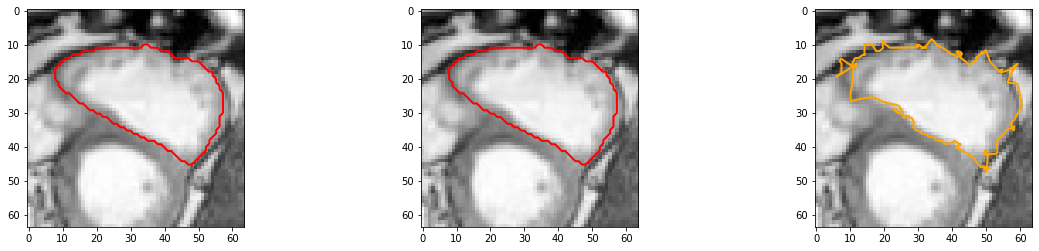

In [96]:
idx = 100

test_images, test_masks = train_gen.__getitem__(201)
predicted_masks = loaded_model.predict(test_images)
# print(predicted_masks[0])
op = np.zeros((64, 64))
for i in range(0, len(predicted_masks[0])):
    for j in range(0, len(predicted_masks[0])):
#         print(predicted_masks[0][i][j][0])
        if predicted_masks[0][i][j][0] > 0.15:
            op[i][j] = 1
        else:
            op[i][j] = 0

contours_pred = measure.find_contours(op, 0.8)

contour_pred = contours_pred[np.argmax([k.shape[0] for k in contours_pred])]

img = test_images[0].reshape((64,64))
ac_contour = active_contour(img, contour_pred, alpha=0.001, beta=0.01) 

contours_pred1 = measure.find_contours(test_masks[0], 0.8)

contour_pred1 = contours_pred[np.argmax([k.shape[0] for k in contours_pred1])]
f, ax = plt.subplots(ncols=3, figsize=(20,4))

ax[0].imshow(img, cmap='gray')
ax[0].plot(contour_pred1[:, 1], contour_pred1[:, 0], linewidth=2, color='red',label='Ground Truth')
ax[1].imshow(img, cmap='gray')
ax[1].plot(contour_pred[:, 1], contour_pred[:, 0], linewidth=2, color='red',label='Prediction')